# <center> RL Project - Snake Game Implentation </center>
## <center> Dargier Antoine - Demy Ugo </center>
## <center> 16/04/2023 </center>

# Table of contents:

* [0. Requirements](#chapter0)
* [1. Environements](#chapter1)
    * [1.1 Environement with possible crossing](#section_1_1)
    * [1.2 Environement without possible crossing](#section_1_2)
* [2. Test environments with random policy](#chapter2)
* [3. Utils functions](#chapter3)
* [4. Agents](#chapter4)
    * [4.1 Q-Learning Agent](#section_4_1)
        * [4.1.1 On environement with possible crossing](#sub_section_4_1_1)
        * [4.1.2 On environement without possible crossing](#sub_section_4_1_2)
    * [4.2 Expected Sarsa Agent](#section_4_2)
        * [4.2.1 On environement with possible crossing](#sub_section_4_2_1)
        * [4.2.2 On environement without possible crossing](#sub_section_4_2_2)
    * [4.3 Deep Q-Network](#section_4_3)
        * [4.3.1 On environement with possible crossing](#sub_section_4_3_1)
        * [4.3.2 On environement without possible crossing](#sub_section_4_3_2)

# 0. Requirements <a class="anchor" id="chapter0"></a>

In [90]:
import gym
import imageio
import numpy as np
import cv2
import random
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# 1. Environments <a class="anchor" id="chapter1"></a>

In [86]:
size = 20 #height, width of the grid to play. Can be changed

def collision_with_apple(apple_position, score, size):
    """
    Whenever the snake eats an apple, this function is called to generate a new apple and increment the score.
    """
    apple_position = [random.randrange(1, size)*10,random.randrange(1, size)*10]
    score += 1
    return apple_position, score

def collision_with_boundaries(snake_head):
    """
    Check if the snake's head has collided with a boundary. If so, the snake is killed.
    """
    if snake_head[0]>=size*10 or snake_head[0]<0 or snake_head[1]>=size*10 or snake_head[1]<0 :
        return True
    else:
        return False

def collision_with_self(snake_position):
    """
    Check if the snake's head has collided with a part of his body. If so, the snake is killed.
    """
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return True
    else:
        return False

## 1.1 Environemnt with possible crossing <a class="anchor" id="section_1_1"></a>

In [87]:
class SnakeEnv(gym.Env):
    def __init__(self, length_goal, max_mov, size):
        super(SnakeEnv, self).__init__()
        self.size = size
        self.length_goal = length_goal
        self.action_space = gym.spaces.Discrete(4) # Since there are 4 possible actions (up, down, left, right)
        self.observation_space = gym.spaces.Box(low=-self.size*10, high=self.size*10, shape=(5+self.length_goal, ), dtype=np.float32)
        self.action = 0
        self.max_mov = max_mov

    def step(self, action):
        self.action = action      
        
        # Change the head position based on the action (the snake can choose to go back)
        if self.action == 1:
            self.snake_head[0] += 10
        elif self.action == 0:
            self.snake_head[0] -= 10
        elif self.action == 2:
            self.snake_head[1] += 10
        elif self.action == 3:
            self.snake_head[1] -= 10
        
        # Increase Snake length on eating apple
        apple_reward = 0
        if self.snake_head == self.apple_position:
            self.apple_position, self.score = collision_with_apple(self.apple_position, self.score, self.size)
            self.snake_position.insert(0, list(self.snake_head))
            apple_reward = 100
            self.nb_actions = 0
        else:
            self.snake_position.insert(0, list(self.snake_head))
            self.snake_position.pop()
             
        #define the reward: -1 if the snake gets close to the apple, -3 otherwise, 97 if it eats the apple
        euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
        self.total_reward = ((2*self.size*10 - euclidean_dist_to_apple) + apple_reward)
        self.reward = np.sign(self.total_reward - self.prev_reward)-2
        self.prev_reward = self.total_reward
        
        #position wrt. apple
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y      
        is_apple_right = np.sign(apple_delta_x) # -1 if left, 1 if right, 0 if good
        is_apple_down = np.sign(apple_delta_y) # -1 if up, 1 if down, 0 if good 
        
        #if the snake does too many moves without eating the apple -> end
        self.nb_actions += 1
        if self.nb_actions>= self.max_mov:
            self.done = True
            self.reward = -100
        # On collision kill the snake and print the score
        elif collision_with_boundaries(self.snake_head):
            self.done = True
            self.reward = -100
        # if snake finish the game, ie eats goal of apples
        elif len(self.snake_position)==self.length_goal:
            self.done = True
            self.reward = 300
        
        # Create observation:
        self.observation = [is_apple_down, is_apple_right]
        self.cumul_reward += self.reward

        return self.observation, self.reward, self.done, {'cumul_reward':self.cumul_reward}
    
    def render(self):
        ##### Screen render #####
        self.img = np.zeros((self.size*10, self.size*10, 3), dtype='uint8')
        # Display Apple
        cv2.rectangle(self.img, (self.apple_position[0], self.apple_position[1]), (self.apple_position[0]+10, self.apple_position[1]+10), (255, 0, 0), 3)
        # Display Snake and its yellow head
        for position in self.snake_position[1:]:
            cv2.rectangle(self.img, (position[0], position[1]), (position[0]+10, position[1]+10), (0, 255, 0), 3)
        cv2.rectangle(self.img, (self.snake_head[0], self.snake_head[1]), (self.snake_head[0]+10, self.snake_head[1]+10), (255, 255, 0), 3)
        plt.imshow(self.img.astype('uint8'))
        plt.axis('off')
        plt.show()

        if self.done:
            print(f'Chosen action: {self.action} ({corres_action[self.action]})')
            print(f'Reward received: {self.reward}\n')
            print(f'\n---------- GAME OVER ----------\nYou lost after eating {self.score} apples, well done!\nPlay again?\n-------------------------------\n')
        return self.img.astype('uint8')


    def reset(self):
        self.img = np.zeros((self.size*10, self.size*10, 3), dtype='uint8') # Create screen render
        # Initial Snake and Apple position
        self.snake_position = [[self.size*10//2, self.size*10//2], [(self.size-1)*10//2, self.size*10//2], [(self.size-1)*10//2, self.size*10//2]]
        self.apple_position = [random.randrange(1, size)*10, random.randrange(1, size)*10]
        self.score = 0
        self.apple_reward = 0
        self.snake_head = [self.size*10//2, self.size*10//2]
        
        self.cumul_reward = 0
        self.prev_reward = 0
        self.done = False

        #define first positions wrt. apple
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y       
        is_apple_right = np.sign(apple_delta_x) # -1 if left, 1 if right, 0 if good
        is_apple_down = np.sign(apple_delta_y) # -1 if up, 1 if down, 0 if good

        self.nb_actions = 0
        # Create observation:
        self.observation = [is_apple_down, is_apple_right]
        self.observation = np.array(self.observation)

        return self.observation # Position of the snake wrt. apple

## 1.2 Environemnt without possible crossing <a class="anchor" id="section_1_2"></a>

In [107]:
class SnakeEnvBound(gym.Env):
    def __init__(self, length_goal, max_mov, size):
        super(SnakeEnvBound, self).__init__()
        self.size = size
        self.length_goal = length_goal
        self.action_space = gym.spaces.Discrete(4) # Since there are 4 possible actions (up, down, left, right)
        self.observation_space = gym.spaces.Box(low=-self.size*10, high=self.size*10, shape=(5+self.length_goal, ), dtype=np.float32)
        self.action = 0
        self.max_mov = max_mov

    def step(self, action):
        self.action = action
        
        #if the snake does too many moves without eating the apple -> end
        self.nb_actions += 1
        if self.nb_actions>= self.max_mov:
            self.done = True
            self.reward = -100

        # Change the head position based on the action (the snake can choose to go back)
        if self.action == 1:
            self.snake_head[0] += 10
        elif self.action == 0:
            self.snake_head[0] -= 10
        elif self.action == 2:
            self.snake_head[1] += 10
        elif self.action == 3:
            self.snake_head[1] -= 10
        
        #define position wrt. boundaries
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        is_snake_bound_right = 0
        is_snake_bound_left = 0
        is_snake_bound_up = 0
        is_snake_bound_down = 0
        if head_x == (size-1)*10:
            is_snake_bound_right = 1
        elif head_x == 0:
            is_snake_bound_left = 1
        if head_y == (size-1)*10:
            is_snake_bound_down = 1
        elif head_y == 0:
            is_snake_bound_up = 1
        
        # Increase Snake length on eating apple
        apple_reward = 0
        if self.snake_head == self.apple_position:
            self.apple_position, self.score = collision_with_apple(self.apple_position, self.score, self.size)
            self.snake_position.insert(0, list(self.snake_head))
            apple_reward = 100
            self.nb_actions = 0
        else:
            self.snake_position.insert(0, list(self.snake_head))
            self.snake_position.pop()
        
        #define the reward: -1 if the snake gets close to the apple, -3 otherwise, 97 if it eats the apple
        euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
        self.total_reward = (2*self.size*10 - euclidean_dist_to_apple)
        self.reward = np.sign(self.total_reward - self.prev_reward) -2 + apple_reward
        self.prev_reward = self.total_reward
        
        #define position wrt. snake body
        snake_at_left = 0
        snake_at_right = 0
        snake_at_up = 0
        snake_at_down = 0
        if [head_x+10, head_y] in self.snake_position[1:]:
            snake_at_right = 1
        if [head_x-10, head_y] in self.snake_position[1:]:
            snake_at_left = 1
        if [head_x, head_y+10] in self.snake_position[1:]:
            snake_at_down = 1
        if [head_x, head_y-10] in self.snake_position[1:]:
            snake_at_up = 1
        
        
        # On collision kill the snake and print the score
        if collision_with_boundaries(self.snake_head) or collision_with_self(self.snake_position):
            self.done = True
            self.reward = -100
        if len(self.snake_position)==self.length_goal:
            self.done = True
            self.reward = 300
        
        #define position wrt. apple
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y
        apple_is_left = np.sign(apple_delta_x) # -1 if left, 1 if right, 0 if good
        apple_is_up = np.sign(apple_delta_y) # -1 if up, 1 if down, 0 if good

        # Create observation:
        self.observation = [apple_is_up, apple_is_left, is_snake_bound_up, is_snake_bound_down, is_snake_bound_left, is_snake_bound_right, snake_at_left, snake_at_right, snake_at_up, snake_at_down]
        self.cumul_reward += self.reward

        return self.observation, self.reward, self.done, {'cumul_reward':self.cumul_reward}
    
    def render(self):
        ##### Screen render #####
        self.img = np.zeros((self.size*10, self.size*10, 3), dtype='uint8')
        # Display Apple
        cv2.rectangle(self.img, (self.apple_position[0], self.apple_position[1]), (self.apple_position[0]+10, self.apple_position[1]+10), (255, 0, 0), 3)
        # Display Snake and its yellow head
        for position in self.snake_position[1:]:
            cv2.rectangle(self.img, (position[0], position[1]), (position[0]+10, position[1]+10), (0, 255, 0), 3)
        cv2.rectangle(self.img, (self.snake_head[0], self.snake_head[1]), (self.snake_head[0]+10, self.snake_head[1]+10), (255, 255, 0), 3)
        plt.imshow(self.img.astype('uint8'))
        plt.axis('off')
        plt.show()

        if self.done:
            print(f'Chosen action: {self.action} ({corres_action[self.action]})')
            print(f'Reward received: {self.reward}\n')
            print(f'\n---------- GAME OVER ----------\nYou lost after eating {self.score} apples, well done!\nPlay again?\n-------------------------------\n')
        return self.img.astype('uint8')

    def reset(self):
        self.img = np.zeros((self.size*10, self.size*10, 3), dtype='uint8') # Create screen render
        # Initial Snake and Apple position
        self.snake_position = [[self.size*10//2, self.size*10//2], [(self.size-1)*10//2, self.size*10//2], [(self.size-1)*10//2, self.size*10//2]]
        self.apple_position = [random.randrange(1, size)*10, random.randrange(1, size)*10]
        self.score = 0
        self.snake_head = [self.size*10//2, self.size*10//2]

        self.cumul_reward = 0
        self.prev_reward = 0
        self.done = False

        #define position wrt. first apple
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y
        apple_is_left = np.sign(apple_delta_x) # -1 if left, 1 if right, 0 if good
        apple_is_up = np.sign(apple_delta_y) # -1 if up, 1 if down, 0 if good
        
        #define position wrt. boundaries
        is_snake_bound_right = 0
        is_snake_bound_left = 0
        is_snake_bound_up = 0
        is_snake_bound_down = 0
        
        #define position wrt. snake body
        snake_at_left = 0
        snake_at_right = 0
        snake_at_up = 0
        snake_at_down = 0

        self.nb_actions = 0
        # Create observation:
        self.observation = [apple_is_up, apple_is_left, is_snake_bound_up, is_snake_bound_down, is_snake_bound_left, is_snake_bound_right, snake_at_left, snake_at_right, snake_at_up, snake_at_down]
        self.observation = np.array(self.observation)

        return self.observation # Positions wrt. apple, boundaries, body

# 2. Test environments with random policy <a class="anchor" id="chapter2"></a>

Current state:


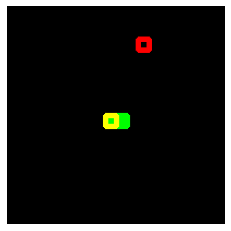

Action number: 1
Chosen action: 0 (left)
Reward received: -1.0

Current state:


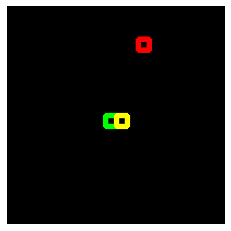

Action number: 2
Chosen action: 1 (right)
Reward received: -1.0

Current state:


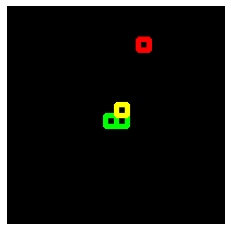

Action number: 3
Chosen action: 3 (up)
Reward received: -1.0

Current state:


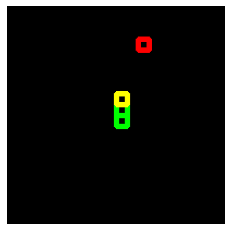

Action number: 4
Chosen action: 3 (up)
Reward received: -1.0

Current state:


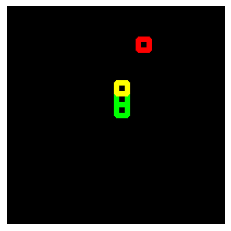

Action number: 5
Chosen action: 3 (up)
Reward received: -1.0

Current state:


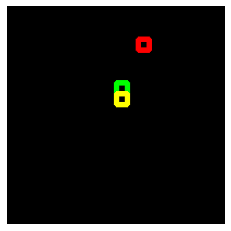

Action number: 6
Chosen action: 2 (down)
Reward received: -3.0

Current state:


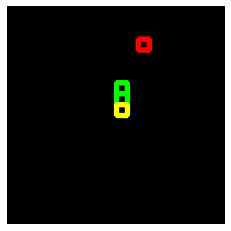

Action number: 7
Chosen action: 2 (down)
Reward received: -3.0

Current state:


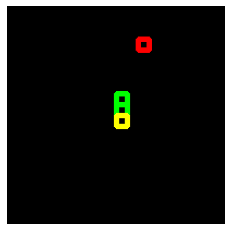

Action number: 8
Chosen action: 2 (down)
Reward received: -3.0

Current state:


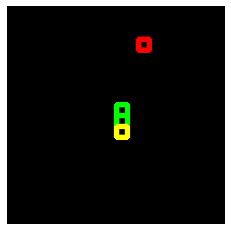

Action number: 9
Chosen action: 2 (down)
Reward received: -3.0

Current state:


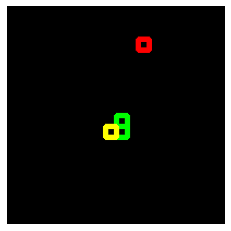

Action number: 10
Chosen action: 0 (left)
Reward received: -3.0

Current state:


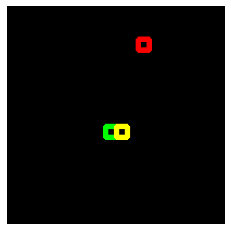

Action number: 11
Chosen action: 1 (right)
Reward received: -1.0

Current state:


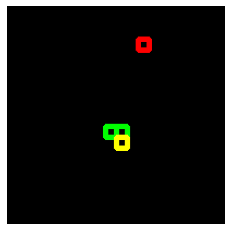

Action number: 12
Chosen action: 2 (down)
Reward received: -3.0

Current state:


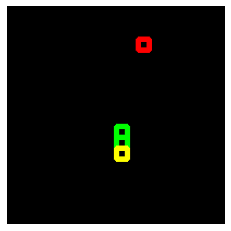

Action number: 13
Chosen action: 2 (down)
Reward received: -3.0

Current state:


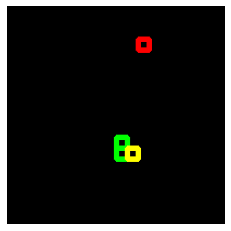

Action number: 14
Chosen action: 1 (right)
Reward received: -1.0

Current state:


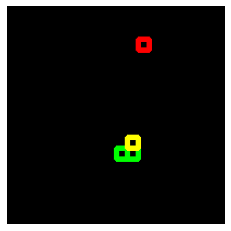

Action number: 15
Chosen action: 3 (up)
Reward received: -1.0

Current state:


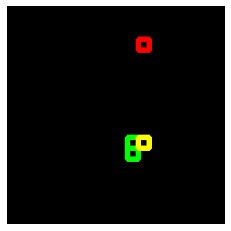

Action number: 16
Chosen action: 1 (right)
Reward received: -1.0

Current state:


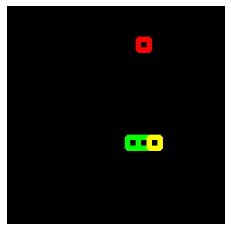

Action number: 17
Chosen action: 1 (right)
Reward received: -3.0

Current state:


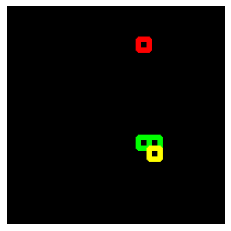

Action number: 18
Chosen action: 2 (down)
Reward received: -3.0

Current state:


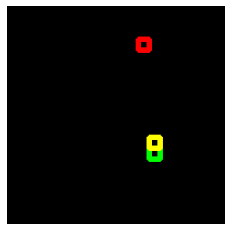

Action number: 19
Chosen action: 3 (up)
Reward received: -1.0

Current state:


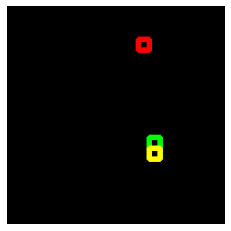

Chosen action: 2 (down)
Reward received: -100


---------- GAME OVER ----------
You lost after eating 0 apples, well done!
Play again?
-------------------------------



In [55]:
env = SnakeEnv(length_goal=30, max_mov = 20)
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}

for episode in range(episodes):
    done = False
    obs = env.reset()
    i = 0
    while not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)
        i+=1
        print('Current state:')
        env.render()
        if not done:
            print(f'Action number: {i}')
            print(f'Chosen action: {random_action} ({corres_action[random_action]})')
            print(f'Reward received: {reward}\n')

# 3. Utils functions <a class="anchor" id="chapter3"></a>

In [4]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    for i in range(len(q_values)):
        if q_values[i]>top:
            top = q_values[i]
            ties = [i]
        elif q_values[i]==top:
            ties.append(i)
    ind = np.random.choice(ties)    
    return ind

In [79]:
def train(algorithm, num_episodes, env, agent_init_info):
    current_agent = algorithm(agent_init_info)
    q = {}
    reward_sums = []
    for i in range(num_episodes):
        pas = int(num_episodes/20)
        if (i%pas)==0:
            print(f'advancement: {100*i/num_episodes}%')
        state = env.reset()
        state = tuple(state)
        done = False
        total_reward = 0
        while not done:
            action = current_agent.act(q, state)
            next_state, reward, done, info, = env.step(action)
            next_state = tuple(next_state)
            if algorithm==QLearningAgent:
                next_action = _
            else:
                next_action = current_agent.act(q, next_state)
            total_reward += reward
            current_agent.update(q, state, action, next_state, next_action, reward)
            state = next_state
            if done:
                break
        reward_sums.append(total_reward)
        env.close()
    return q, reward_sums

In [80]:
def plot_durations(scores, show_result=False):
    """
    Plot the scores obtained by an agent trained in a reinforcement learning environment.
    """
    plt.figure(1)
    scores_t = torch.tensor(scores, dtype=torch.float)
    if show_result:
        plt.title('Final results')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.plot(scores_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# 4. Agents <a class="anchor" id="chapter4"></a>

## 4.1 Q-Learning Agent <a class="anchor" id="section_4_1"></a>

In [81]:
class QLearningAgent():
    """
    First Agent: Q-Learning agent
    """        
    
    def __init__(self, agent_init_info):
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
    
    def act(self, q, state):
        """
        epsilon-greedy policy
        """
        if state not in list(q.keys()):
            q[state] = [-10000,-10000,-10000,-10000]
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = argmax(q[state])
        return current_action
        
    def update(self, q, state, action, next_state, next_action, reward):
        current_q = q[state][action]
        next_q = np.max(q[state])
        q[state][action] = current_q + self.step_size * (reward +  self.discount * next_q - current_q)

### 4.1.1 On environement with possible crossing <a class="anchor" id="sub_section_4_1_1"></a>

In [88]:
num_episodes = 2000
size = 20
env = SnakeEnv(length_goal=30, max_mov = 2*size, size = size)
agent_init_info = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}

q_qlearning, reward_sums_qlearning = train(QLearningAgent, num_episodes, env, agent_init_info)

advancement: 0.0%
advancement: 5.0%
advancement: 10.0%
advancement: 15.0%
advancement: 20.0%
advancement: 25.0%
advancement: 30.0%
advancement: 35.0%
advancement: 40.0%
advancement: 45.0%
advancement: 50.0%
advancement: 55.0%
advancement: 60.0%
advancement: 65.0%
advancement: 70.0%
advancement: 75.0%
advancement: 80.0%
advancement: 85.0%
advancement: 90.0%
advancement: 95.0%


The mean cumulative reward obtained by the Q-Learning agent: -294.403



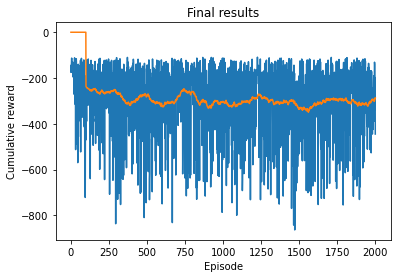

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [91]:
print(f'The mean cumulative reward obtained by the Q-Learning agent: {np.mean(reward_sums_qlearning)}\n')
plot_durations(reward_sums_qlearning, show_result=True)

In [92]:
print(f'Q Table: \n')
sorted_keys = sorted(q_qlearning.keys(), key=lambda k: (k[0], k[1]))
for key in sorted_keys:
    print(key, q_qlearning[key])

Q Table: 

(-1, -1) [-5.799788273833391, -7.128318287885991, -7.06230617270449, -5.026508551840477]
(-1, 0) [-8.086238789867389, -7.6958352566226065, -7.842990771518524, -5.579367476789181]
(-1, 1) [-7.4704147136265915, -5.495365902716483, -7.507730020521601, -6.545055444795317]
(0, -1) [204.97529250908207, -7.96469309975715, -7.989914864036933, -7.895471549595892]
(0, 0) [-32.476131236343925, -1785.6779537207644, -1565.2540914093565, -10000]
(0, 1) [-7.645522008404406, -5.868901732113733, -34.5517968707293, -8.302827983989665]
(1, -1) [-6.644540912172133, -7.74641816996452, -6.261368235749044, -7.3132257075562555]
(1, 0) [-4.916799428439545, -4.10838321928358, -5.48342568945313, -7.5645003259799966]
(1, 1) [-7.258749776872839, -6.639360788083515, -5.256190223772048, -7.6317576621046594]


Current state:


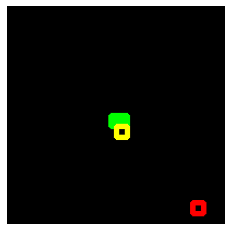

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


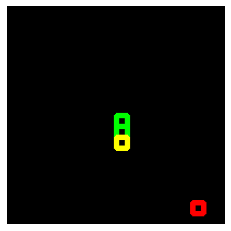

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


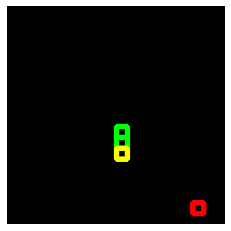

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


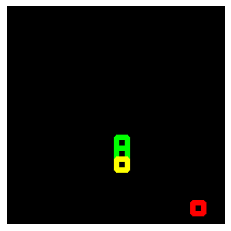

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


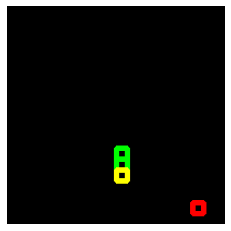

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


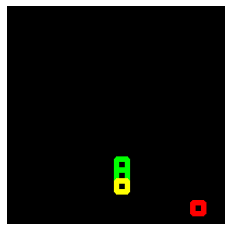

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


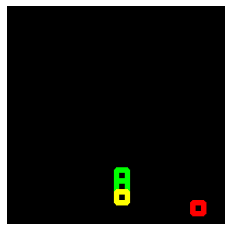

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


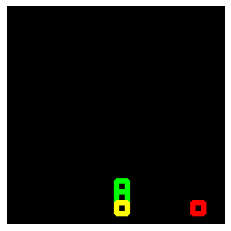

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


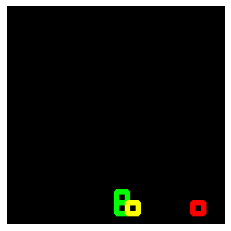

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


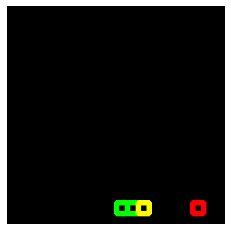

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


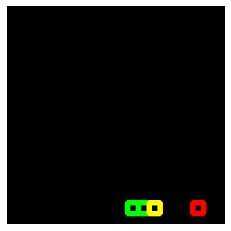

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


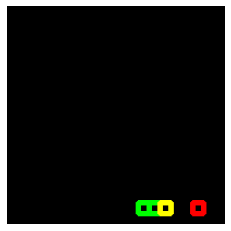

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


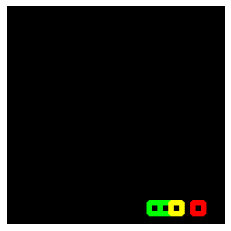

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


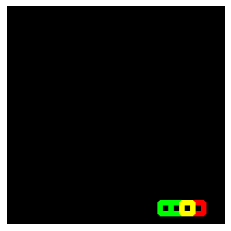

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


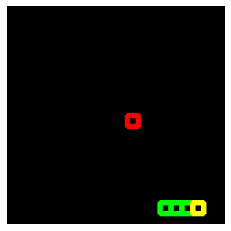

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


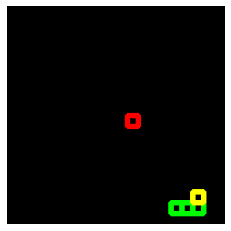

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


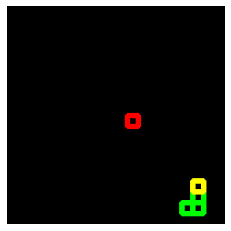

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


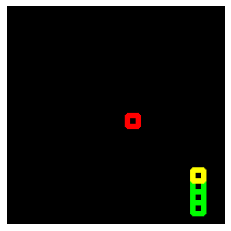

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


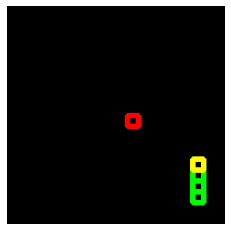

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


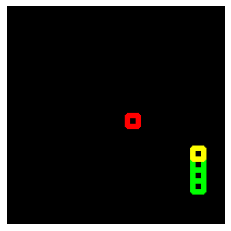

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


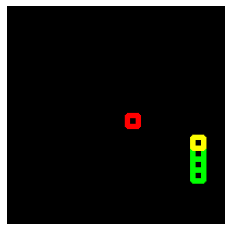

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


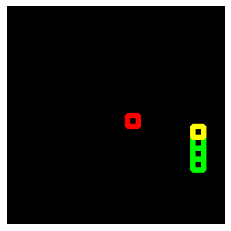

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


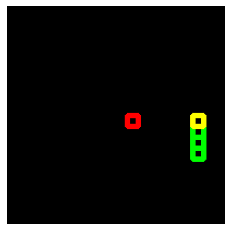

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


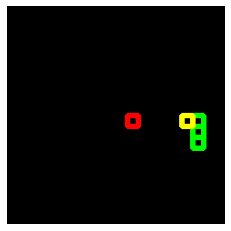

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


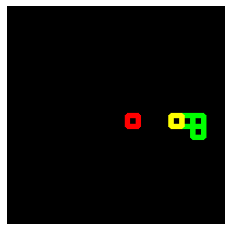

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


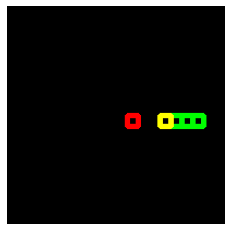

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


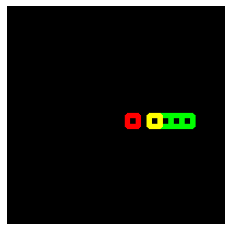

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


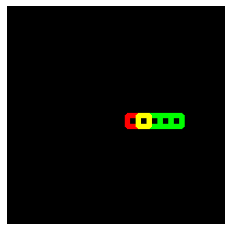

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


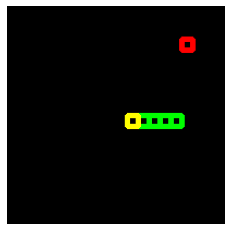

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


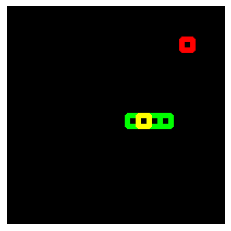

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


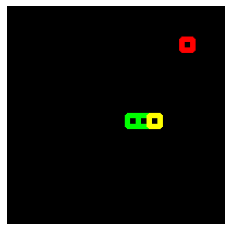

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


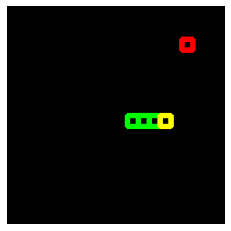

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


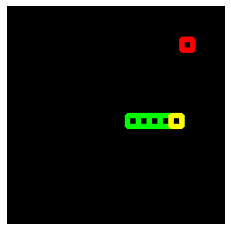

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


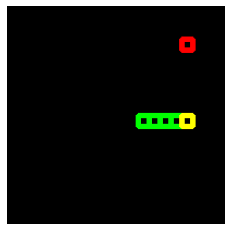

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


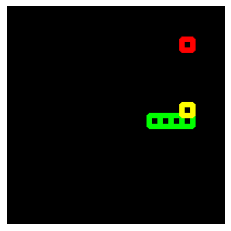

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


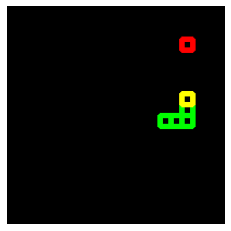

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


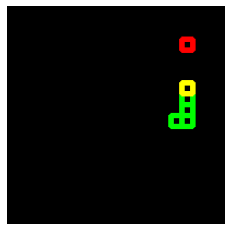

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


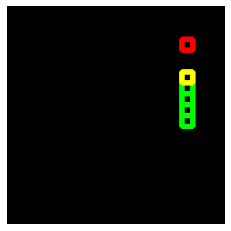

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


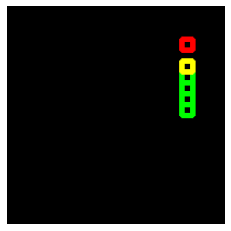

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


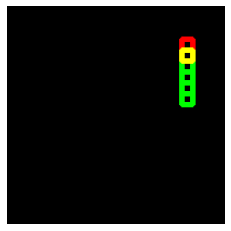

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


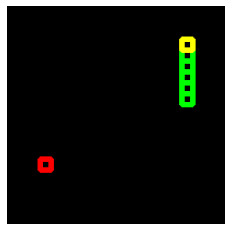

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


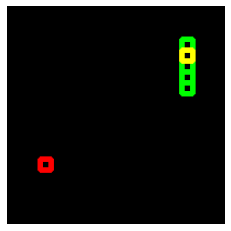

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


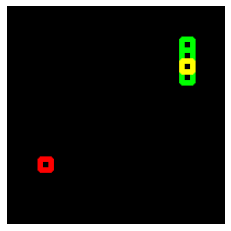

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


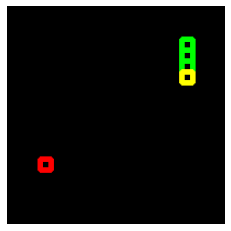

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


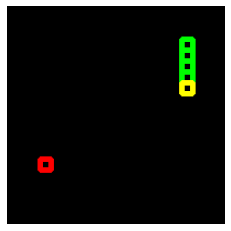

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


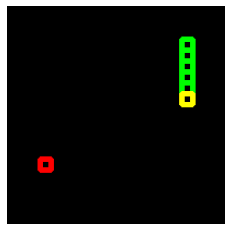

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


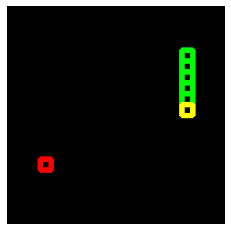

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


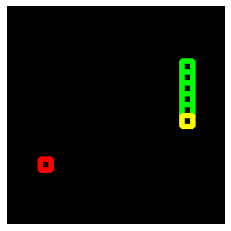

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


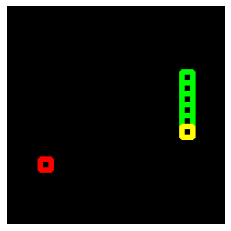

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


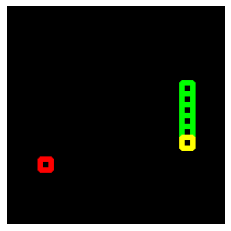

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


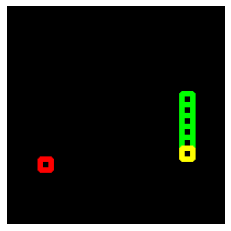

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


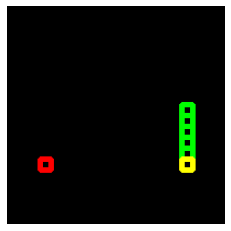

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


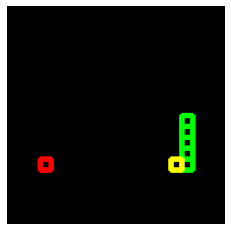

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


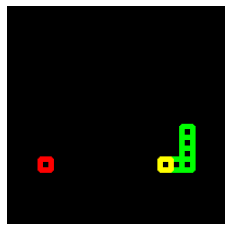

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


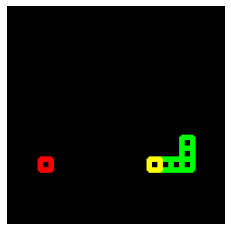

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


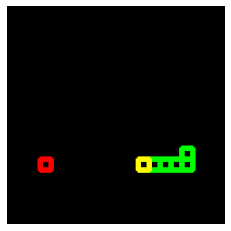

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


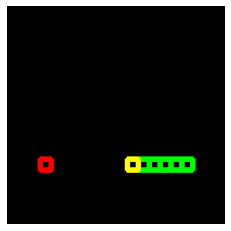

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


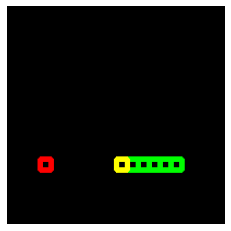

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


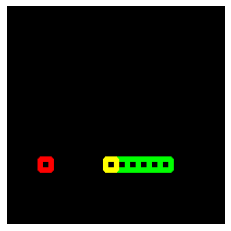

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


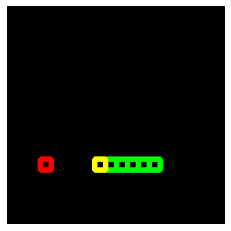

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


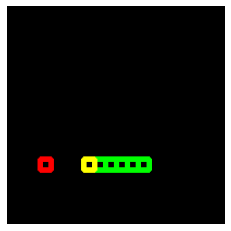

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


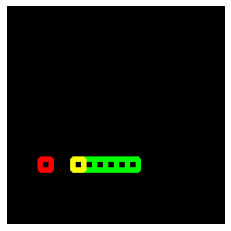

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


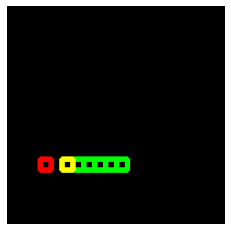

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


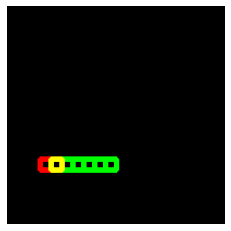

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


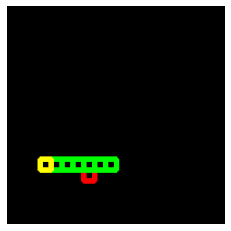

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


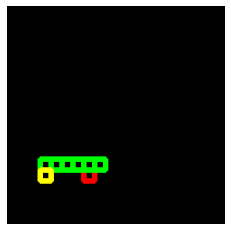

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -3.0

Current state:


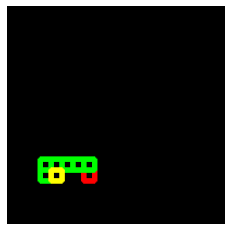

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


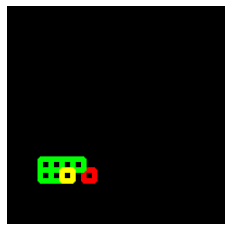

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


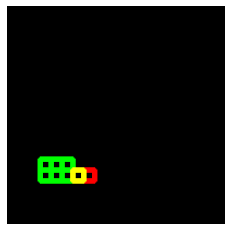

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


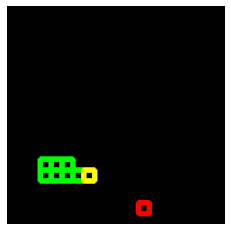

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


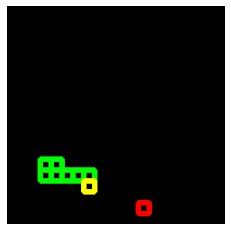

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


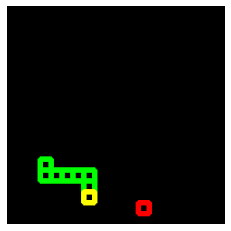

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


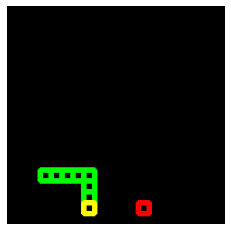

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


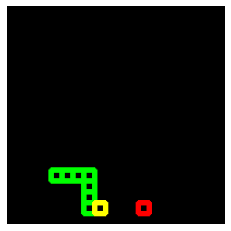

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


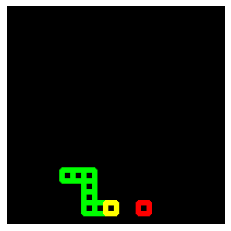

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


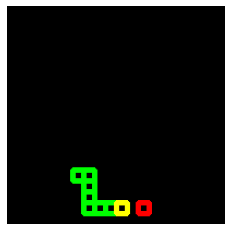

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


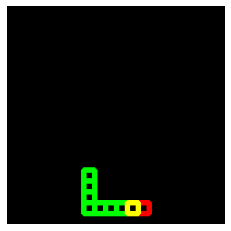

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


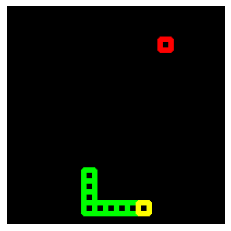

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


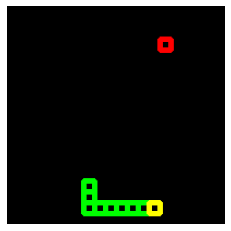

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


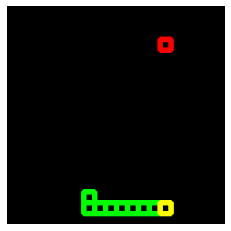

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


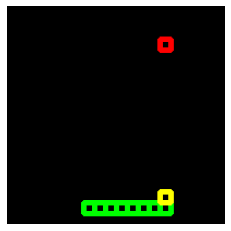

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


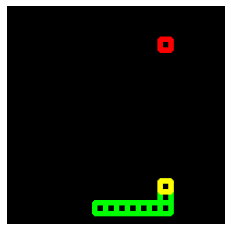

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


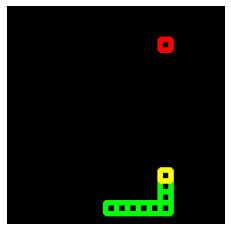

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


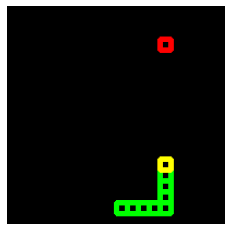

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


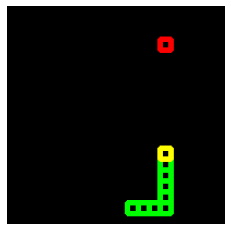

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


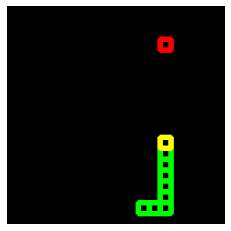

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


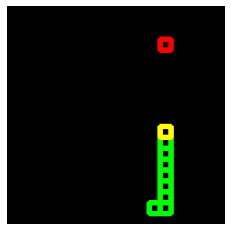

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


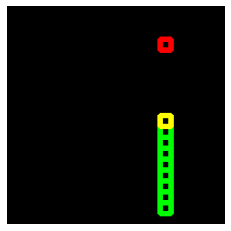

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


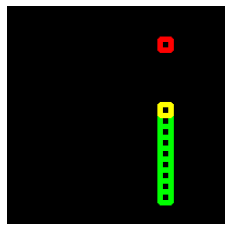

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


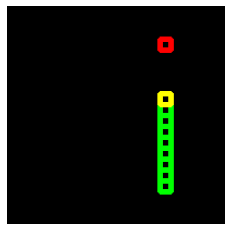

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


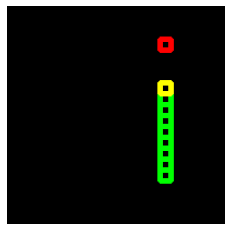

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


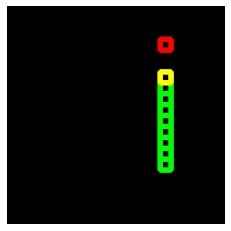

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


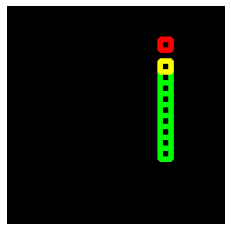

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


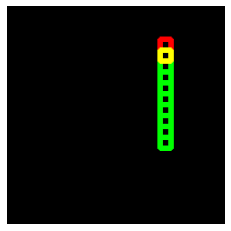

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


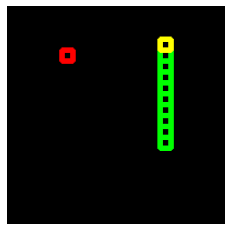

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


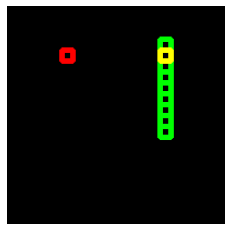

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -3.0

Current state:


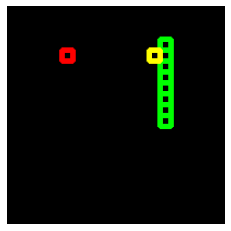

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


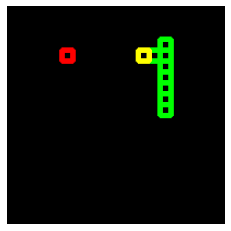

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


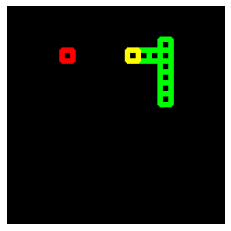

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


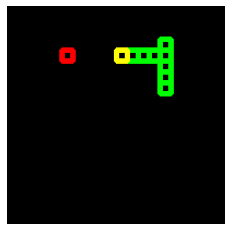

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


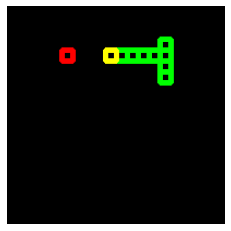

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


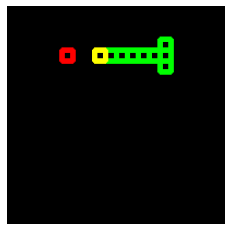

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


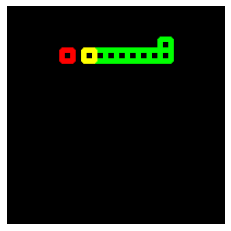

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


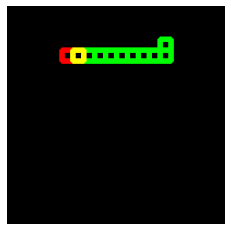

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


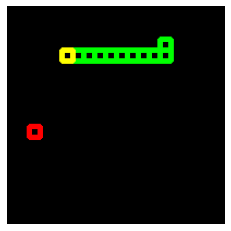

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


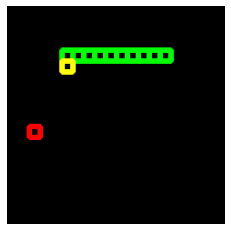

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


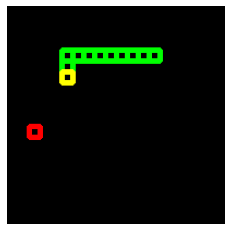

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


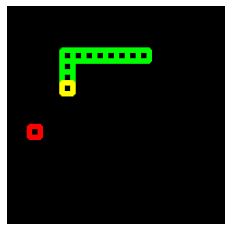

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


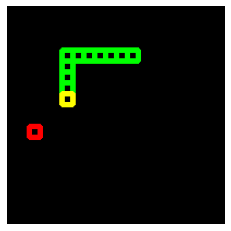

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


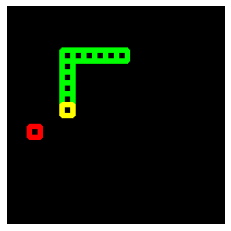

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


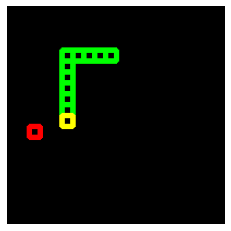

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


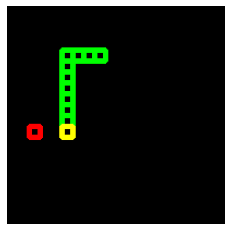

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


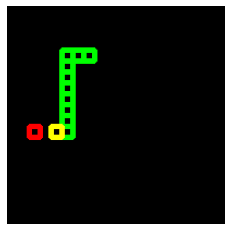

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


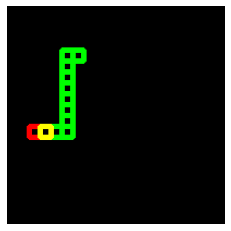

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


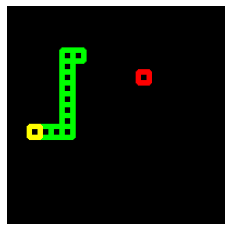

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


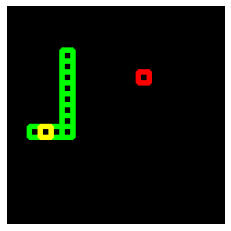

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


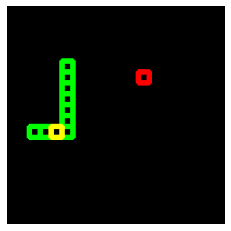

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


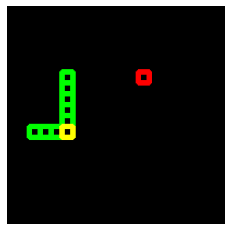

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


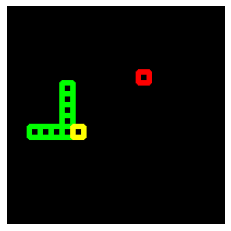

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


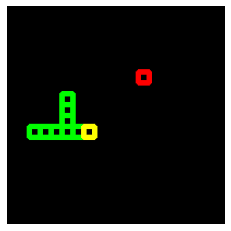

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


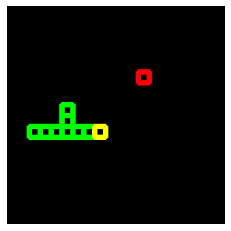

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


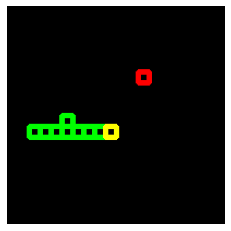

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


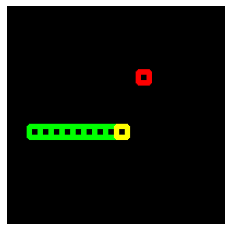

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


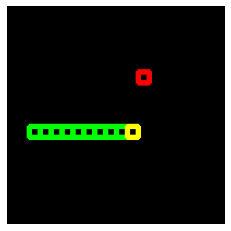

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


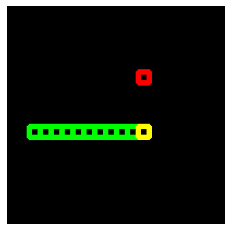

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


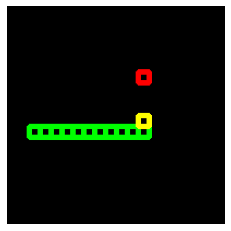

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


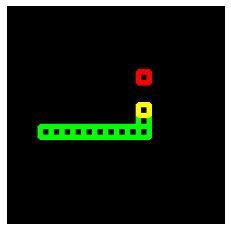

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


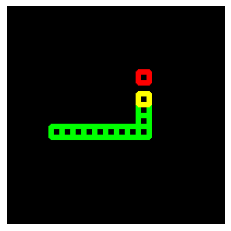

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


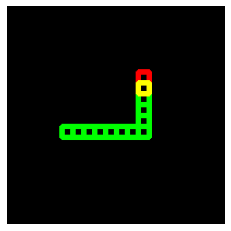

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


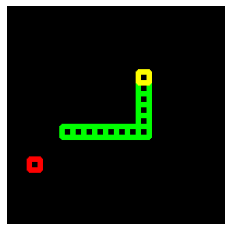

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


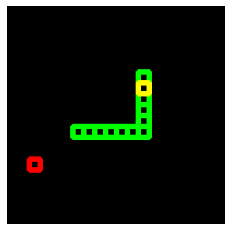

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


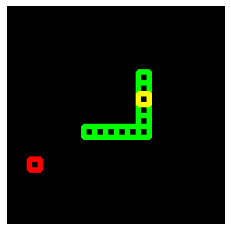

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


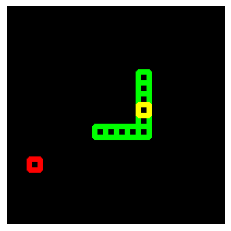

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


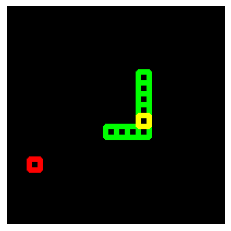

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


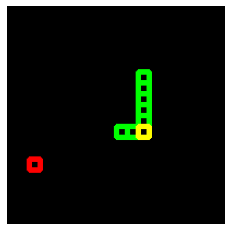

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


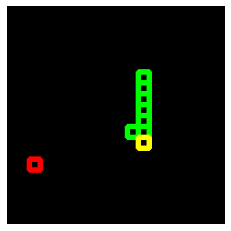

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


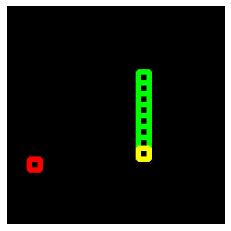

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


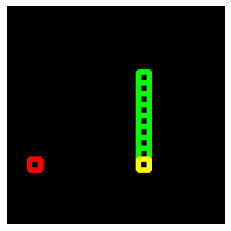

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


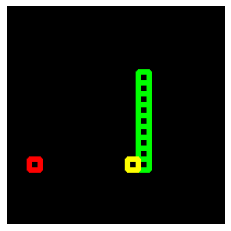

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


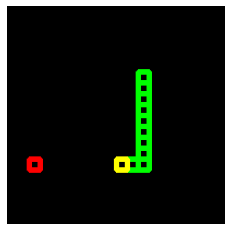

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


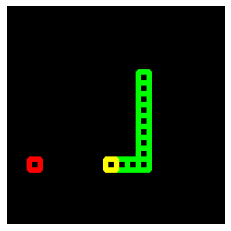

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


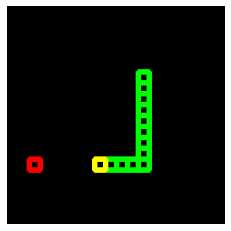

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


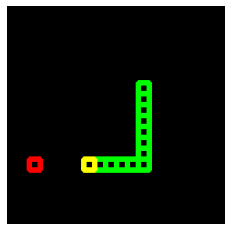

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


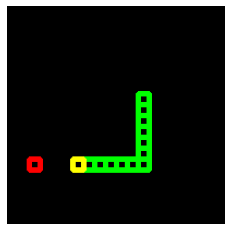

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


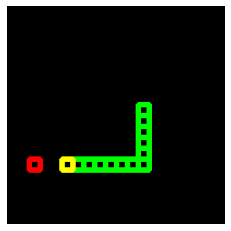

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


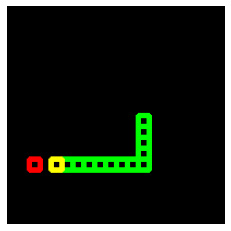

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


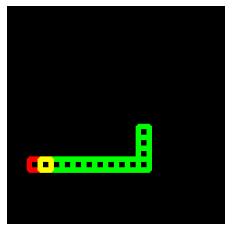

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


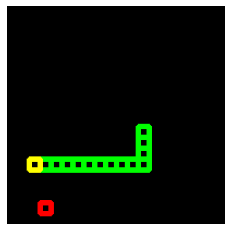

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


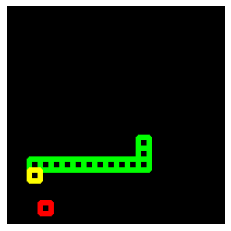

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


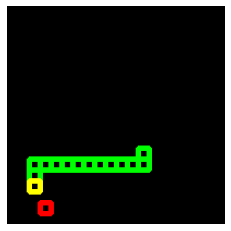

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


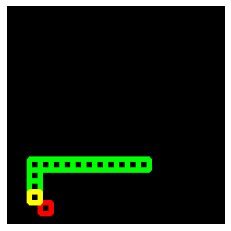

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


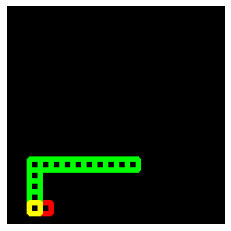

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


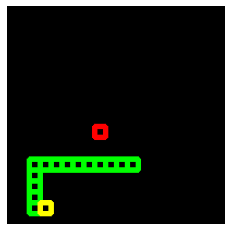

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


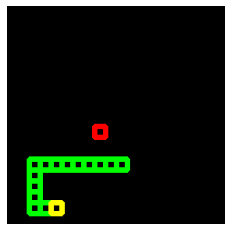

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


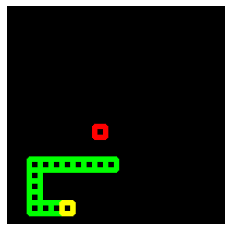

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


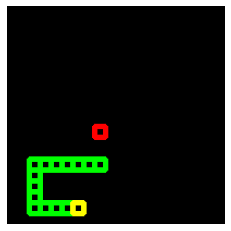

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


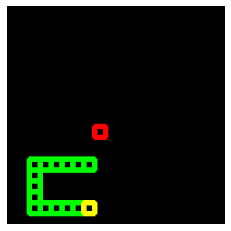

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


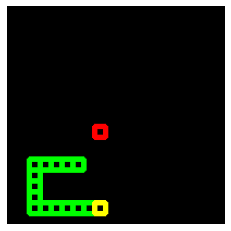

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


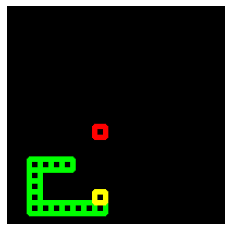

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


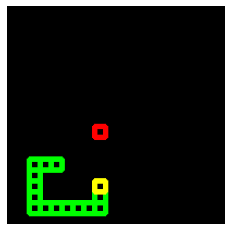

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


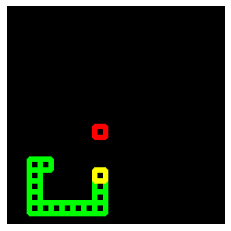

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


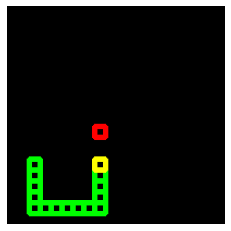

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


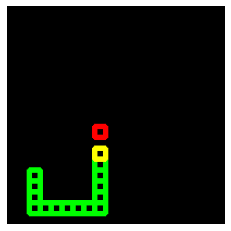

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


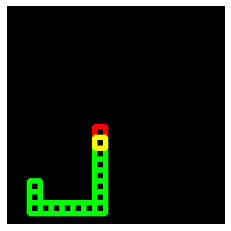

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


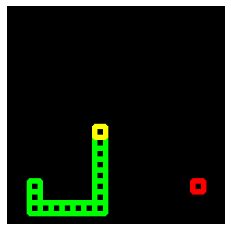

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


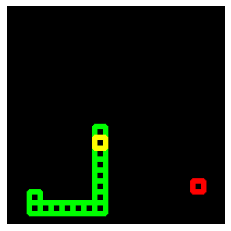

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


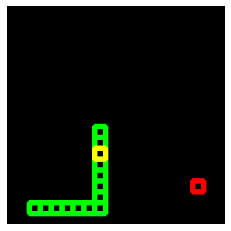

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


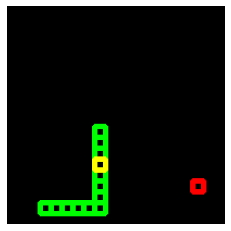

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


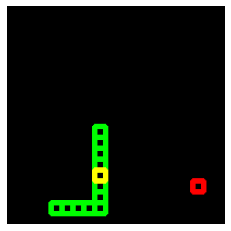

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


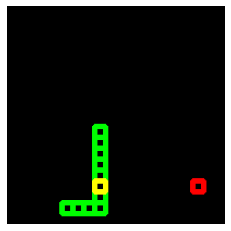

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


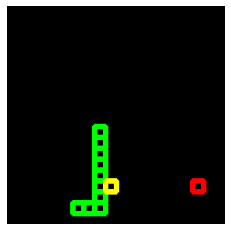

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


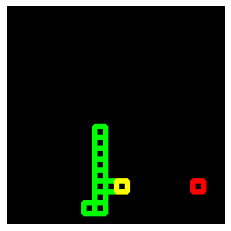

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


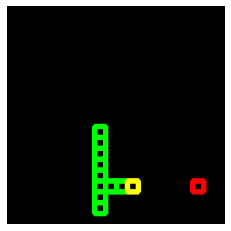

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


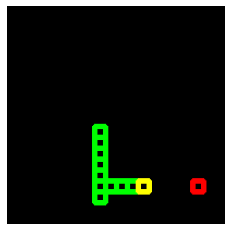

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


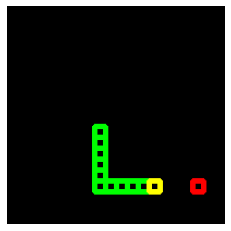

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


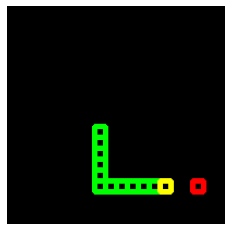

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


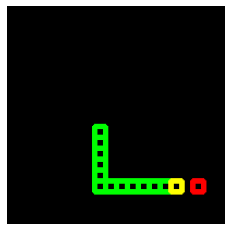

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


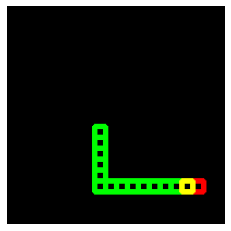

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


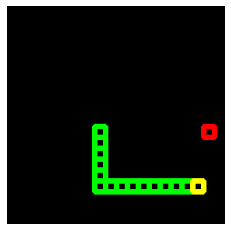

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


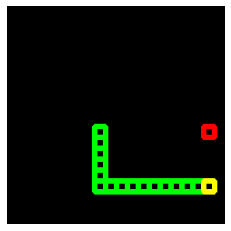

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -3.0

Current state:


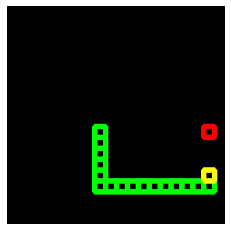

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


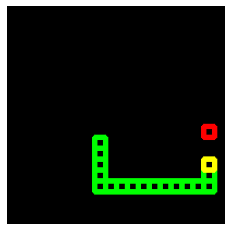

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


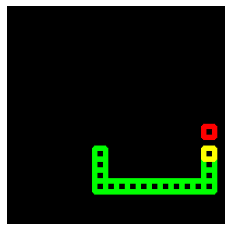

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


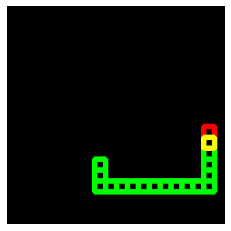

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


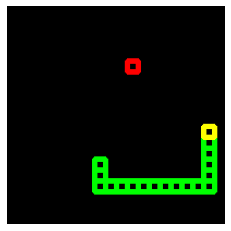

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


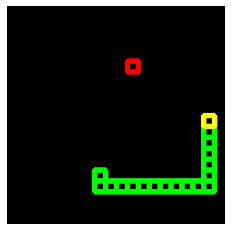

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


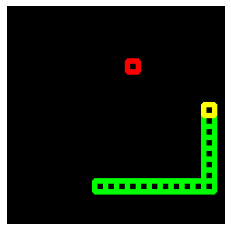

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


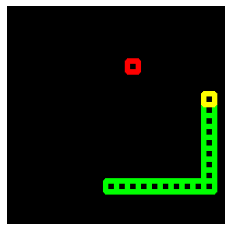

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


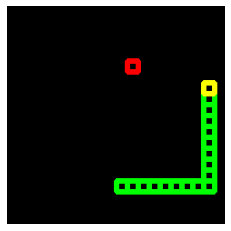

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


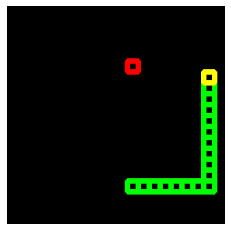

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


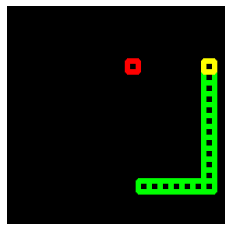

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


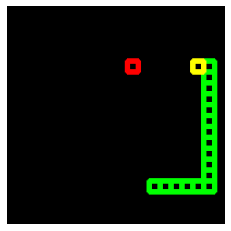

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


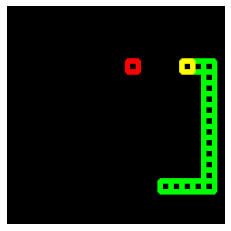

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


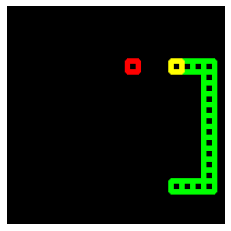

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


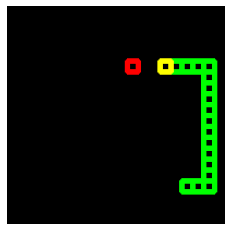

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


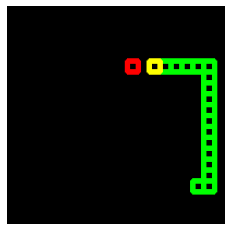

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


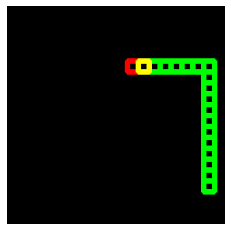

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


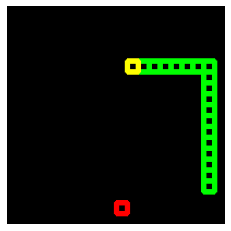

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


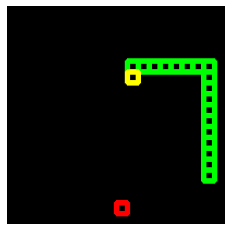

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


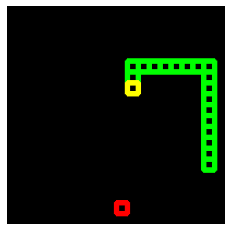

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


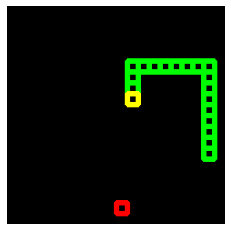

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


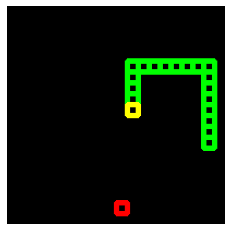

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


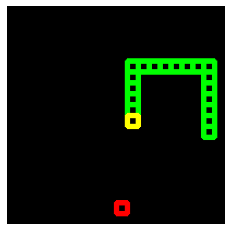

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


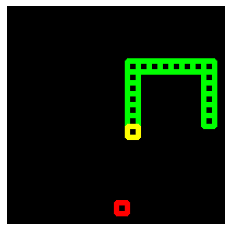

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


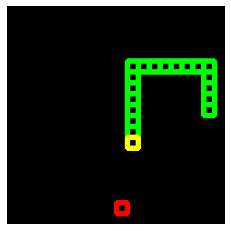

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


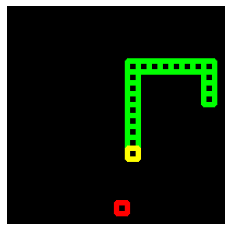

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


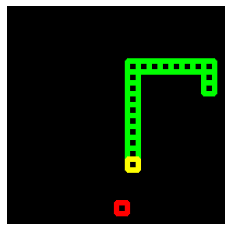

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


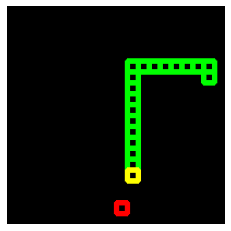

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


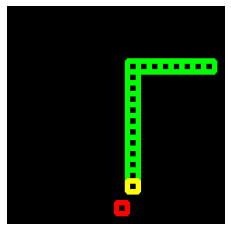

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


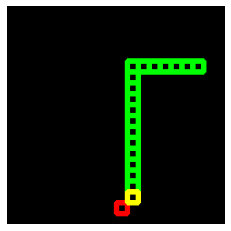

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


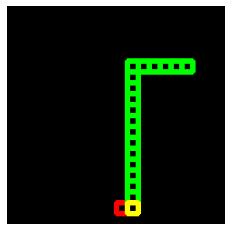

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


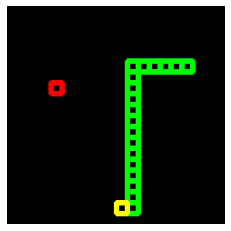

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


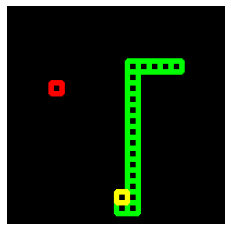

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


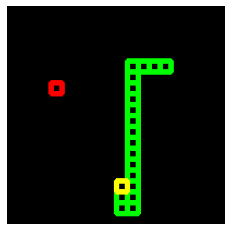

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


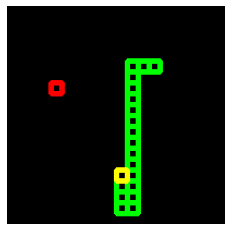

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


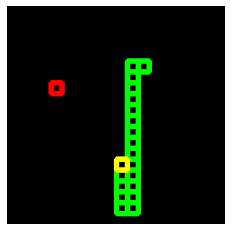

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


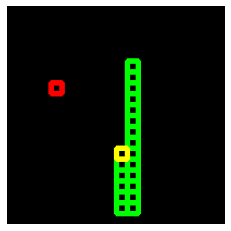

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


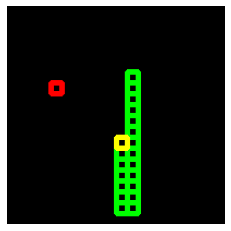

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


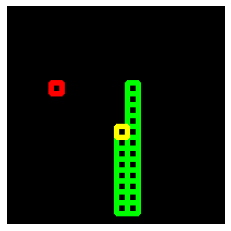

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


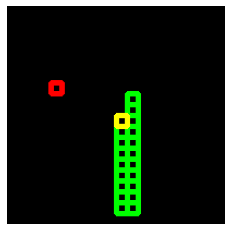

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


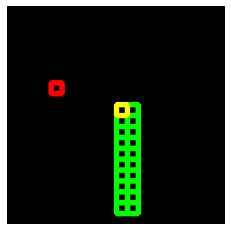

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


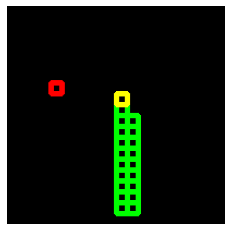

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


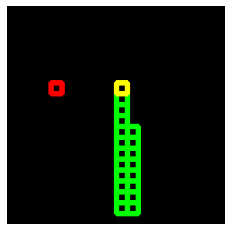

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


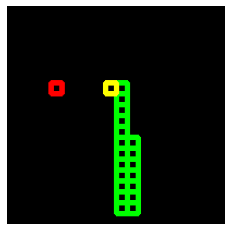

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


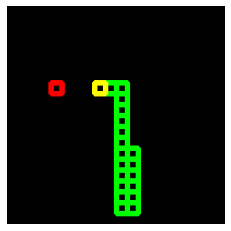

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


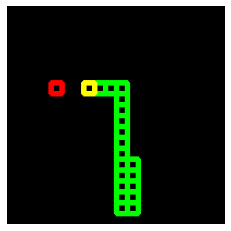

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


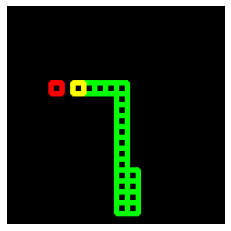

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


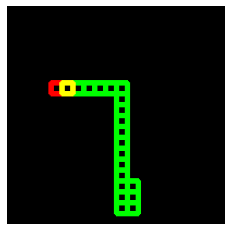

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


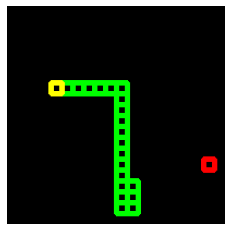

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


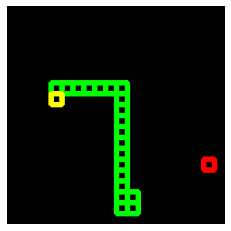

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


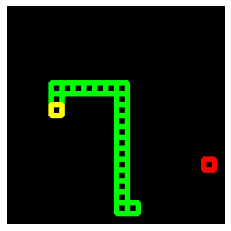

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


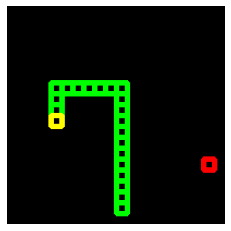

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


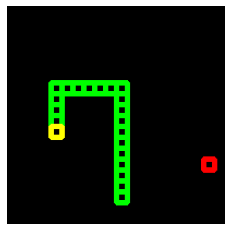

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


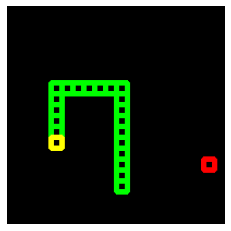

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


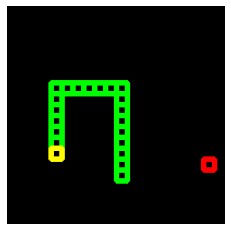

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


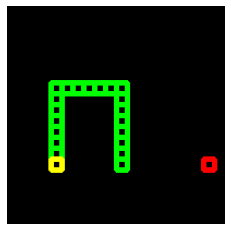

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


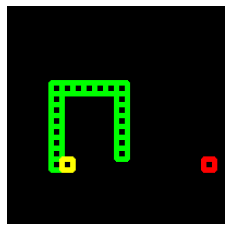

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


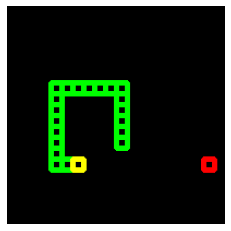

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


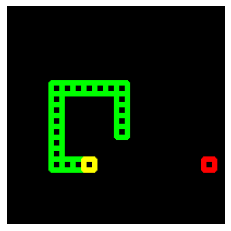

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


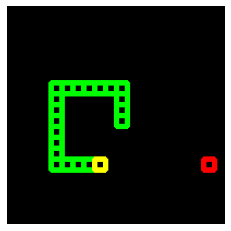

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


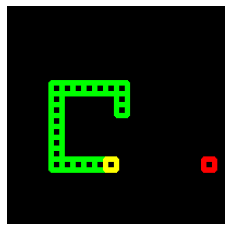

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


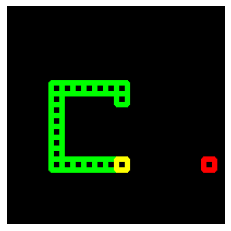

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


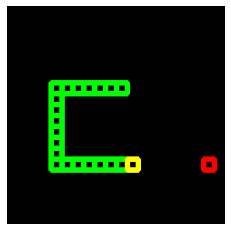

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


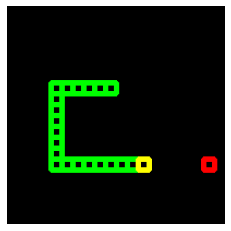

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


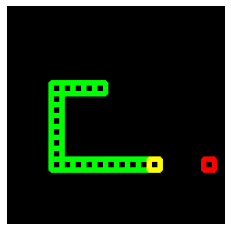

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


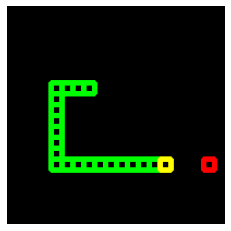

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


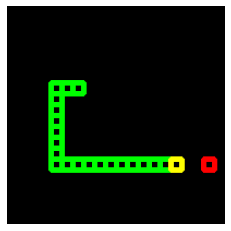

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


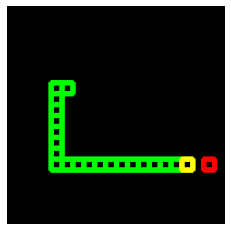

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


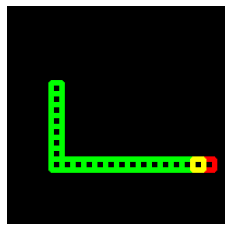

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


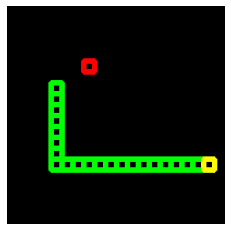

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


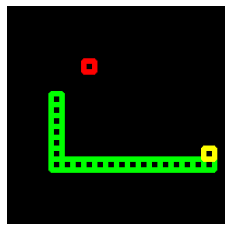

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


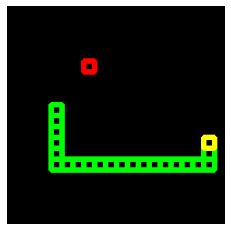

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


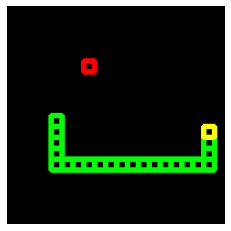

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


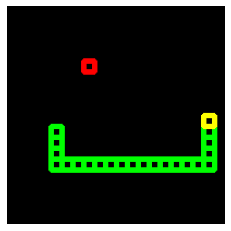

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


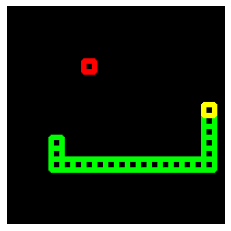

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


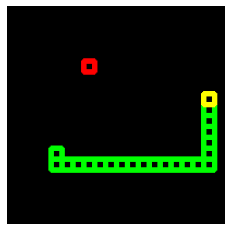

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


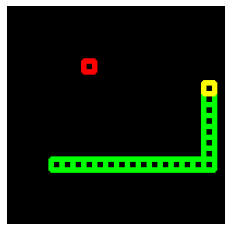

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


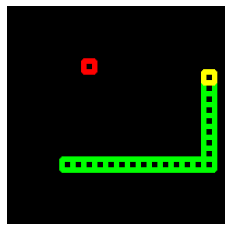

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


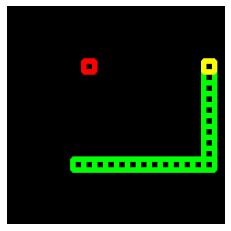

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


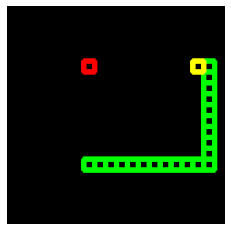

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


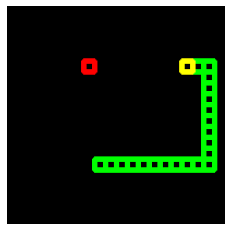

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


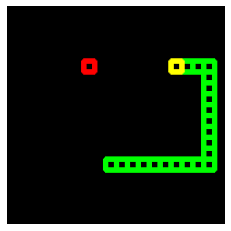

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


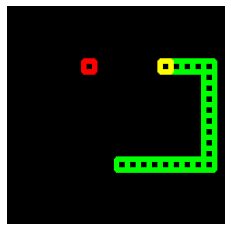

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


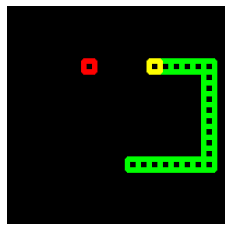

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


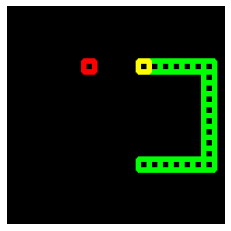

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


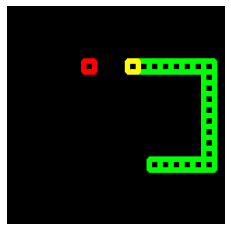

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


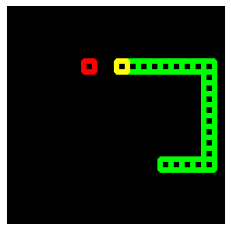

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


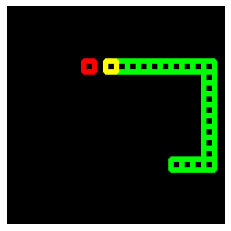

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


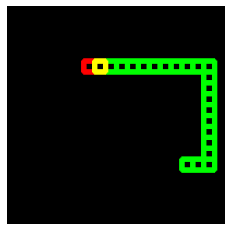

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


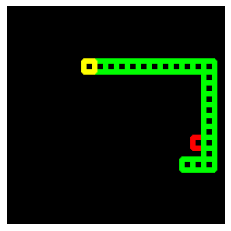

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


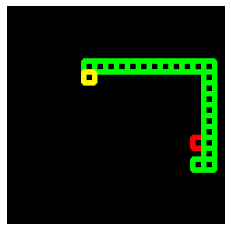

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


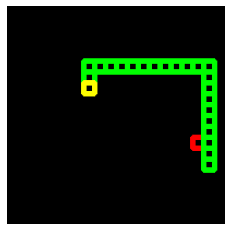

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


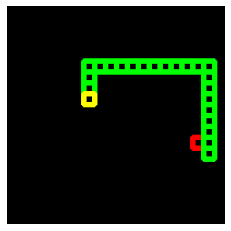

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


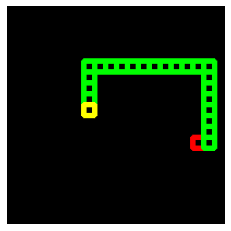

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


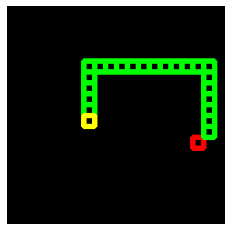

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


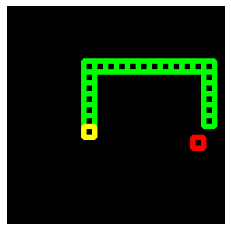

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


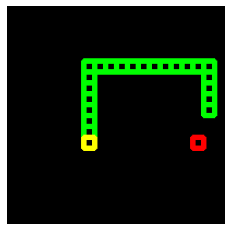

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


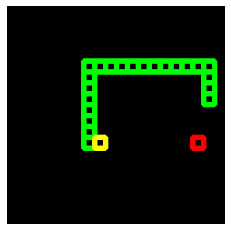

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


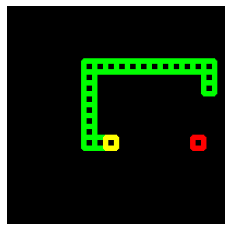

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


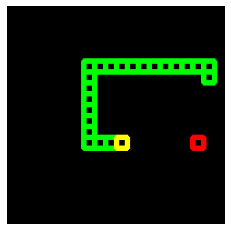

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


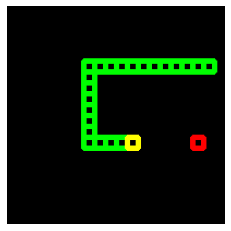

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


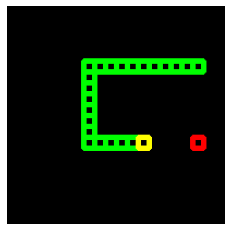

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


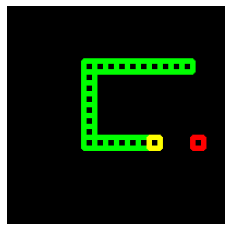

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


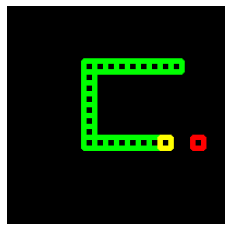

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


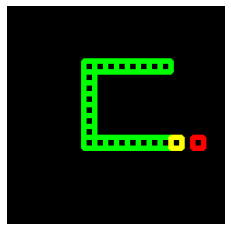

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


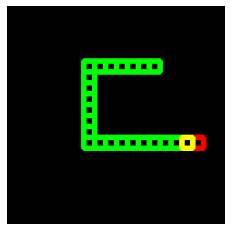

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


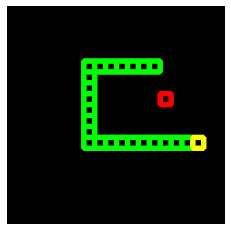

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


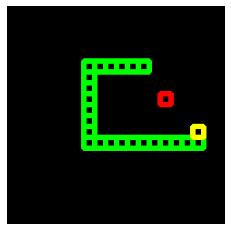

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


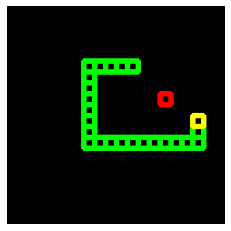

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


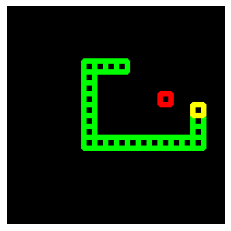

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


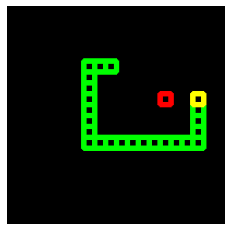

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


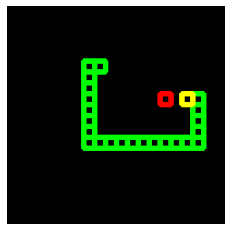

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


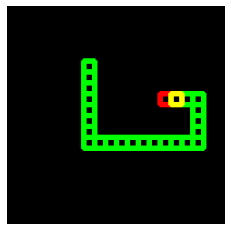

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


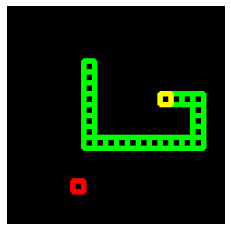

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


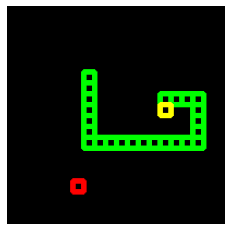

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


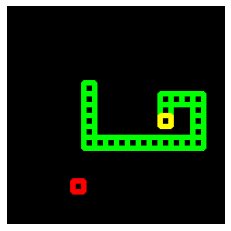

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


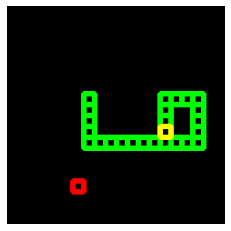

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


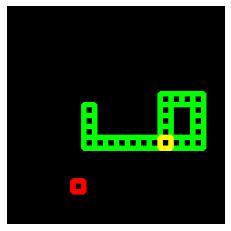

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


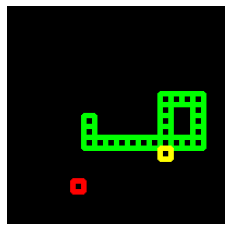

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


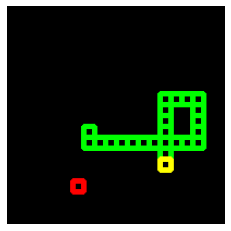

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


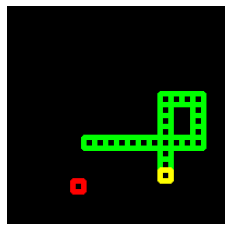

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


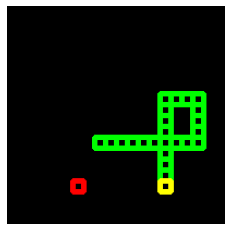

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


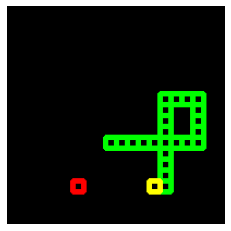

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


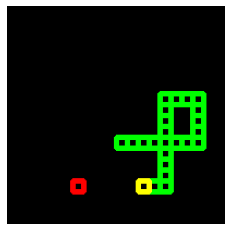

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


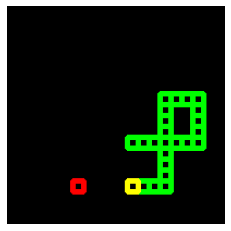

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


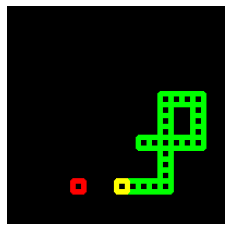

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


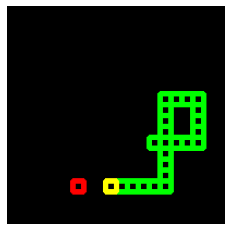

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


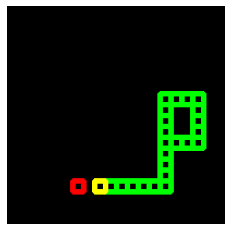

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


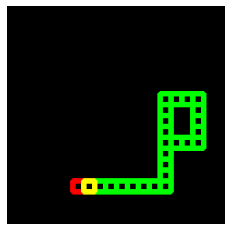

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


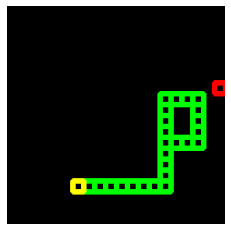

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


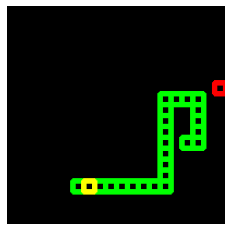

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


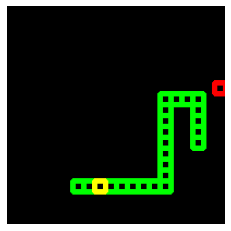

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


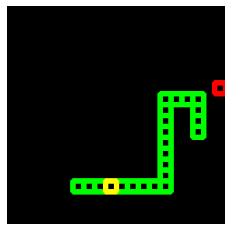

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


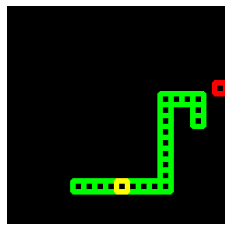

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


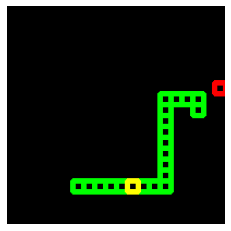

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


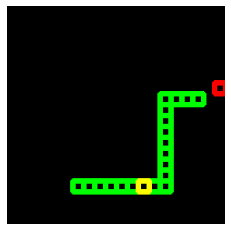

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


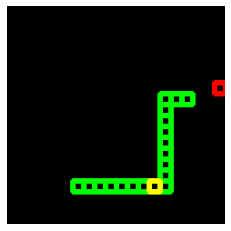

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


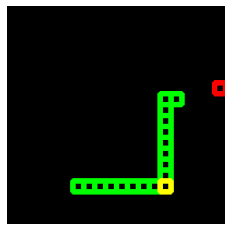

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


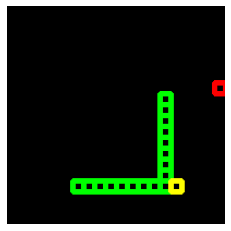

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


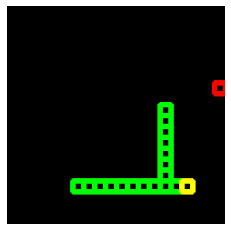

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


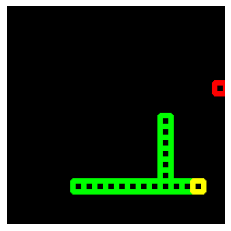

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


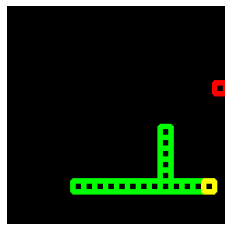

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


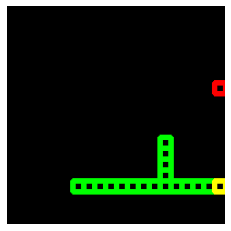

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


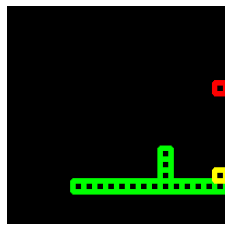

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


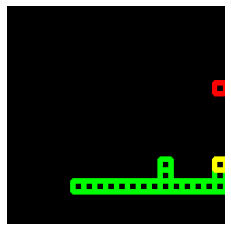

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


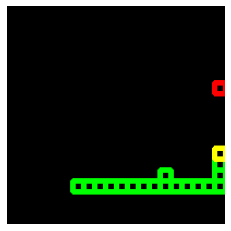

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


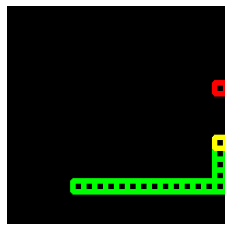

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


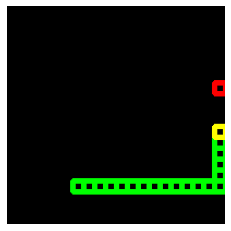

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


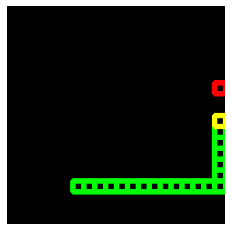

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


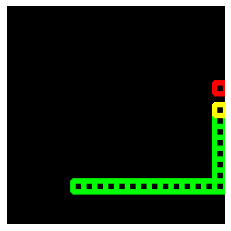

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


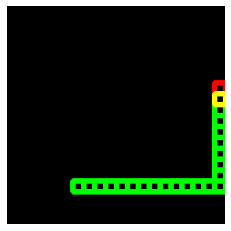

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
Reward received: -1.0

Current state:


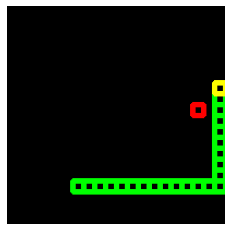

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


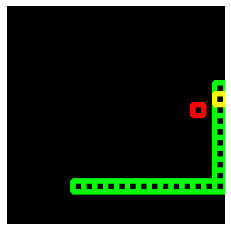

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


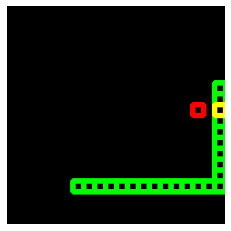

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


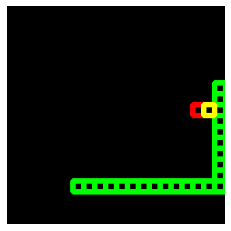

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


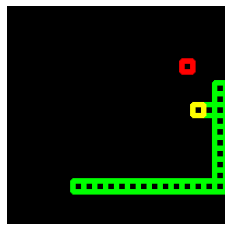

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


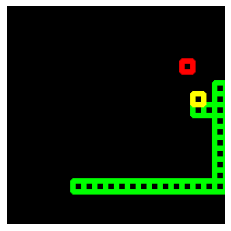

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


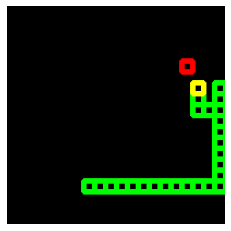

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


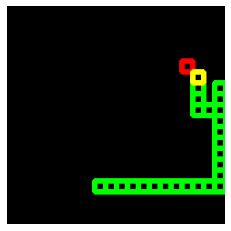

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


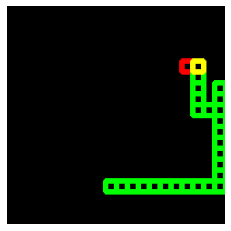

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


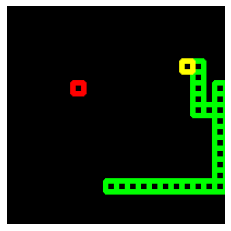

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


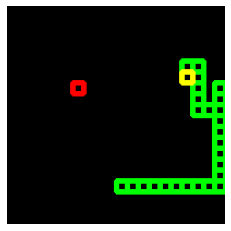

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


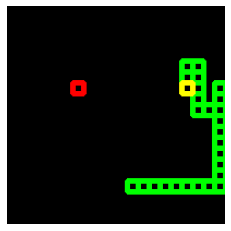

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


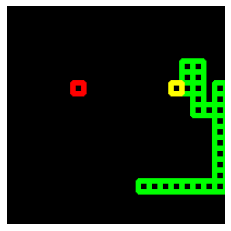

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


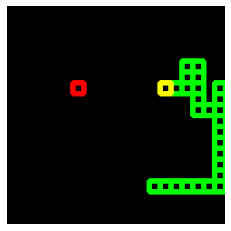

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


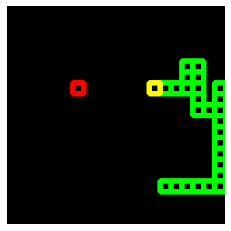

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


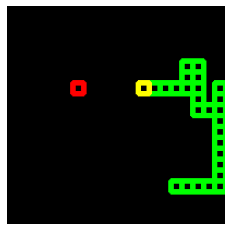

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


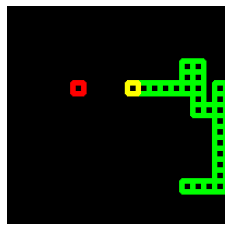

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


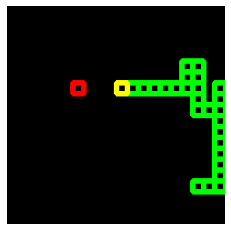

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


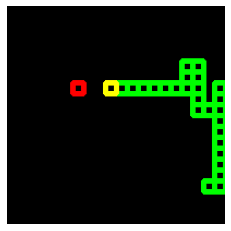

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


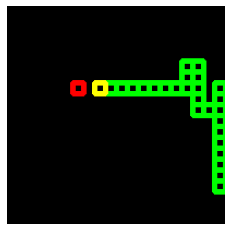

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


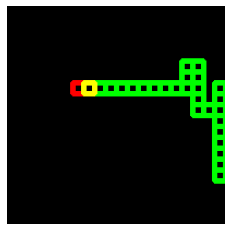

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


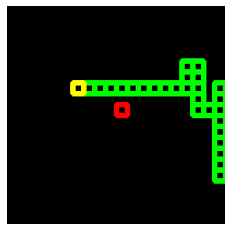

Chosen action: 0 (left)
Reward received: 300


---------- GAME OVER ----------
You lost after eating 27 apples, well done!
Play again?
-------------------------------

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: 300



In [96]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
images = []

env = SnakeEnv(length_goal=30, max_mov = 2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env.reset()
    state = env.reset()
    state = tuple(state)
    while not done:
        action = argmax(q_qlearning[state])
        state, reward, done, info = env.step(action)
        state = tuple(state)
        apple_is_down, apple_is_right = state
        print('Current state:')
        img = env.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'Reward received: {reward}\n')
        
imageio.mimsave('snake_game_QL.gif', images, fps=10)

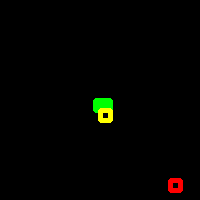

In [97]:
Image(filename="snake_game_QL.gif")

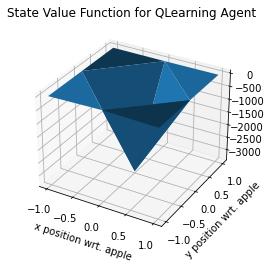

In [98]:
x_list = []
y_list = []
z_list = []
for key in q_qlearning.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_qlearning.values():
    z_list.append(np.mean(value))
    #z_list.append(value[0])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for QLearning Agent")
plt.xlabel("x position wrt. apple")
plt.ylabel("y position wrt. apple")
plt.show()

### 4.1.2 On environment without possible crossing <a class="anchor" id="sub_section_4_1_2"></a>

In [108]:
num_episodes_bound = 40000
size = 20
env_bound = SnakeEnvBound(length_goal=30, max_mov = 2*size, size = size)
agent_init_info_bound = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}

q_qlearning_bound, reward_sums_qlearning_bound = train(QLearningAgent, num_episodes_bound, env_bound, agent_init_info_bound)

advancement: 0.0%
advancement: 5.0%
advancement: 10.0%
advancement: 15.0%
advancement: 20.0%
advancement: 25.0%
advancement: 30.0%
advancement: 35.0%
advancement: 40.0%
advancement: 45.0%
advancement: 50.0%
advancement: 55.0%
advancement: 60.0%
advancement: 65.0%
advancement: 70.0%
advancement: 75.0%
advancement: 80.0%
advancement: 85.0%
advancement: 90.0%
advancement: 95.0%


The mean cumulative reward obtained by the Q-Learning agent: -48.18605



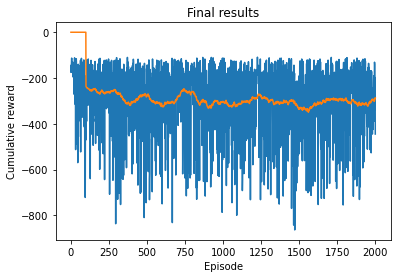

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [109]:
print(f'The mean cumulative reward obtained by the Q-Learning agent: {np.mean(reward_sums_qlearning_bound)}\n')
plot_durations(reward_sums_qlearning, show_result=True)

In [110]:
print(f'Q Table: \n')
sorted_keys = sorted(q_qlearning_bound.keys(), key=lambda k: (k[0], k[1]))
for key in sorted_keys:
    print(key, q_qlearning_bound[key])

Q Table: 

(-1, -1, 0, 0, 0, 0, 0, 0, 0, 0) [-5.000000000000003, -5.000000000000003, -5.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 0, 0, 0, 1) [-5.000000000000003, -7.000000000000003, -104.0, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 0, 0, 1, 0) [-5.000000000000003, -7.000000000000003, -7.000000000000003, -104.0]
(-1, -1, 0, 0, 0, 0, 0, 1, 0, 0) [-5.000000000000003, -104.0, -7.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 1, 0, 0, 0) [-104.0, -7.000000000000003, -7.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 1, 0, 1, 0) [-103.89188530892281, -15.000000000000007, -15.000000000000007, -83.09718100606966]
(-1, -1, 0, 1, 0, 0, 0, 0, 1, 0) [-5.000000000000003, -7.000000119518514, -104.0000000000012, -104.00004698364879]
(-1, -1, 0, 0, 0, 1, 1, 0, 0, 0) [-104.0000000000068, -104.00000000025237, -7.000000000919464, -5.000000000000003]
(-1, -1, 0, 0, 0, 1, 0, 0, 1, 0) [-5.000000000061087, -104.00096157304807, -7.000120479758684, -104.1956732967786]
(-1, 

(1, 0, 0, 0, 0, 0, 1, 1, 1, 1) [-10000, -10000, -8670.0, -10000]
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0) [-5.000000000000003, -5.000000000000003, -5.000000000000003, -5.000000000000003]
(1, 1, 0, 0, 0, 0, 0, 1, 0, 0) [-7.000000000000003, -104.0, -5.000000000000003, -7.000000000000003]
(1, 1, 0, 0, 0, 0, 0, 0, 0, 1) [-7.000000000000003, -5.000000000000003, -104.0, -7.000000000000003]
(1, 1, 0, 0, 0, 0, 1, 0, 0, 0) [-104.0, -5.000000000000003, -5.000000000000003, -7.000000000000003]
(1, 1, 0, 0, 0, 0, 0, 0, 1, 0) [-7.000000000000003, -5.000000000000003, -5.000000000000003, -104.0]
(1, 1, 0, 0, 0, 0, 0, 1, 0, 1) [-15.000000000000007, -21.28242556105932, -111.76579128015491, -15.000000000000007]
(1, 1, 0, 0, 0, 0, 1, 0, 1, 0) [-81.77739407581822, -5.000000000000003, -5.000000000000003, -103.82014212588788]
(1, 1, 0, 0, 0, 0, 1, 0, 0, 1) [-102.10223088711717, -5.000000000000003, -74.87797711446505, -7.000000000000003]
(1, 1, 1, 0, 0, 0, 0, 1, 0, 0) [-7.754056115063558, -115.40976346315247, -5.181450

Current state:


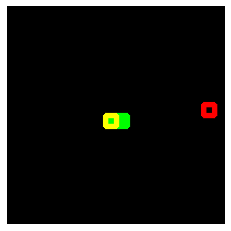

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


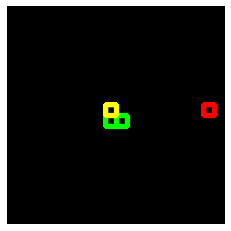

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


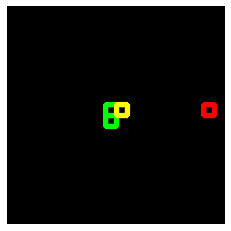

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


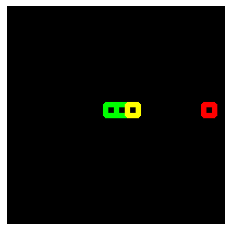

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


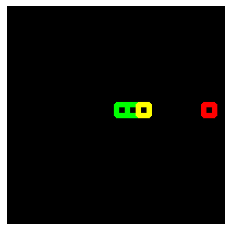

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


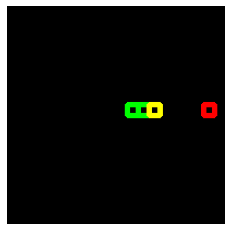

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


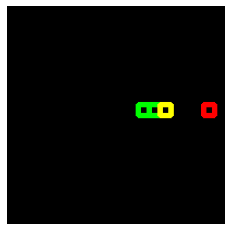

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


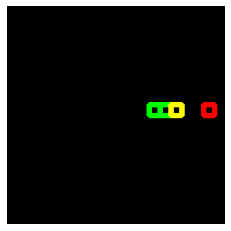

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


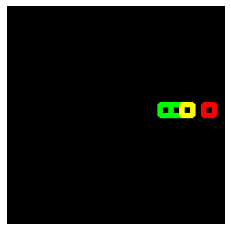

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


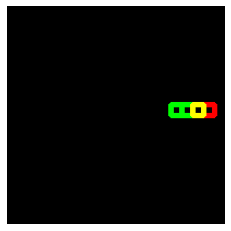

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


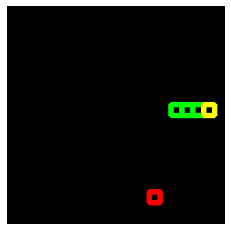

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: 97.0

Current state:


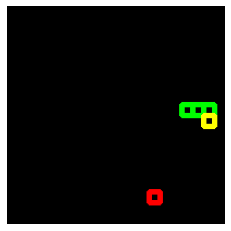

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


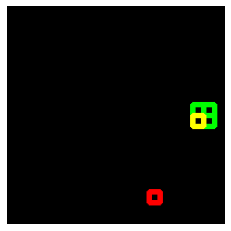

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


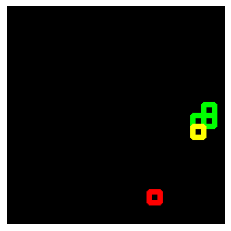

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


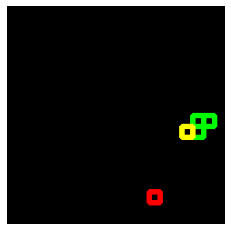

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


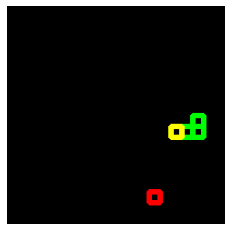

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


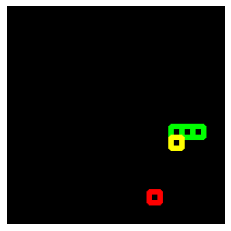

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


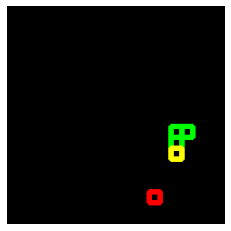

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


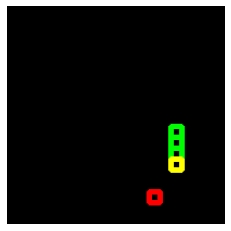

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


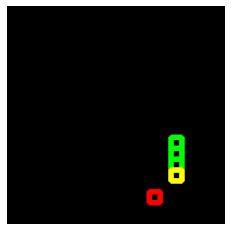

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


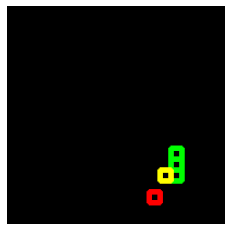

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


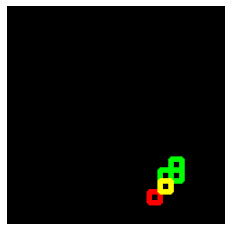

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


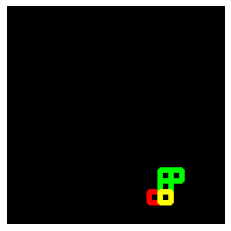

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


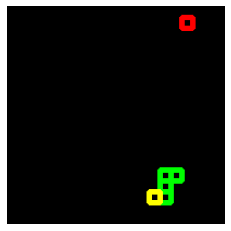

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: 97.0

Current state:


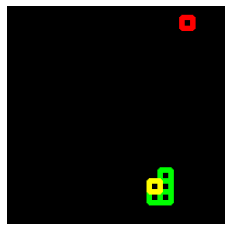

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


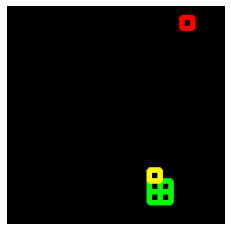

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


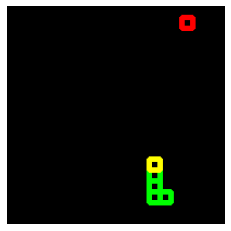

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


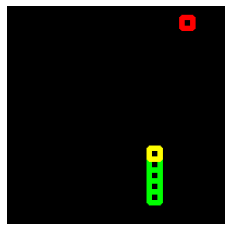

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


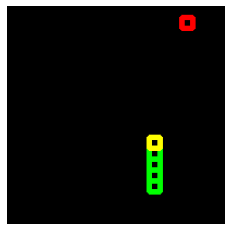

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


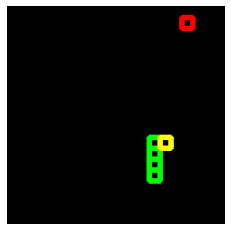

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


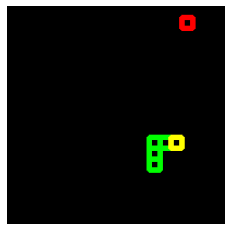

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


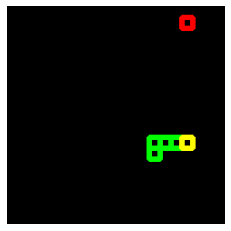

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


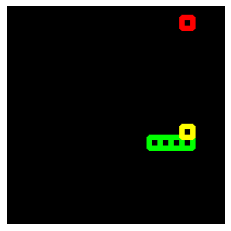

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


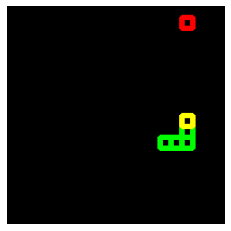

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


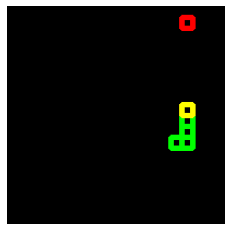

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


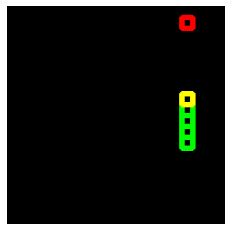

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


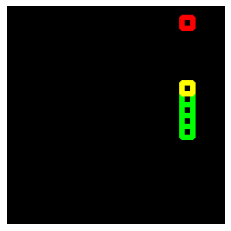

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


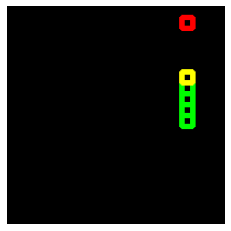

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


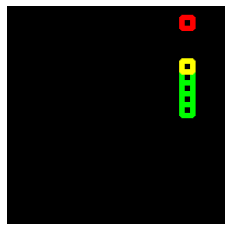

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


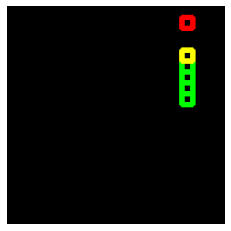

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


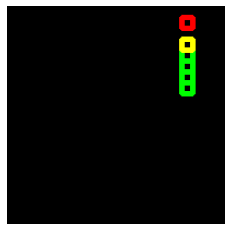

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


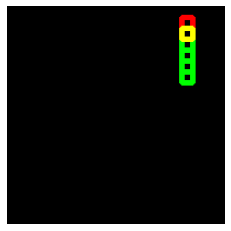

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


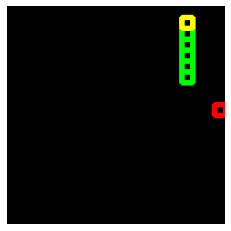

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: 97.0

Current state:


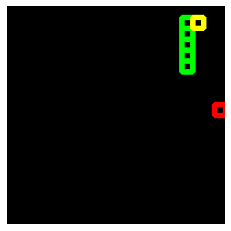

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


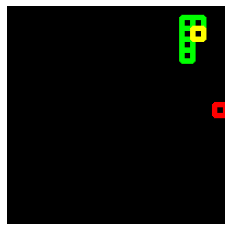

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


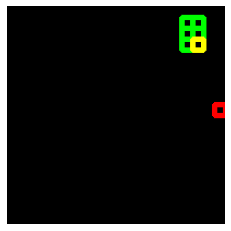

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


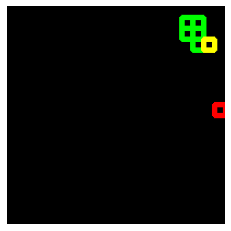

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


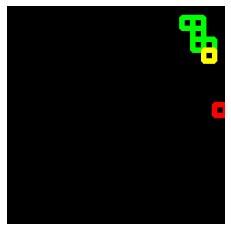

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


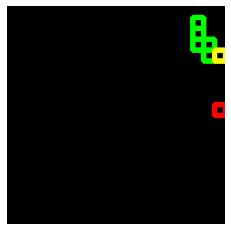

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


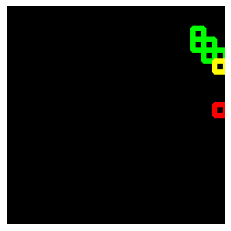

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


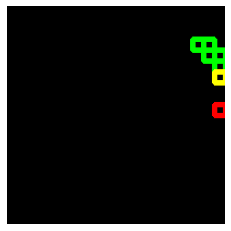

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


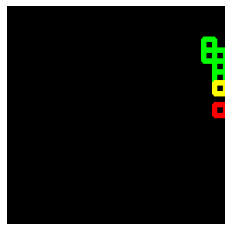

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


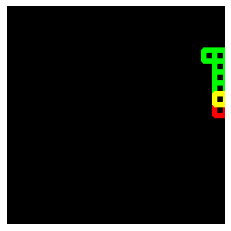

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


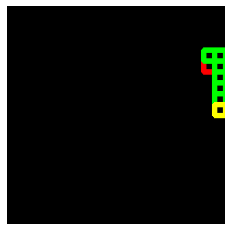

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 1
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: 97.0

Current state:


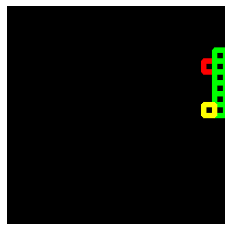

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


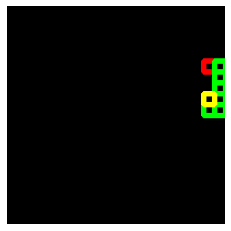

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


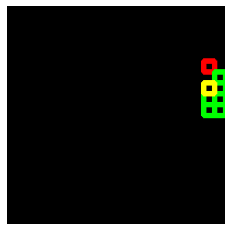

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


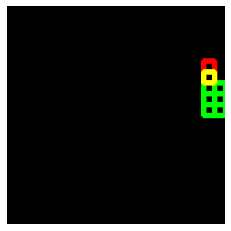

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


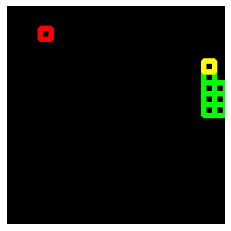

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: 97.0

Current state:


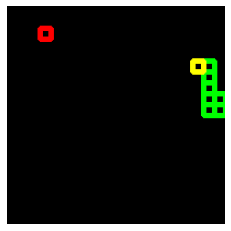

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


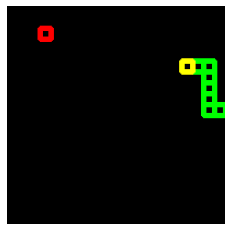

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


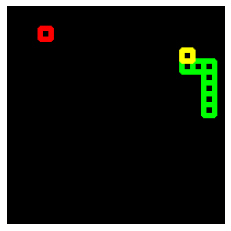

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


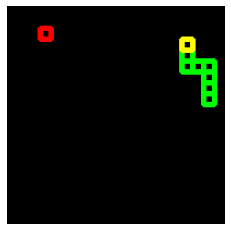

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


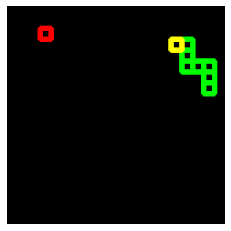

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


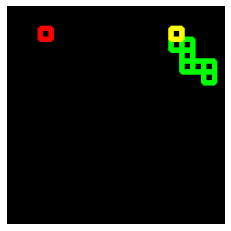

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


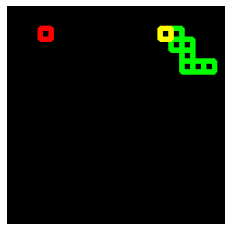

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


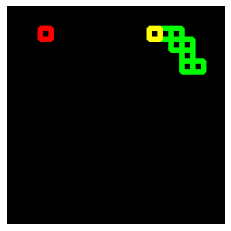

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


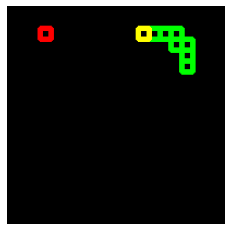

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


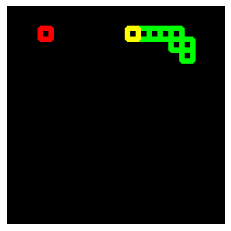

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


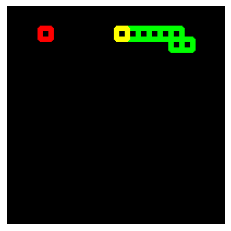

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


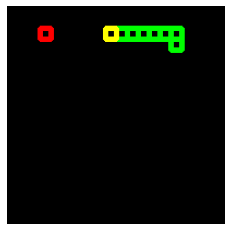

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


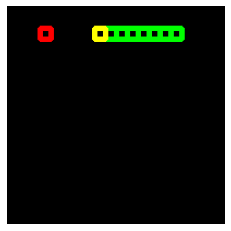

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


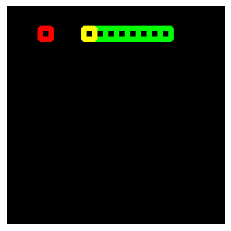

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


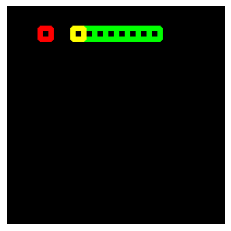

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


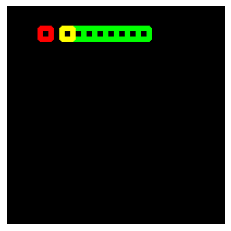

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


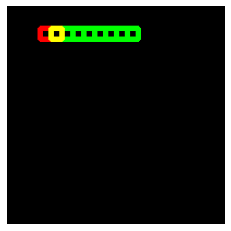

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


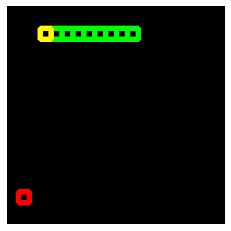

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: 97.0

Current state:


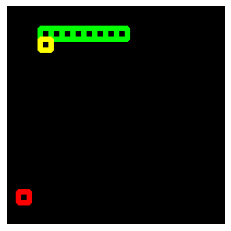

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


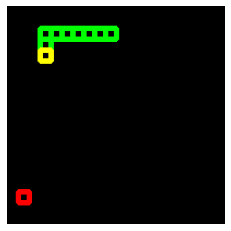

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


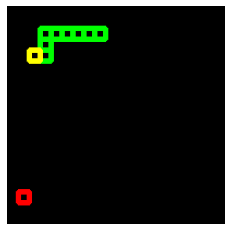

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


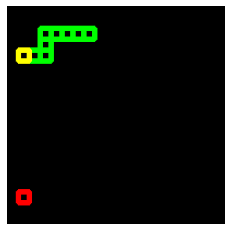

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


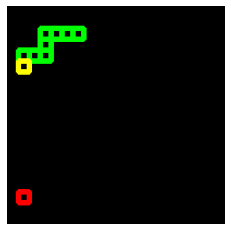

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


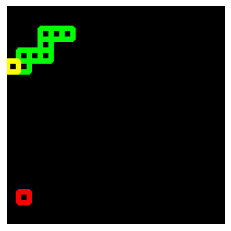

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 1
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -3.0

Current state:


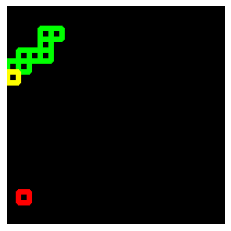

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 1
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


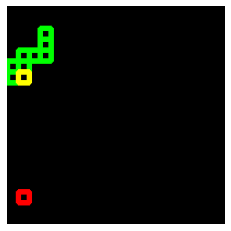

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


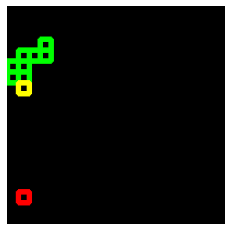

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


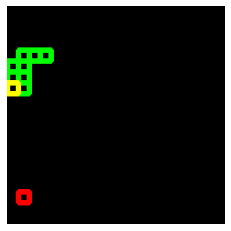

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 1
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 1
snake_at_down: 0
Reward received: -3.0

Current state:


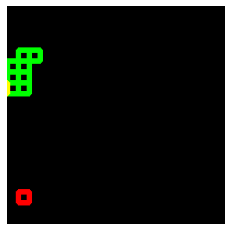

Chosen action: 0 (left)
Reward received: -100


---------- GAME OVER ----------
You lost after eating 6 apples, well done!
Play again?
-------------------------------

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -100



In [113]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
images = []

env_bound = SnakeEnvBound(length_goal=30, max_mov = 2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env_bound.reset()
    state = env_bound.reset()
    state = tuple(state)
    while not done:
        if state not in q_qlearning_bound.keys():
            q_qlearning_bound[state] = [-10000,-10000,-10000,-10000]
        action = argmax(q_qlearning_bound[state])
        state, reward, done, info = env_bound.step(action)
        state = tuple(state)
        apple_is_down, apple_is_right, is_snake_bound_up, is_snake_bound_down, is_snake_bound_left, is_snake_bound_right, snake_at_left, snake_at_right, snake_at_up, snake_at_down = state
        print('Current state:')
        img = env_bound.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'is_snake_bound_up: {is_snake_bound_up}')
        print(f'is_snake_bound_down: {is_snake_bound_down}')
        print(f'is_snake_bound_left: {is_snake_bound_left}')
        print(f'is_snake_bound_right: {is_snake_bound_right}')
        print(f'snake_at_left: {snake_at_left}')
        print(f'snake_at_right: {snake_at_right}')
        print(f'snake_at_up: {snake_at_up}')
        print(f'snake_at_down: {snake_at_down}')
        print(f'Reward received: {reward}\n')
        
imageio.mimsave('snake_game_QL_bound.gif', images, fps=10)

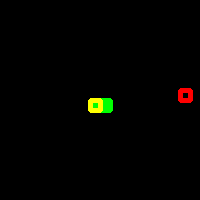

In [114]:
Image(filename="snake_game_QL_bound.gif")

In [ ]:
x_list = []
y_list = []
z_list = []
for key in q_qlearning_bound.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_qlearning_bound.values():
    z_list.append(np.mean(value))
    #z_list.append(value[0])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for QLearning Agent")
plt.xlabel("x position wrt. apple")
plt.ylabel("y position wrt. apple")
plt.show()

## 4.2 Expected Sarsa <a class="anchor" id="section_4_2"></a>

In [63]:
class ExpectedSarsaAgent():
    """
    Second Agent: Expected Sarsa agent
    """    
    
    def __init__(self, agent_init_info):
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
    
    def act(self, q, state):
        """
        epsilon-greedy policy
        """
        if state not in list(q.keys()):
            q[state] = [-10000,-10000,-10000,-10000]
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = argmax(q[state])
        return current_action
        
    def update(self, q, state, action, next_state, next_action, reward):
        current_q = q[state][action]
        if next_state not in list(q.keys()):
            q[next_state] = [-10000,-10000,-10000,-10000]
        next_q = q[next_state][next_action]
        q[state][action] = current_q + self.step_size * (reward + self.discount * next_q - current_q)

### 4.2.1 On environment with possible crossing <a class="anchor" id="sub_section_4_2_1"></a>

In [99]:
num_episodes_es = 4000
size = 20
env = SnakeEnv(length_goal=30, max_mov = 2*size, size=size)
agent_init_info_es = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}

q_es, reward_sums_es = train(ExpectedSarsaAgent, num_episodes_es, env, agent_init_info_es)

advancement: 0.0%
advancement: 5.0%
advancement: 10.0%
advancement: 15.0%
advancement: 20.0%
advancement: 25.0%
advancement: 30.0%
advancement: 35.0%
advancement: 40.0%
advancement: 45.0%
advancement: 50.0%
advancement: 55.0%
advancement: 60.0%
advancement: 65.0%
advancement: 70.0%
advancement: 75.0%
advancement: 80.0%
advancement: 85.0%
advancement: 90.0%
advancement: 95.0%


The mean cumulative reward obtained by the Expected Sarsa agent: -169.74625



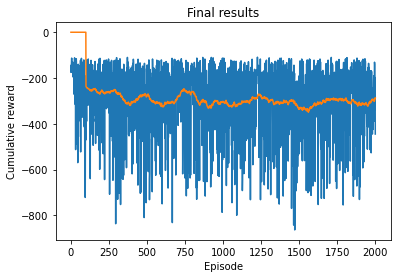

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [100]:
print(f'The mean cumulative reward obtained by the Expected Sarsa agent: {np.mean(reward_sums_es)}\n')
plot_durations(reward_sums_qlearning, show_result=True)

In [101]:
print(f'Q Table: \n')
sorted_keys = sorted(q_es.keys(), key=lambda k: (k[0], k[1]))
for key in sorted_keys:
    print(key, q_es[key])

Q Table: 

(-1, -1) [-51.537950165554, -84.04256538948111, -94.80353976525514, -28.133108665929456]
(-1, 0) [-22.497785834028537, -28.669836089247816, -32.83050317918483, -12.633001235208937]
(-1, 1) [-35.82285420825668, -78.19616557622555, -31.061210706394483, -10.212774792417079]
(0, -1) [-19.381935504433706, -36.08346589400573, -41.22299201734687, -52.52413773375231]
(0, 0) [-31.525933481696462, -3008.971722172063, -3053.0674356531745, -10000]
(0, 1) [-83.56250952915765, -18.525536259002273, -11.539707323920618, -18.978184006864254]
(1, -1) [-25.364631096645113, -85.84733887051249, -20.44428663994104, -82.8724064751792]
(1, 0) [-130.87350258699314, -82.96708445428314, -38.357768249444746, -20.644400466910263]
(1, 1) [-17.427902253264662, -18.484547361764985, -13.899368978312571, -16.693190089875515]


Current state:


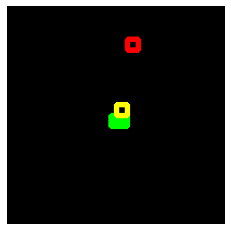

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


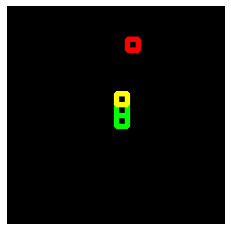

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


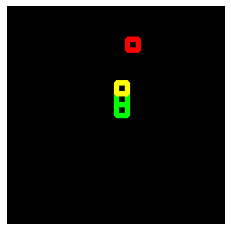

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


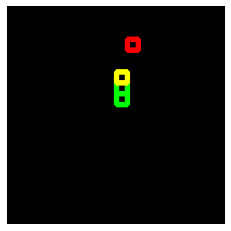

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


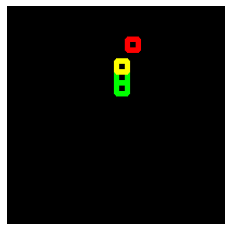

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


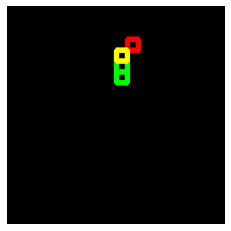

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


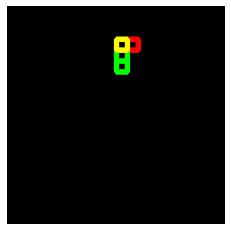

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


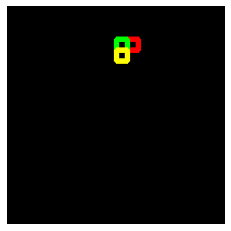

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


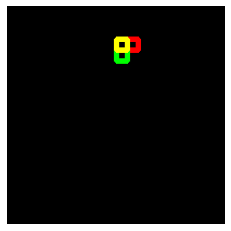

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


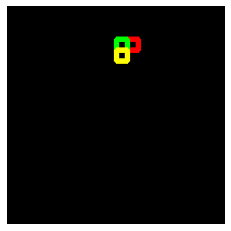

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


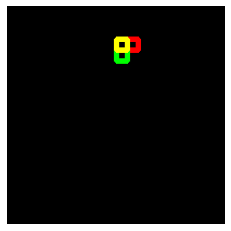

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


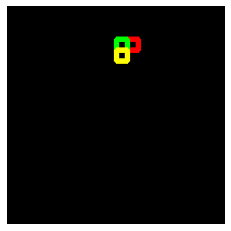

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


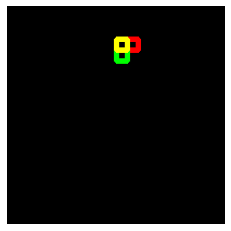

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


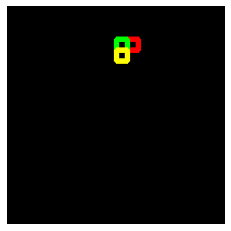

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


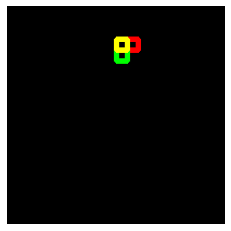

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


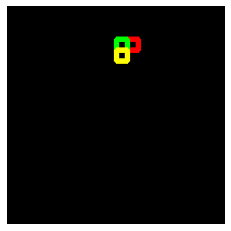

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


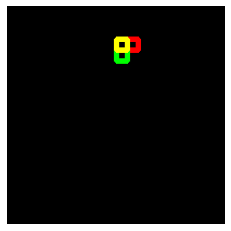

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


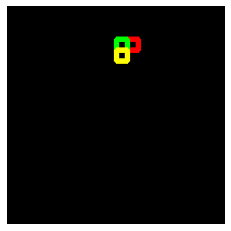

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


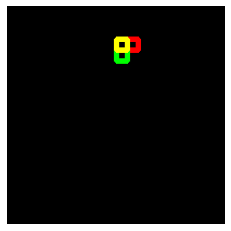

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


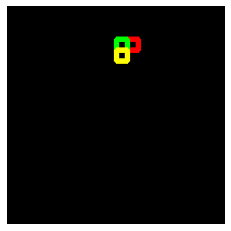

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


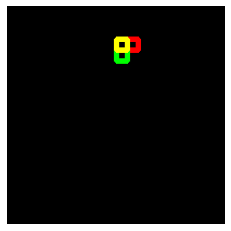

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


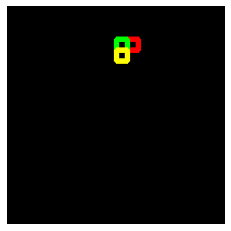

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


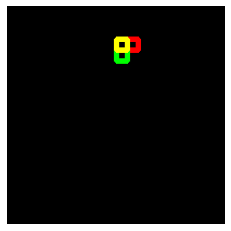

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


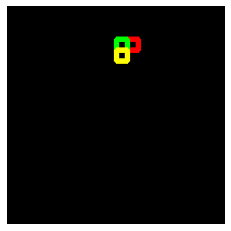

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


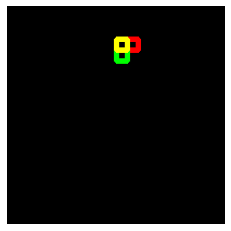

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


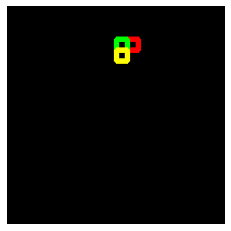

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


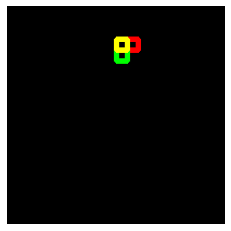

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


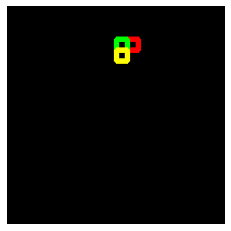

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


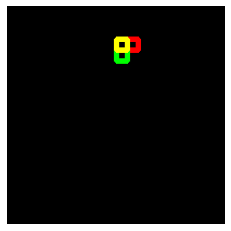

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


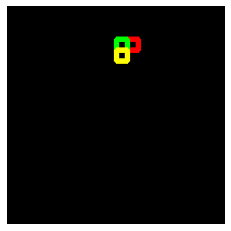

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


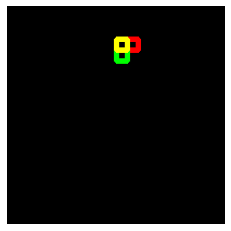

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


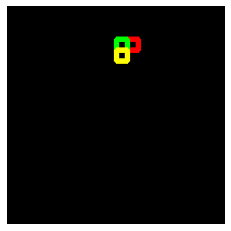

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


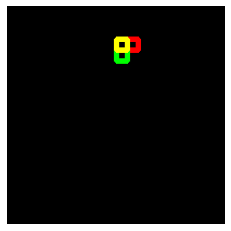

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


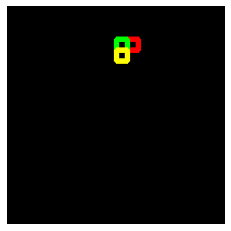

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


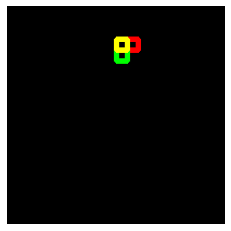

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


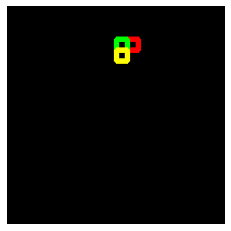

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


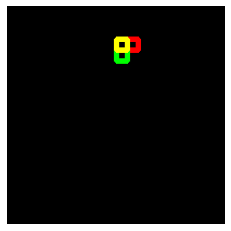

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


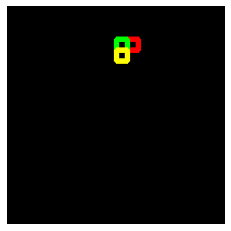

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


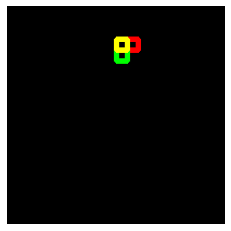

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


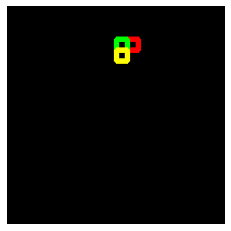

Chosen action: 2 (down)
Reward received: -100


---------- GAME OVER ----------
You lost after eating 0 apples, well done!
Play again?
-------------------------------

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -100



In [102]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
images = []

env = SnakeEnv(length_goal=30, max_mov = 2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env.reset()
    state = env.reset()
    state = tuple(state)
    while not done:
        action = argmax(q_es[state])
        state, reward, done, info = env.step(action)
        state = tuple(state)
        apple_is_down, apple_is_right = state
        print('Current state:')
        img = env.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'Reward received: {reward}\n')
        
imageio.mimsave('snake_game_ES.gif', images, fps=10)

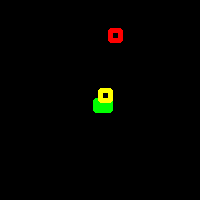

In [103]:
Image(filename="snake_game_ES.gif")

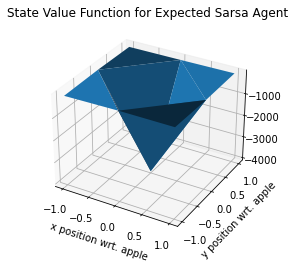

In [104]:
x_list = []
y_list = []
z_list = []
for key in q_es.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_es.values():
    z_list.append(np.mean(value))
    #z_list.append(value[0])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for Expected Sarsa Agent")
plt.xlabel("x position wrt. apple")
plt.ylabel("y position wrt. apple")
plt.show()

### 4.2.2 On environment without possible crossing <a class="anchor" id="sub_section_4_2_2"></a>

In [124]:
num_episodes_es_bound = 40000
size = 20
env_bound = SnakeEnvBound(length_goal=30, max_mov = 2*size, size = size)
agent_init_info_es_bound = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}

q_es_bound, reward_sums_es_bound = train(QLearningAgent, num_episodes_es_bound, env_bound, agent_init_info_es_bound)

advancement: 0.0%
advancement: 5.0%
advancement: 10.0%
advancement: 15.0%
advancement: 20.0%
advancement: 25.0%
advancement: 30.0%
advancement: 35.0%
advancement: 40.0%
advancement: 45.0%
advancement: 50.0%
advancement: 55.0%
advancement: 60.0%
advancement: 65.0%
advancement: 70.0%
advancement: 75.0%
advancement: 80.0%
advancement: 85.0%
advancement: 90.0%
advancement: 95.0%


The mean cumulative reward obtained by the Expected Sarsa agent: -47.4129



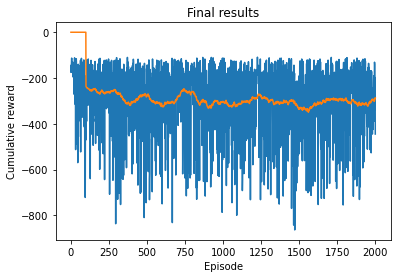

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [125]:
print(f'The mean cumulative reward obtained by the Expected Sarsa agent: {np.mean(reward_sums_es_bound)}\n')
plot_durations(reward_sums_qlearning, show_result=True)

In [126]:
print(f'Q Table: \n')
sorted_keys = sorted(q_es_bound.keys(), key=lambda k: (k[0], k[1]))
for key in sorted_keys:
    print(key, q_es_bound[key])

Q Table: 

(-1, -1, 0, 0, 0, 0, 0, 0, 0, 0) [-5.000000000000003, -5.000000000000003, -5.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 0, 0, 0, 1) [-5.000000000000003, -7.000000000000003, -104.0, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 1, 0, 0, 0) [-104.0, -7.000000000000003, -7.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 0, 0, 1, 0) [-5.000000000000003, -7.000000000000003, -7.000000000000003, -104.0]
(-1, -1, 0, 0, 0, 0, 0, 1, 0, 0) [-5.000000000000003, -104.0, -7.000000000000003, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 0, 1, 1, 0) [-5.000000000000003, -83.0785499929277, -7.000000000000003, -13.348632174105852]
(-1, -1, 0, 1, 0, 0, 0, 0, 1, 0) [-5.000000000000003, -7.000000000148801, -104.00000000008045, -104.00000000028103]
(-1, -1, 0, 1, 0, 0, 0, 1, 0, 0) [-5.0000019682308805, -104.00000000000001, -104.00001496273342, -5.000000000000003]
(-1, -1, 0, 0, 0, 0, 1, 0, 1, 0) [-21.839650244176266, -15.000000000000007, -15.000000000000007, -105.18060216101784]
(-

Current state:


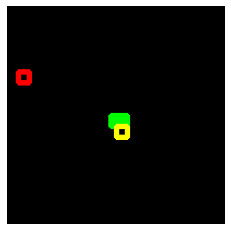

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


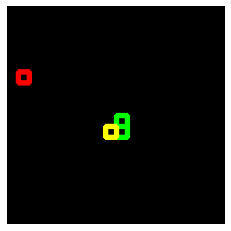

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


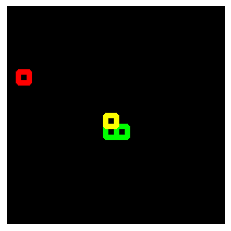

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


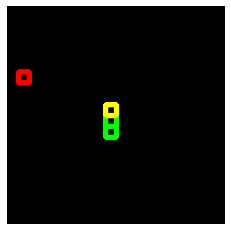

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


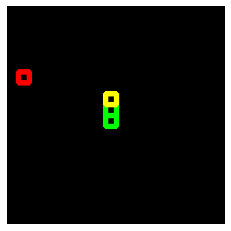

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


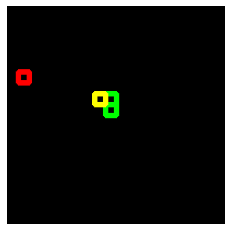

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


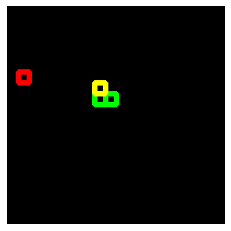

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


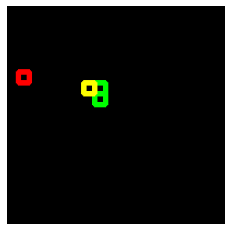

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


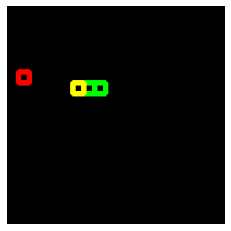

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


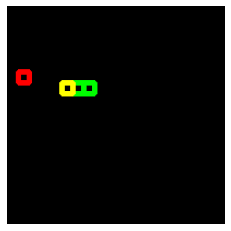

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


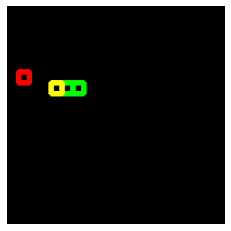

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


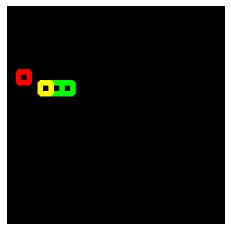

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


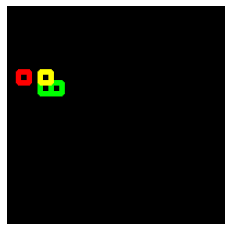

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


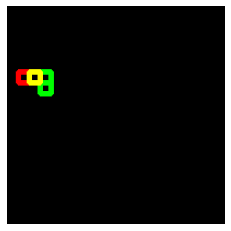

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


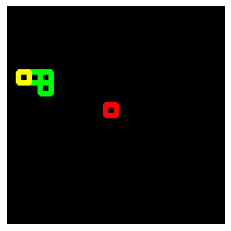

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: 97.0

Current state:


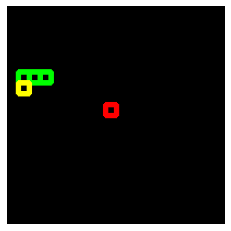

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


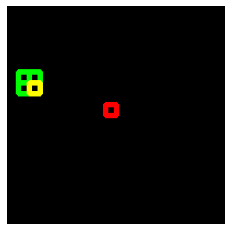

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


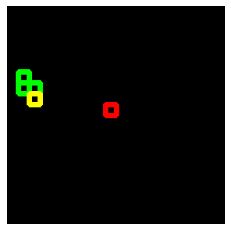

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


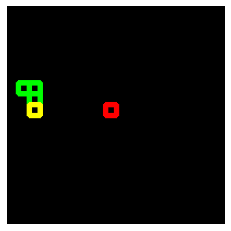

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


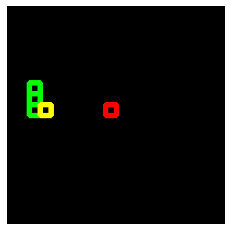

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


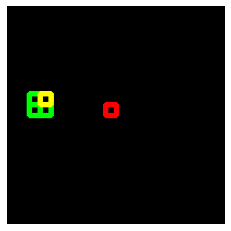

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -3.0

Current state:


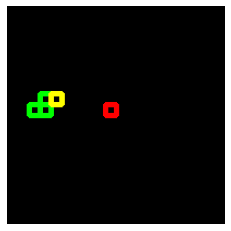

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


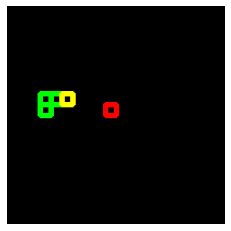

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


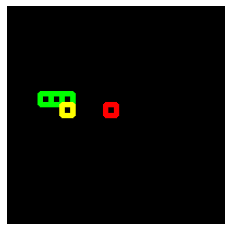

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


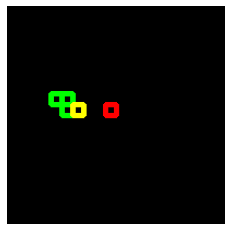

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


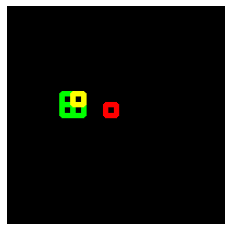

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -3.0

Current state:


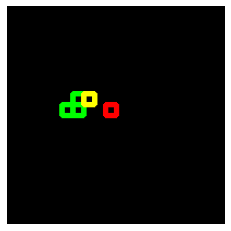

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


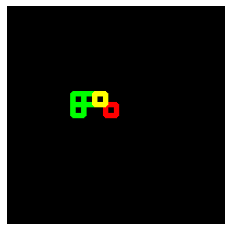

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


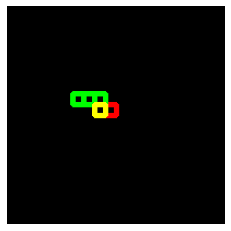

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


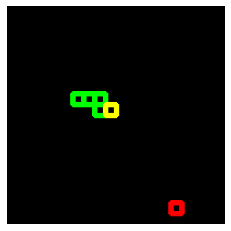

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: 97.0

Current state:


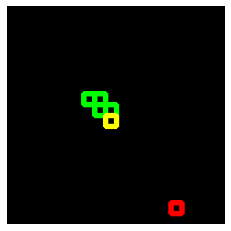

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


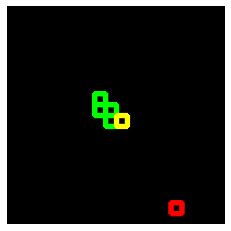

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


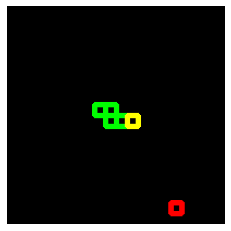

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


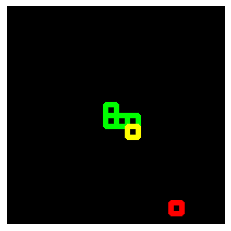

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


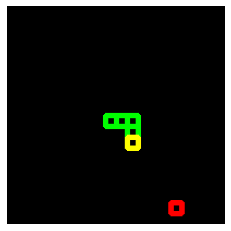

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


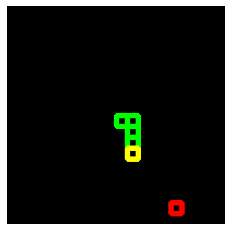

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


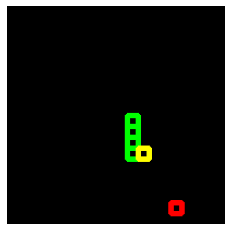

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


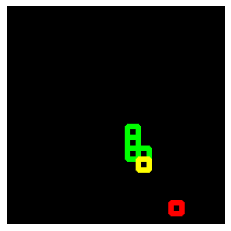

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


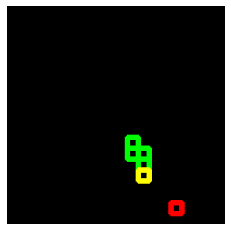

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


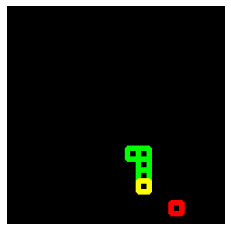

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


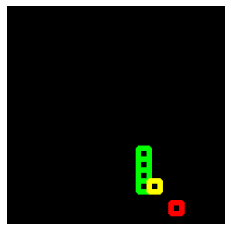

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


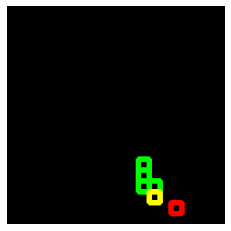

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


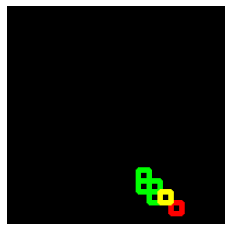

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


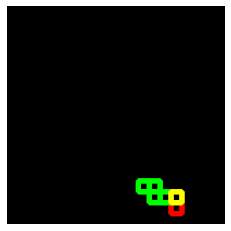

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


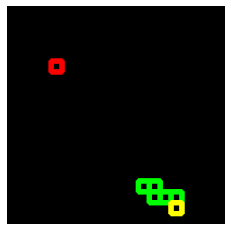

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: 97.0

Current state:


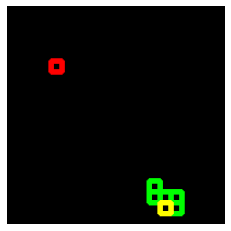

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


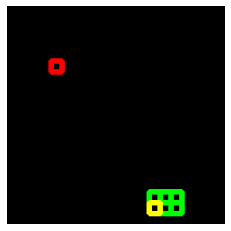

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


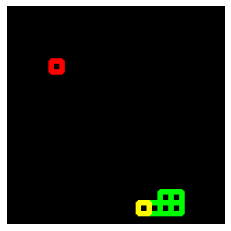

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


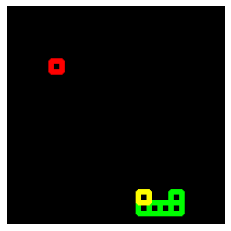

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


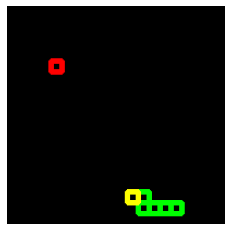

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


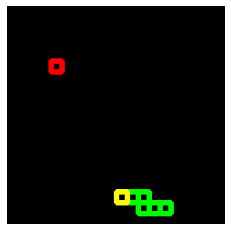

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


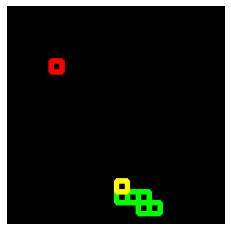

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


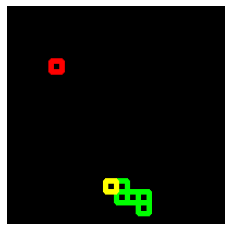

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


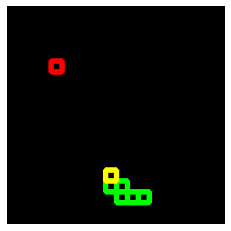

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


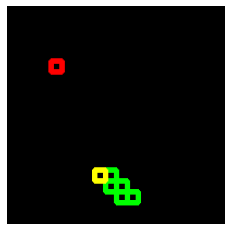

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


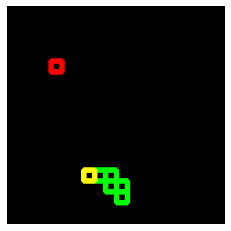

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


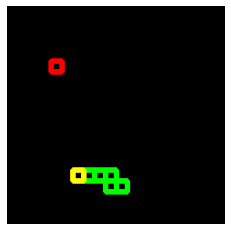

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


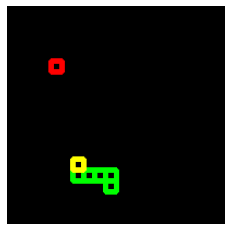

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


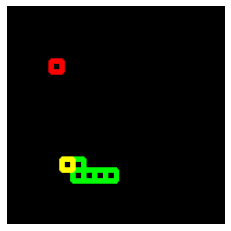

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


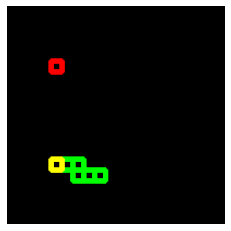

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


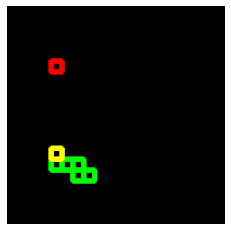

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


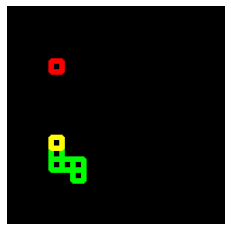

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


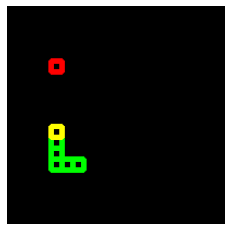

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


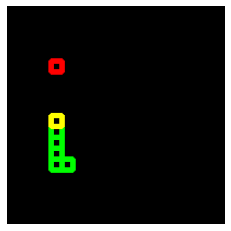

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


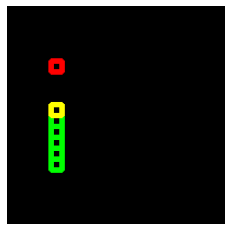

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


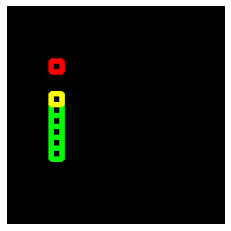

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


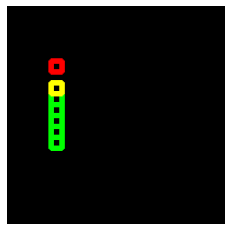

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


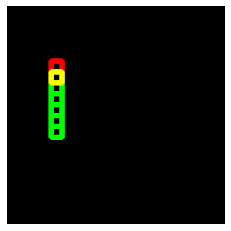

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


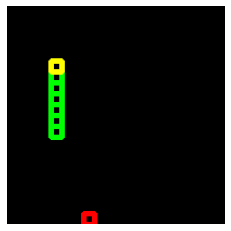

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: 97.0

Current state:


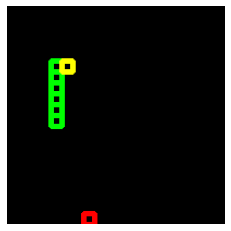

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


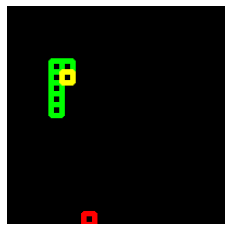

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


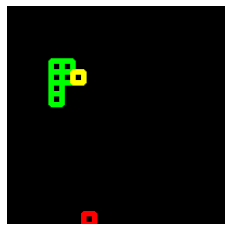

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


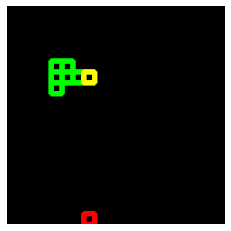

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


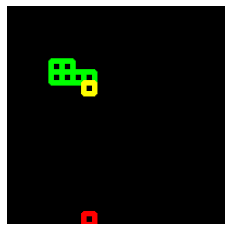

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


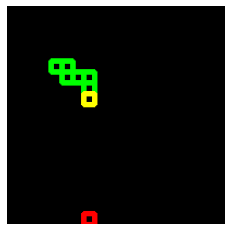

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


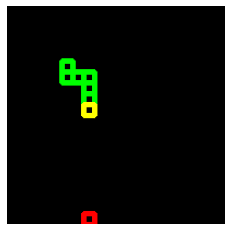

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


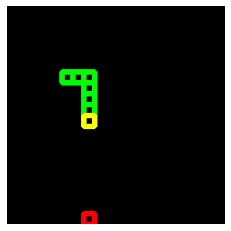

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


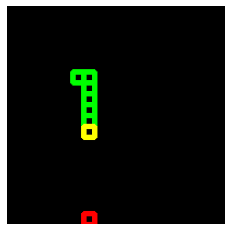

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


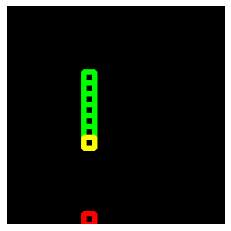

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


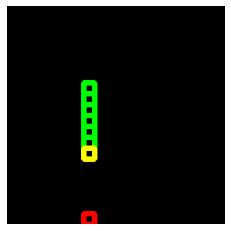

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


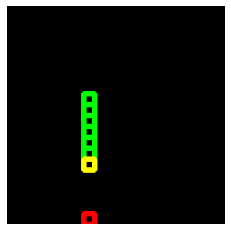

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


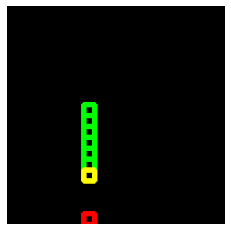

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


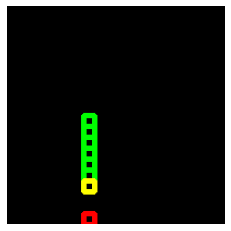

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


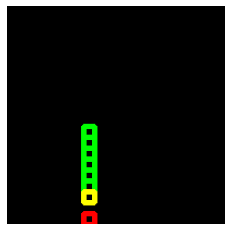

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


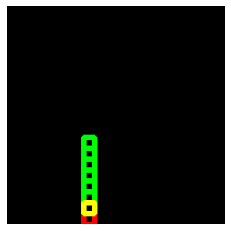

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


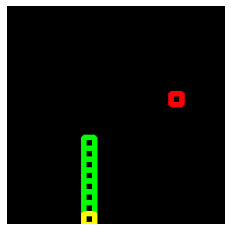

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: 97.0

Current state:


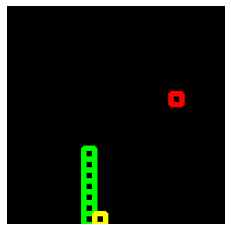

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


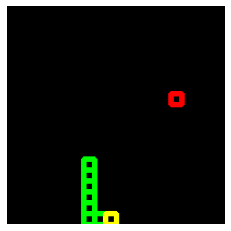

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


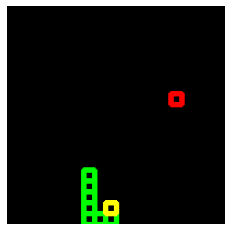

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


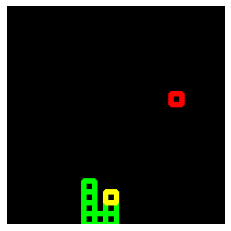

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


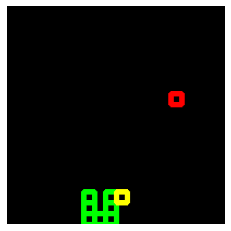

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


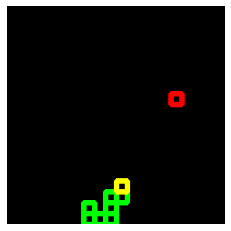

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


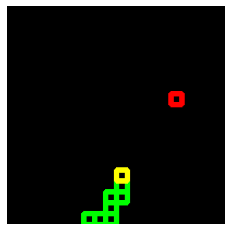

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


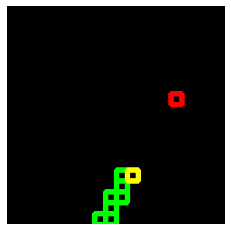

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


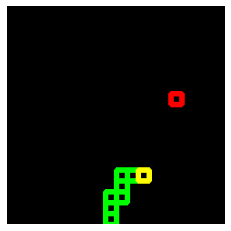

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


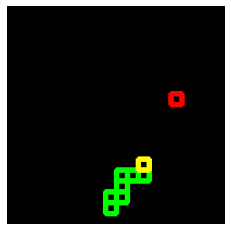

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


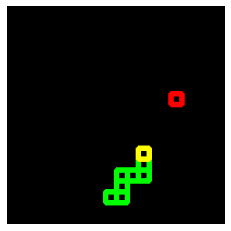

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


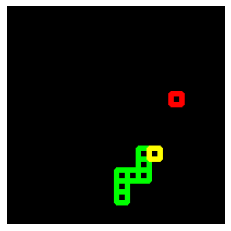

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


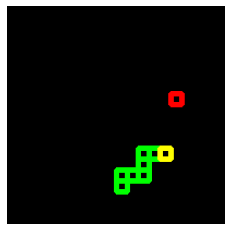

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


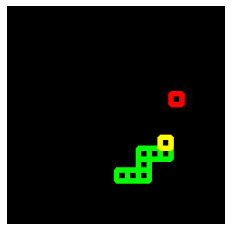

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


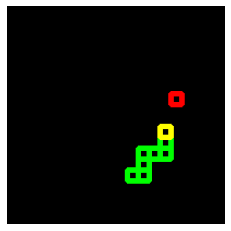

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


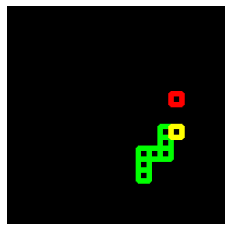

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


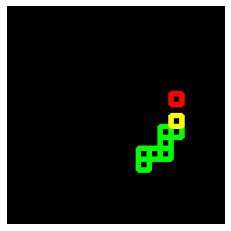

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


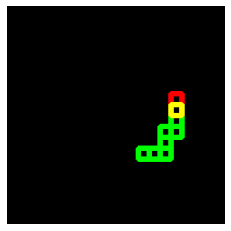

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: -1.0

Current state:


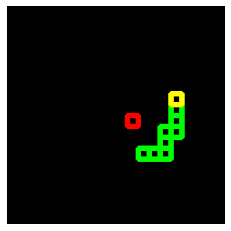

Chosen action: 3 (up)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 0
snake_at_down: 1
Reward received: 97.0

Current state:


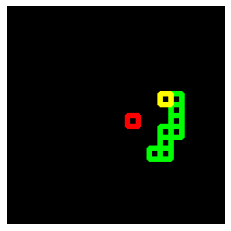

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


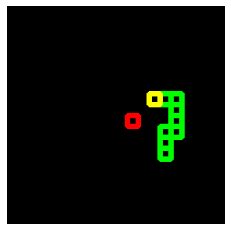

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


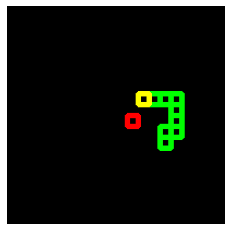

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


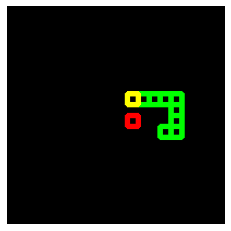

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 1
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


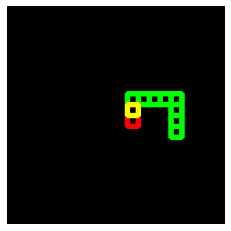

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: -1.0

Current state:


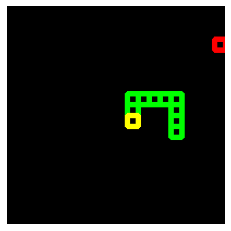

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 0
snake_at_right: 0
snake_at_up: 1
snake_at_down: 0
Reward received: 97.0

Current state:


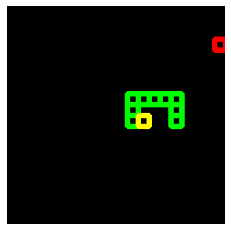

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 0
snake_at_down: 0
Reward received: -1.0

Current state:


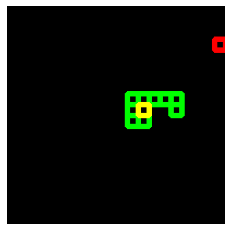

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 0
snake_at_up: 1
snake_at_down: 1
Reward received: -1.0

Current state:


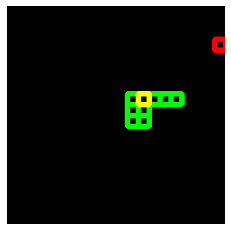

Chosen action: 3 (up)
Reward received: -100


---------- GAME OVER ----------
You lost after eating 7 apples, well done!
Play again?
-------------------------------

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
snake_at_left: 1
snake_at_right: 1
snake_at_up: 0
snake_at_down: 1
Reward received: -100



In [128]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
images = []

env_bound = SnakeEnvBound(length_goal=30, max_mov = 2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env_bound.reset()
    state = env_bound.reset()
    state = tuple(state)
    while not done:
        if state not in q_es_bound.keys():
            q_es_bound[state] = [-10000,-10000,-10000,-10000]
        action = argmax(q_es_bound[state])
        state, reward, done, info = env_bound.step(action)
        state = tuple(state)
        apple_is_down, apple_is_right, is_snake_bound_up, is_snake_bound_down, is_snake_bound_left, is_snake_bound_right, snake_at_left, snake_at_right, snake_at_up, snake_at_down = state
        print('Current state:')
        img = env_bound.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'is_snake_bound_up: {is_snake_bound_up}')
        print(f'is_snake_bound_down: {is_snake_bound_down}')
        print(f'is_snake_bound_left: {is_snake_bound_left}')
        print(f'is_snake_bound_right: {is_snake_bound_right}')
        print(f'snake_at_left: {snake_at_left}')
        print(f'snake_at_right: {snake_at_right}')
        print(f'snake_at_up: {snake_at_up}')
        print(f'snake_at_down: {snake_at_down}')
        print(f'Reward received: {reward}\n')
        
imageio.mimsave('snake_game_ES_bound.gif', images, fps=10)

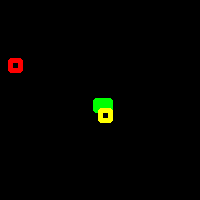

In [129]:
Image(filename="snake_game_ES_bound.gif")

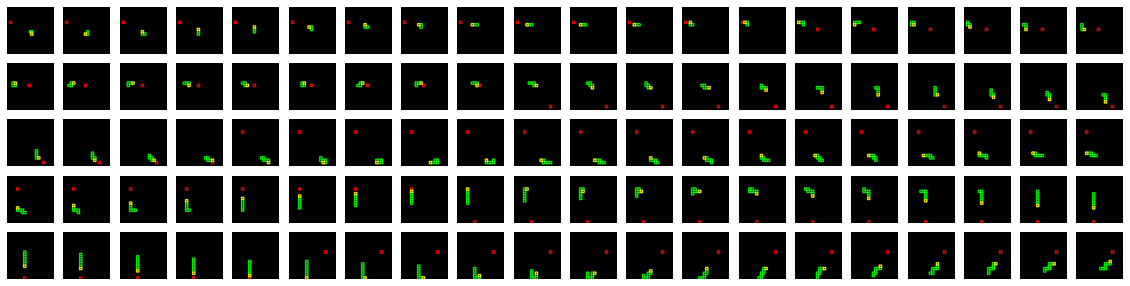

In [136]:
#print the history
plt.figure(figsize=(20,5))
for i in range (100):   
    img = images[i]
    plt.subplot(5,20,i+1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
plt.show()

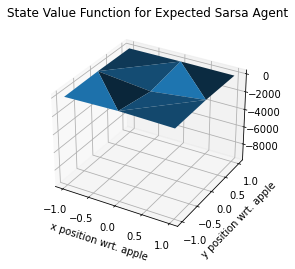

In [130]:
x_list = []
y_list = []
z_list = []
for key in q_es_bound.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_es_bound.values():
    z_list.append(np.mean(value))
    #z_list.append(value[0])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for Expected Sarsa Agent")
plt.xlabel("x position wrt. apple")
plt.ylabel("y position wrt. apple")
plt.show()

## 4.3 Deep Q-Network <a class="anchor" id="section_4_3"></a>

In [115]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [116]:
class DQNAgent():

    def __init__(self, action_size, observation_space, device, ckpt_path=None, gamma=0.9, epsilon=0.1, epsilon_min=0.01, epsilon_decay=0.99999, lr=1e-4):
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.device = device
        self.lr = lr
        self.memory = deque(maxlen=10000)
        self.model = DQN(observation_space, action_size).to(device)
        if ckpt_path is not None:
            self.model.load_state_dict(torch.load(ckpt_path))
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, amsgrad=True)
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        
    def act(self, state):
        explore = np.random.rand()
        if explore <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model(state)
        return torch.argmax(q_values[0]).item()

    def act_greedily(self, state):
        q_values = self.model(state)
        return torch.argmax(q_values[0]).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)

        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(tuple(map(lambda s: s[3] is not None, batch)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s[3] for s in batch if s[3] is not None])
        state_batch = torch.cat([s[0] for s in batch])
        action_batch = torch.tensor([s[1] for s in batch], device=self.device)
        reward_batch = torch.tensor([s[2] for s in batch], device=self.device)

        q_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))
        next_state_values = torch.zeros(len(batch), device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_q_values = (next_state_values * self.gamma) + reward_batch
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### 4.3.1 On environment with possible crossing <a class="anchor" id="sub_section_4_3_1"></a>

In [117]:
# Get number of actions and state observations from snake environment
size = 20
env = SnakeEnv(length_goal=30, max_mov=2*size, size=size)
action_size = env.action_space.n
state = env.reset()
n_observations = len(state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_dqn = DQNAgent(action_size, n_observations, device)

batch_size = 128
num_episodes = 500
scores_list = []
intermediate_ckpt = False

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False

    while not done:
        action = agent_dqn.act(state)
        next_state, reward, done, info = env.step(action)
        
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
        agent_dqn.remember(state, action, reward, next_state)
        state = next_state
        
        if done:
            scores_list.append(info['cumul_reward'])
            plot_durations(scores_list)
            break

        agent_dqn.replay(batch_size)

        if ((episode+1)%500 == 0) and intermediate_ckpt:
            print(f"Episode: {(episode+1)}/{num_episodes}, score: {info['cumul_reward']}")
            torch.save(agent_dqn.model.state_dict(), f'checkpoint_{(episode+1)}.pth')

<Figure size 432x288 with 0 Axes>

The mean cumulative reward obtained by the DQN agent: -189.85



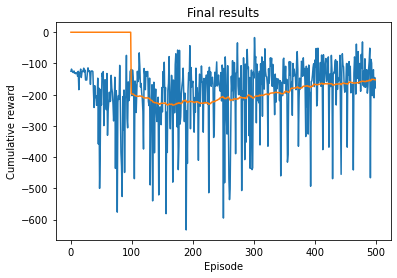

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [118]:
print(f'The mean cumulative reward obtained by the DQN agent: {np.mean(scores_list)}\n')
plot_durations(scores_list, show_result=True)

Current state:


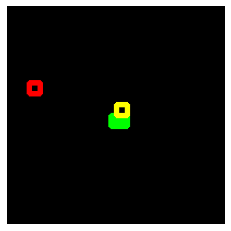

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


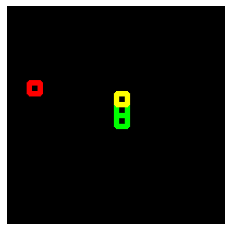

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


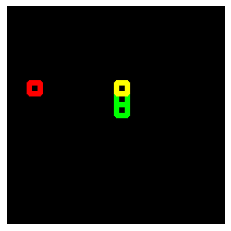

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


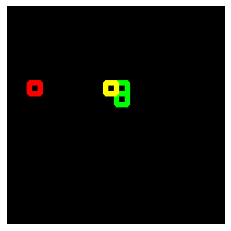

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


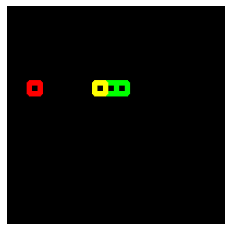

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


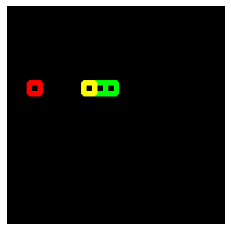

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


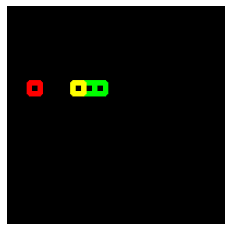

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


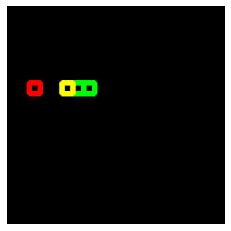

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


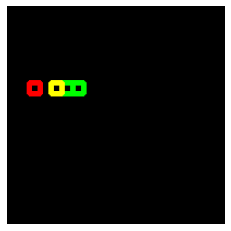

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


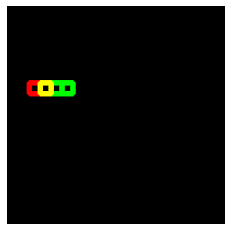

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


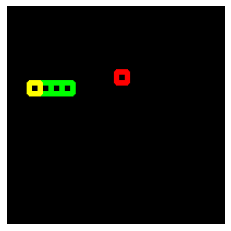

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


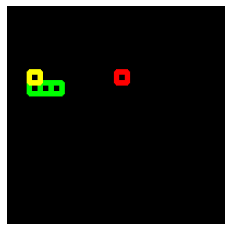

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -3.0

Current state:


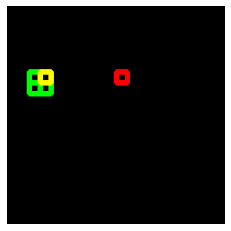

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


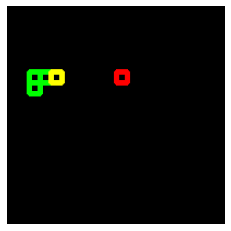

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


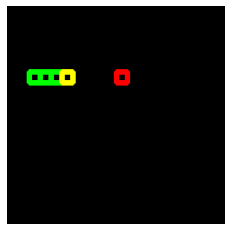

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


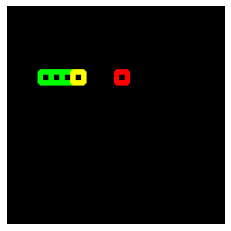

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


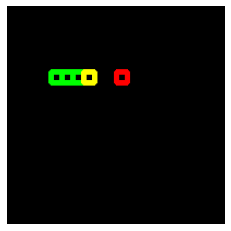

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


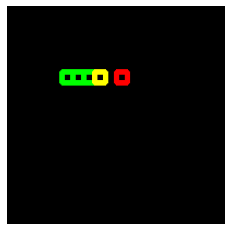

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


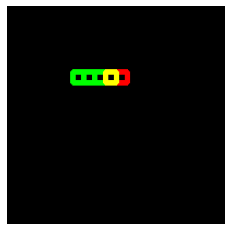

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


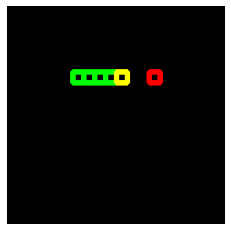

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


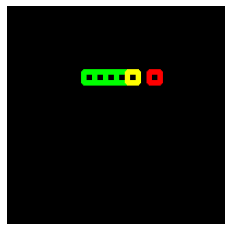

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -3.0

Current state:


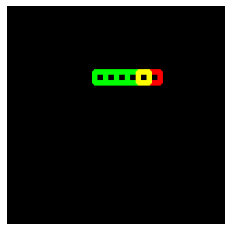

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


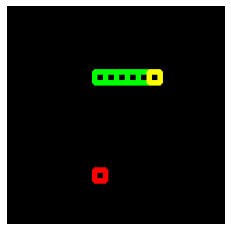

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


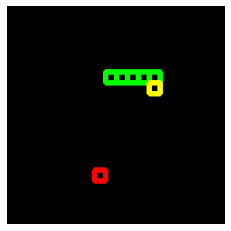

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


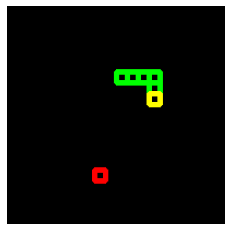

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


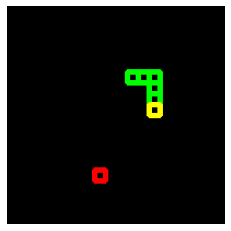

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


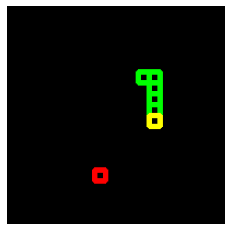

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


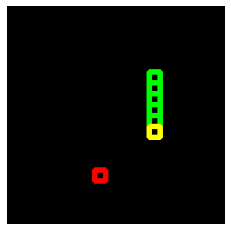

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


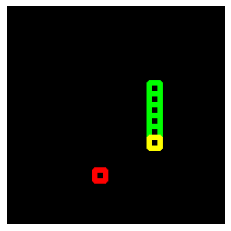

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


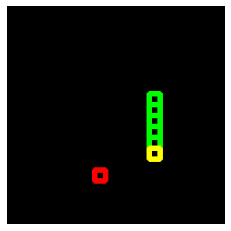

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


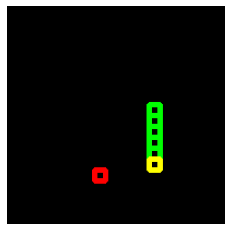

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


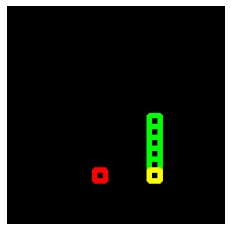

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


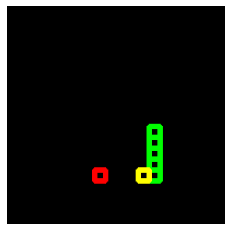

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


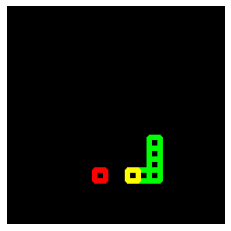

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


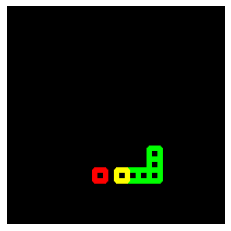

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


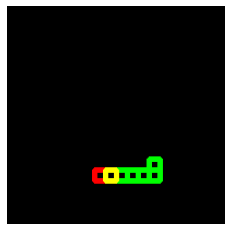

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


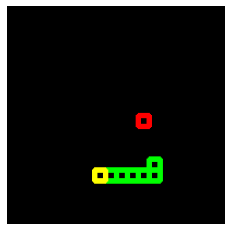

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


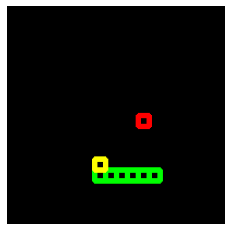

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


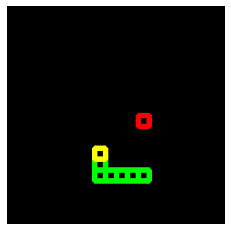

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


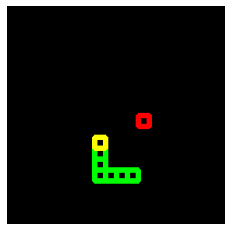

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


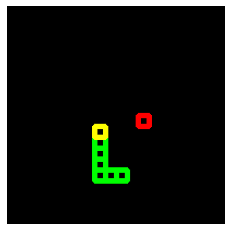

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


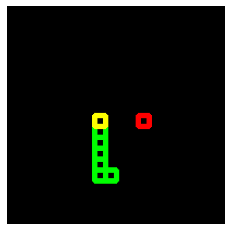

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


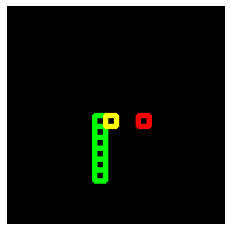

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


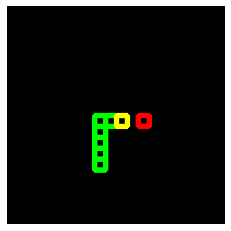

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


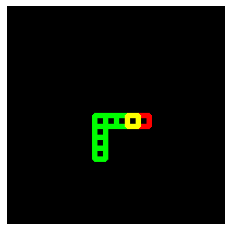

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


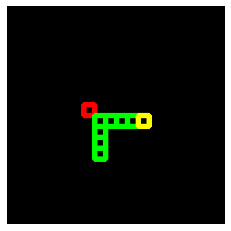

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


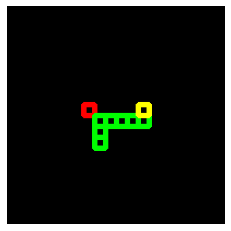

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -3.0

Current state:


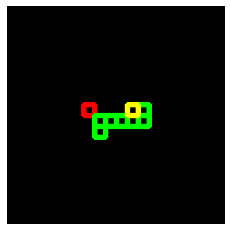

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


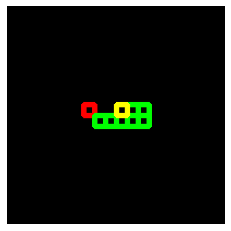

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


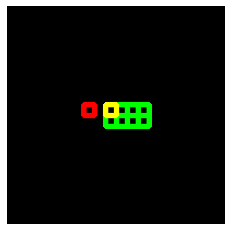

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


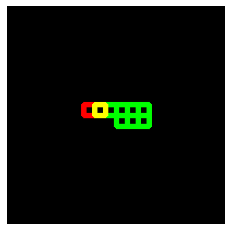

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


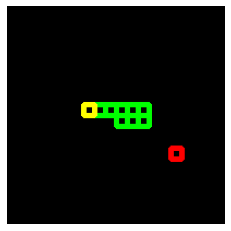

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


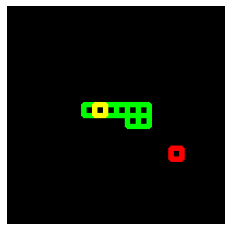

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


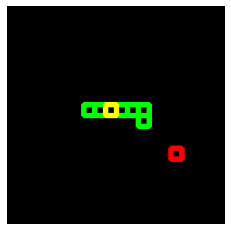

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


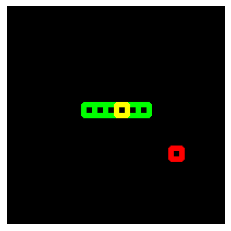

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


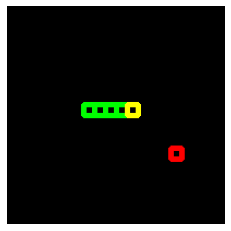

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


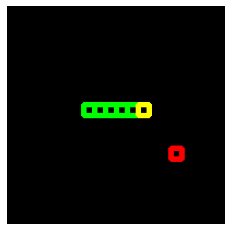

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


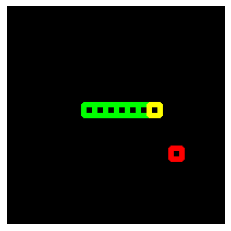

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


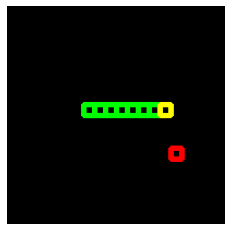

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


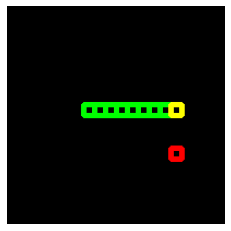

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


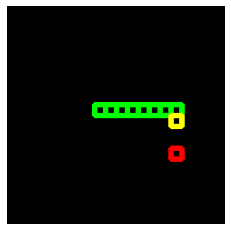

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


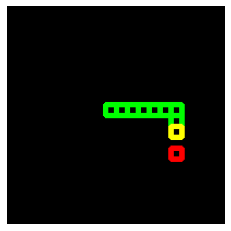

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


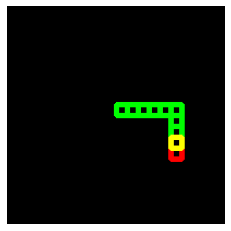

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


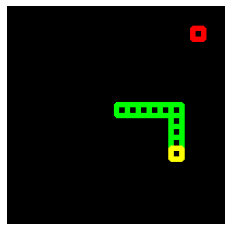

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


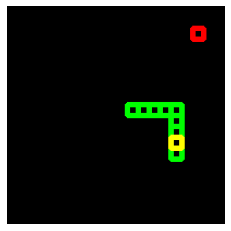

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


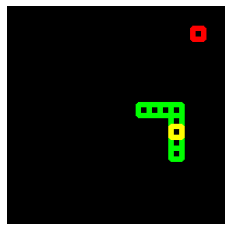

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


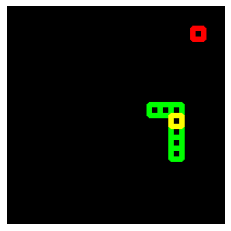

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


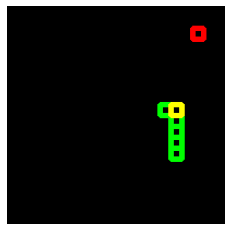

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


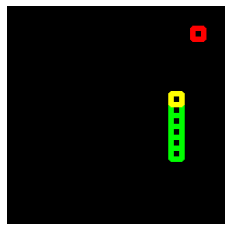

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


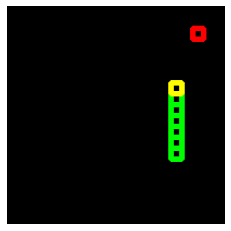

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


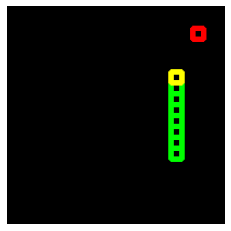

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


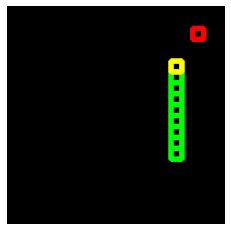

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


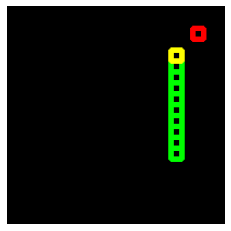

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


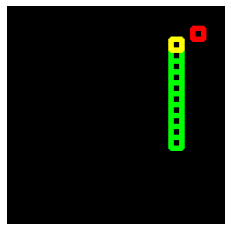

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


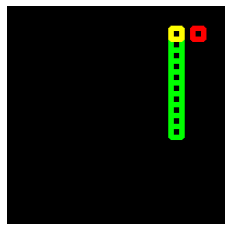

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


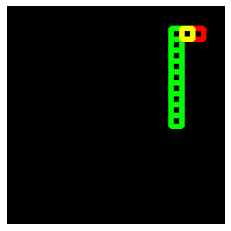

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


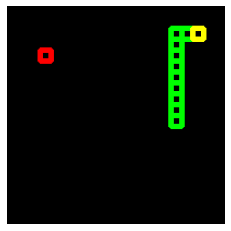

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


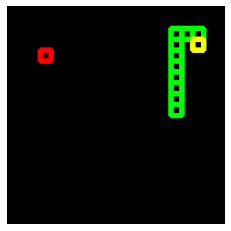

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


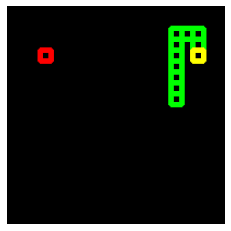

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


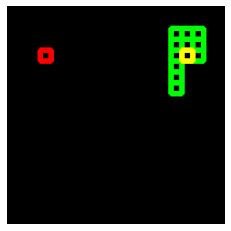

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


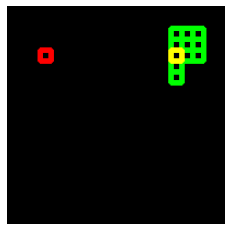

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


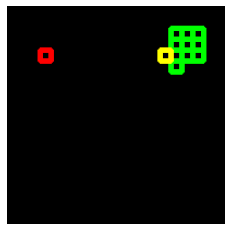

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


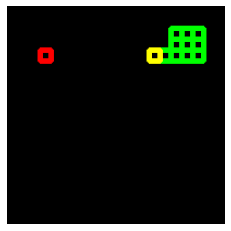

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


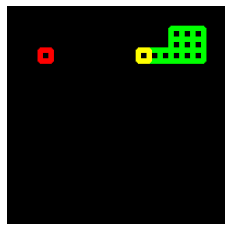

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


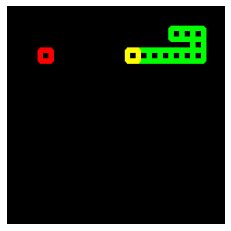

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


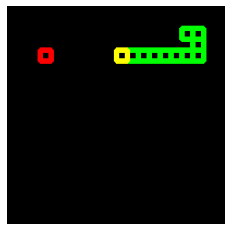

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


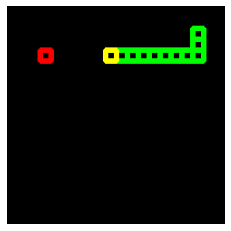

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


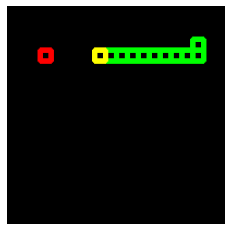

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


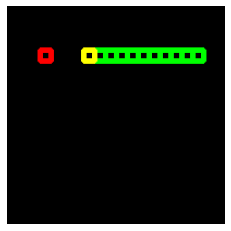

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


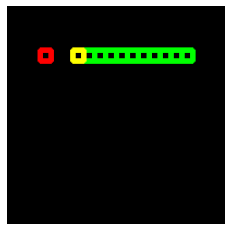

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


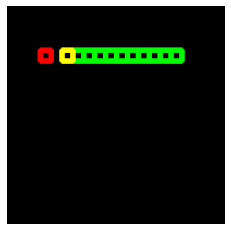

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


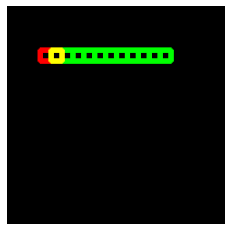

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


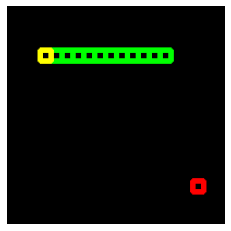

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


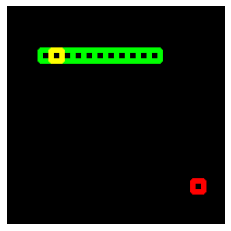

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


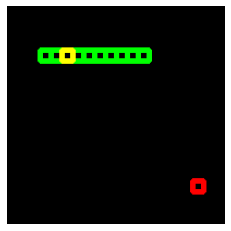

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


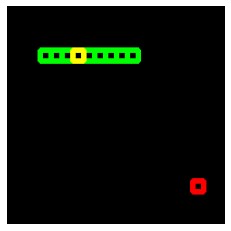

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


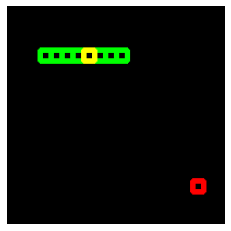

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


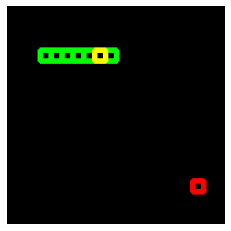

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


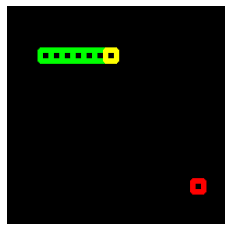

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


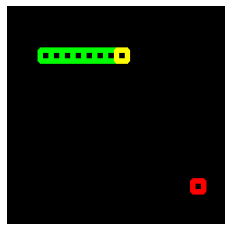

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


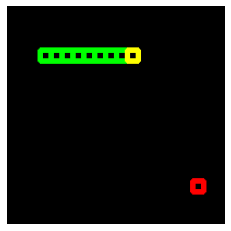

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


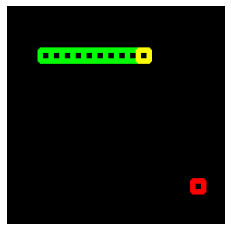

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


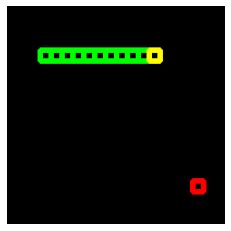

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


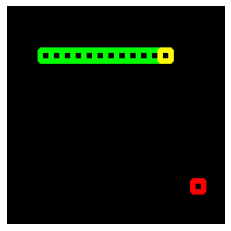

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


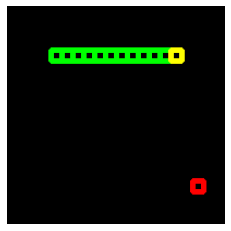

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


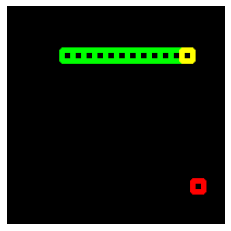

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


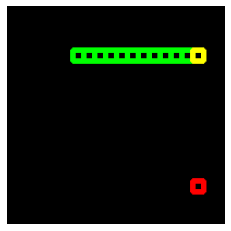

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


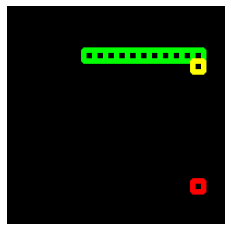

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


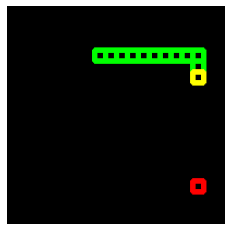

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


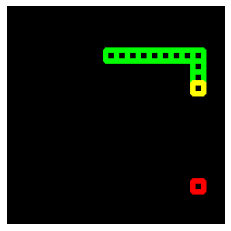

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


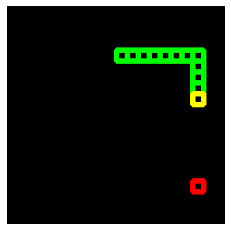

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


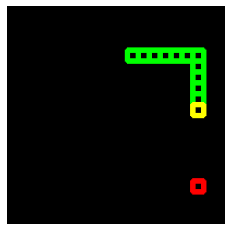

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


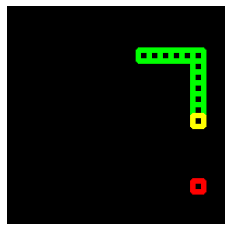

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


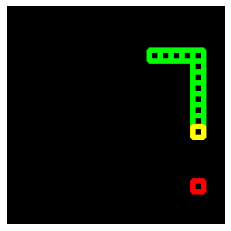

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


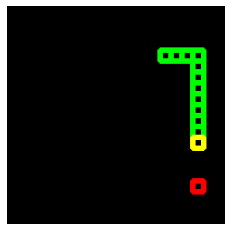

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


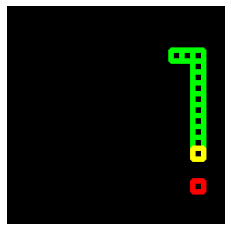

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


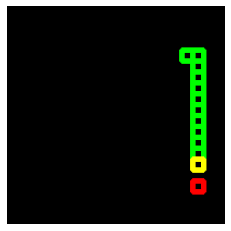

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


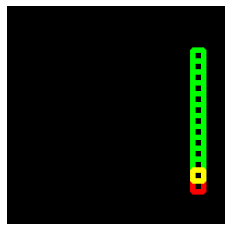

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


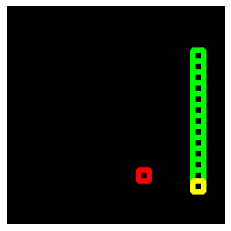

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


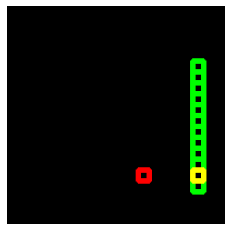

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -3.0

Current state:


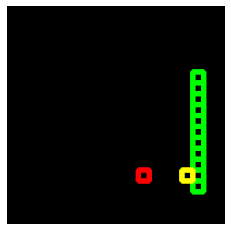

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


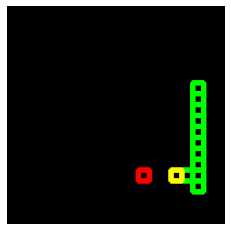

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


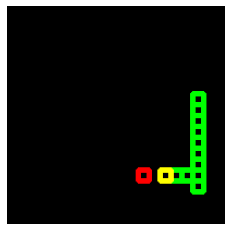

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


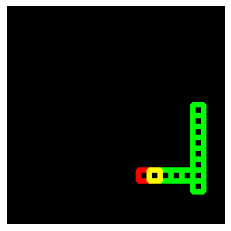

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


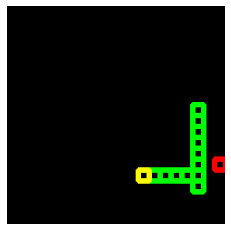

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


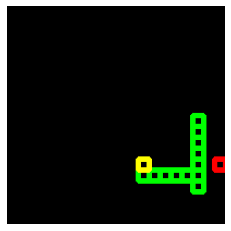

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -3.0

Current state:


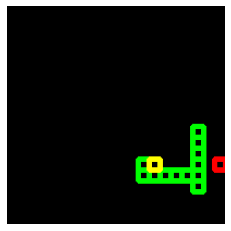

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


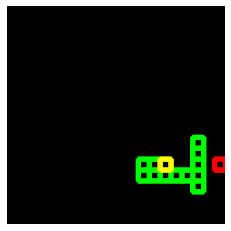

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


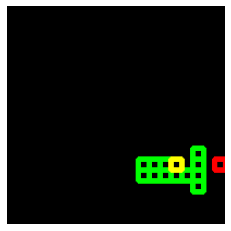

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


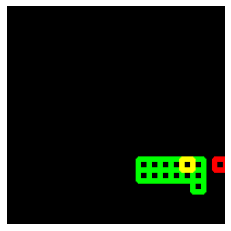

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


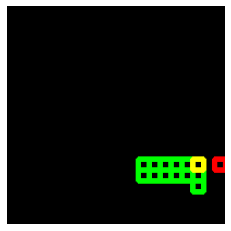

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


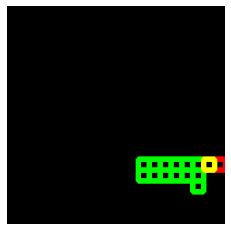

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


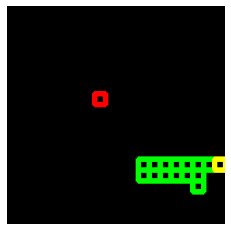

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


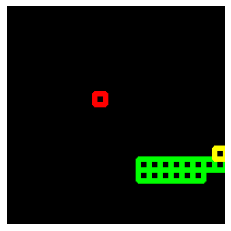

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


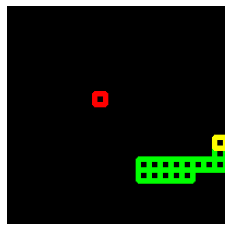

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


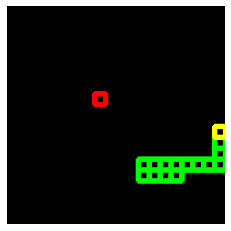

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


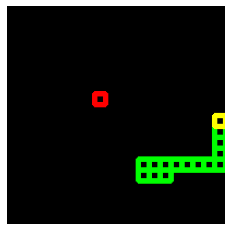

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


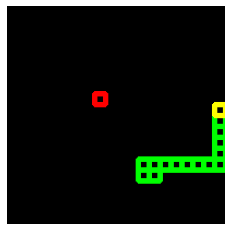

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


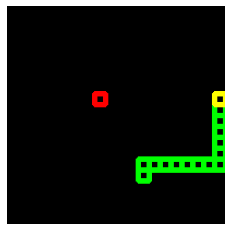

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


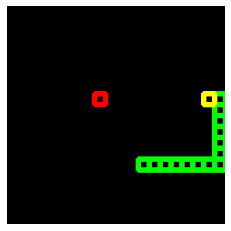

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


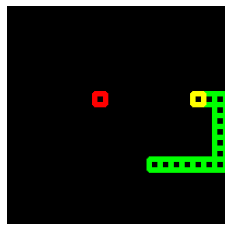

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


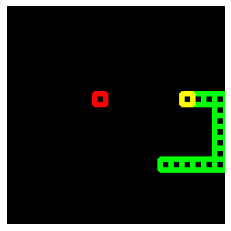

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


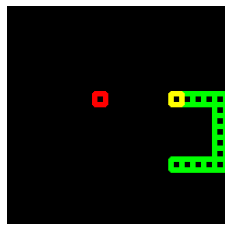

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


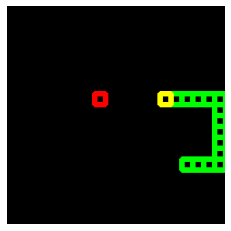

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


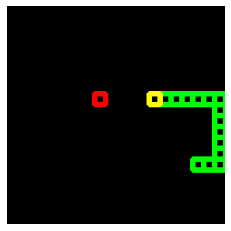

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


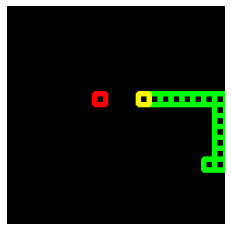

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


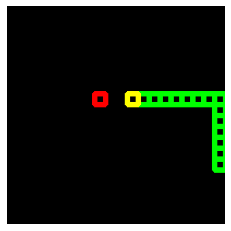

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


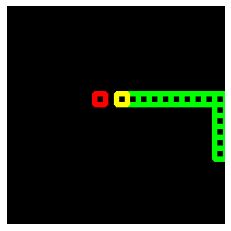

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


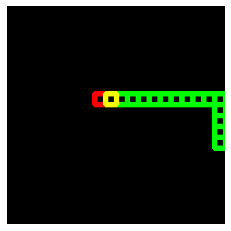

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


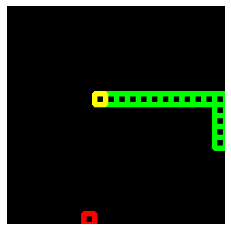

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


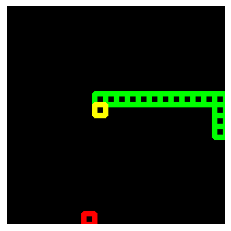

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


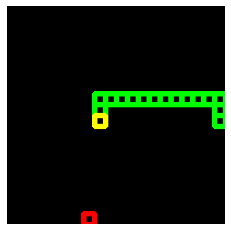

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


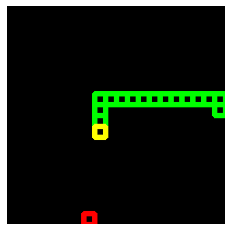

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


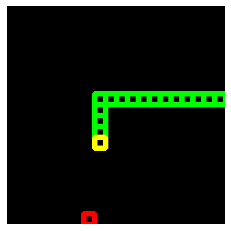

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


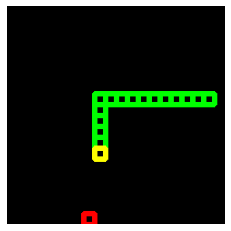

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


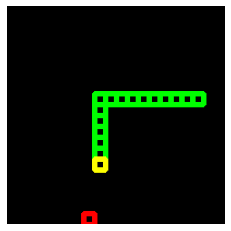

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


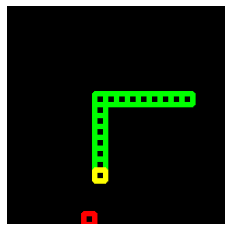

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


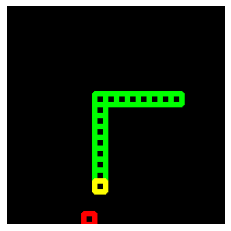

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


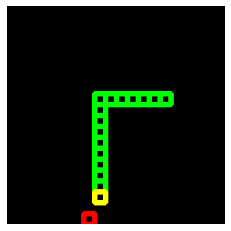

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


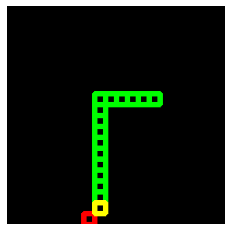

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


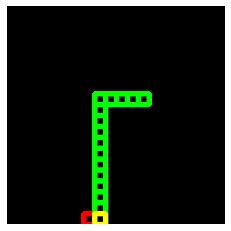

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


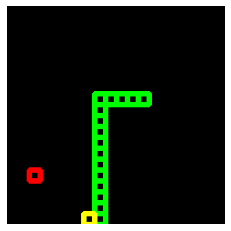

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


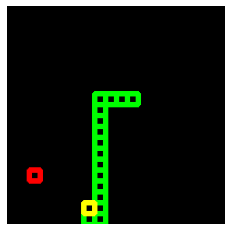

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


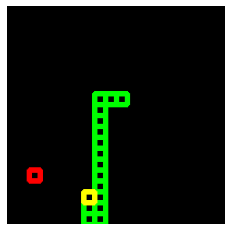

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


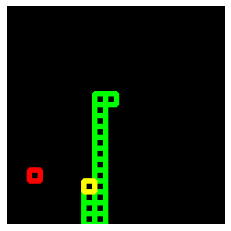

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


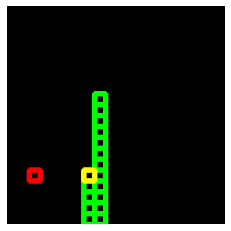

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


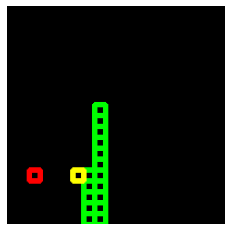

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


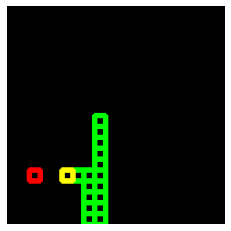

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


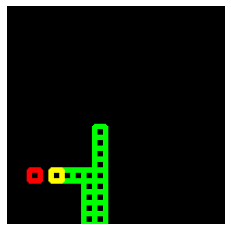

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


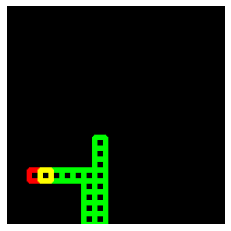

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


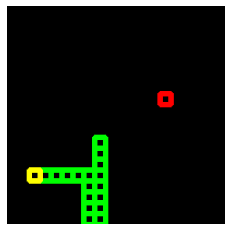

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


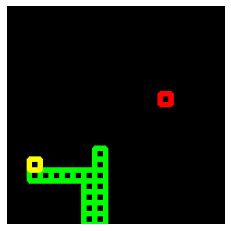

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


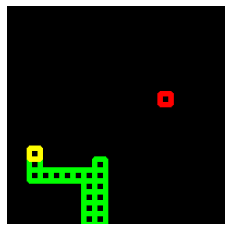

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


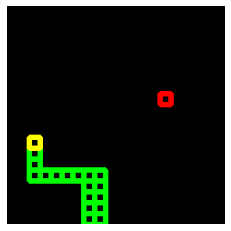

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


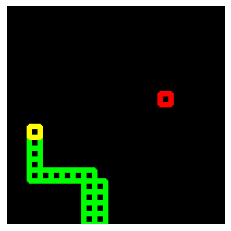

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


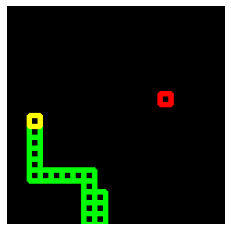

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


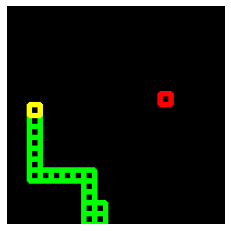

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


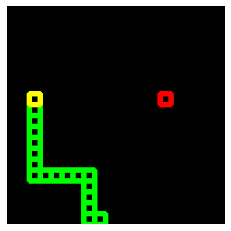

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


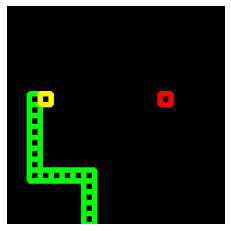

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


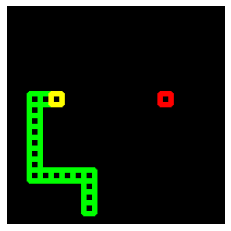

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


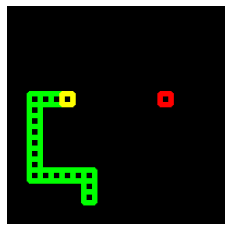

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


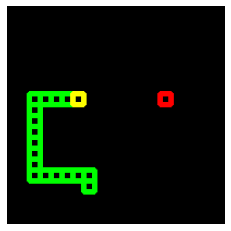

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


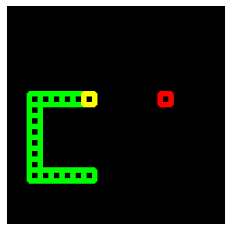

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


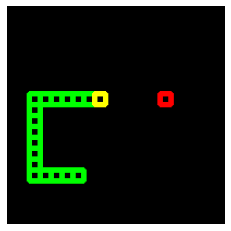

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


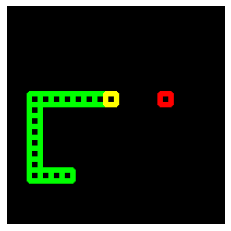

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


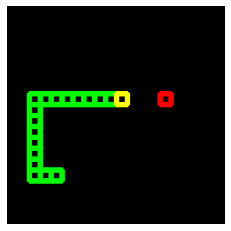

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


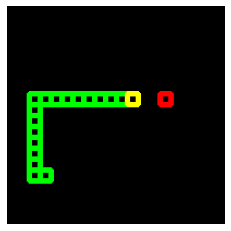

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


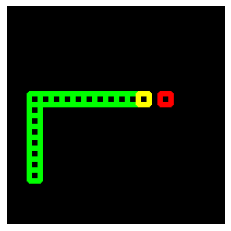

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


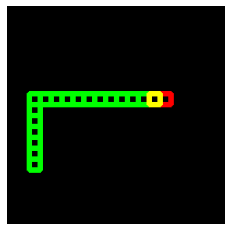

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


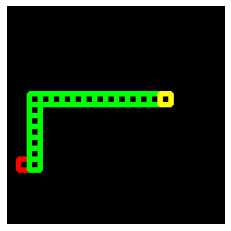

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


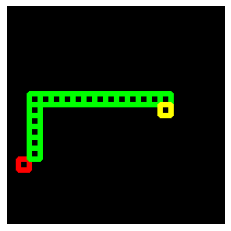

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


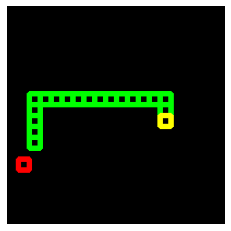

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


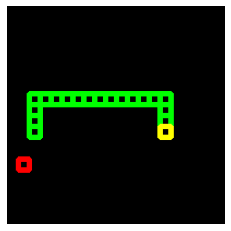

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


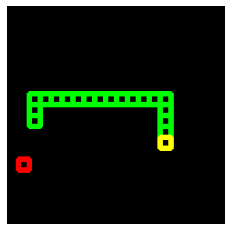

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


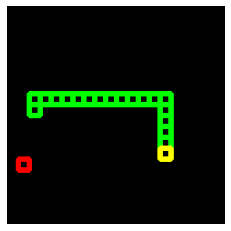

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


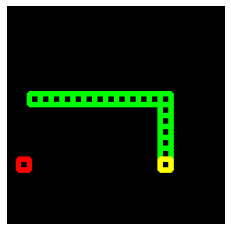

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


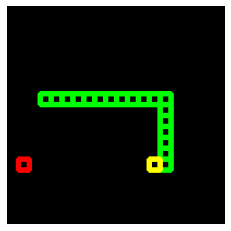

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


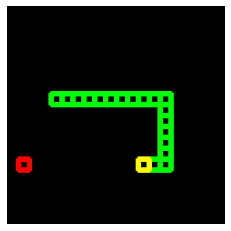

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


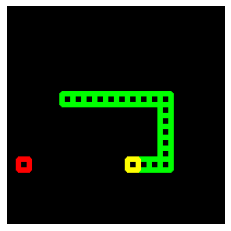

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


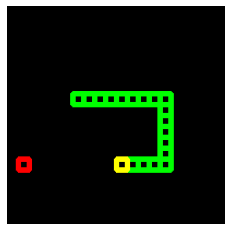

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


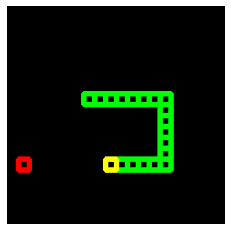

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


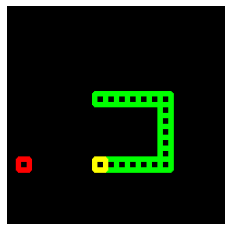

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


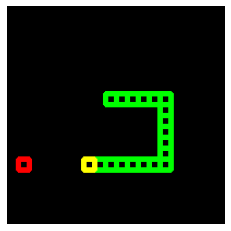

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


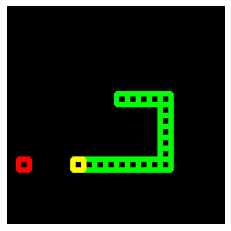

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


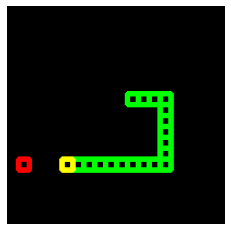

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


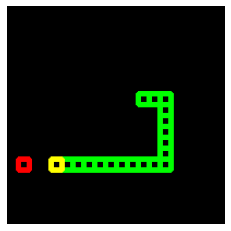

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


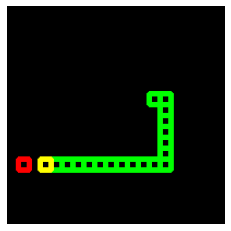

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


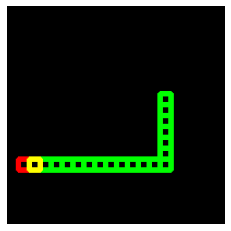

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


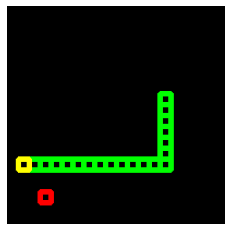

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


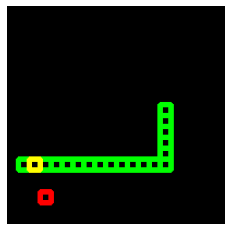

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


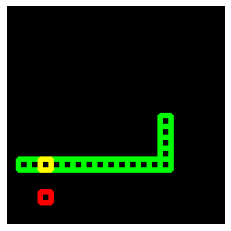

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


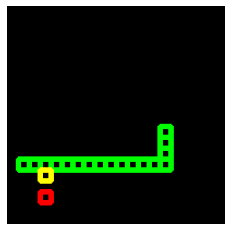

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


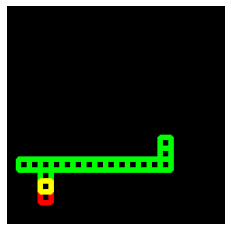

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


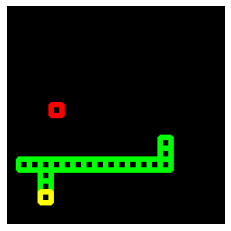

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


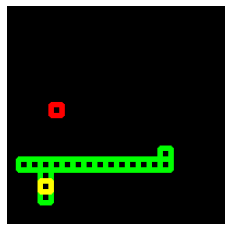

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


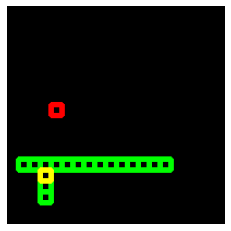

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


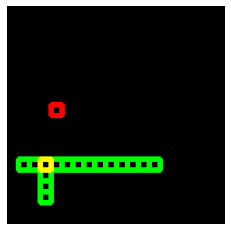

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


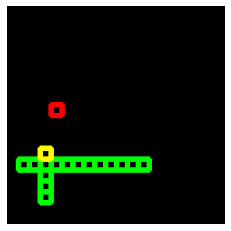

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


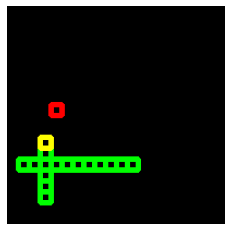

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


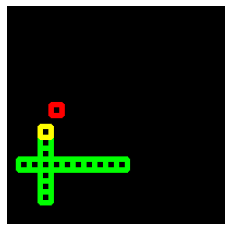

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


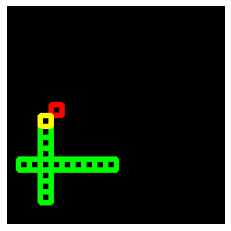

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


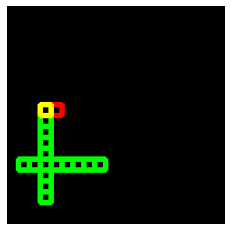

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


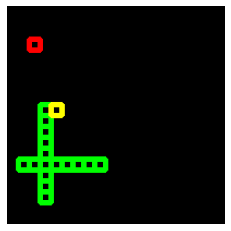

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


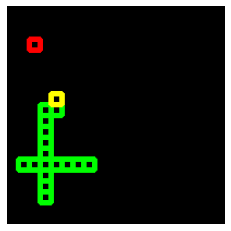

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


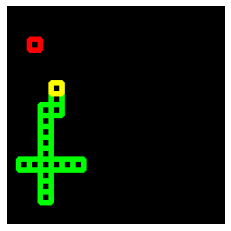

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


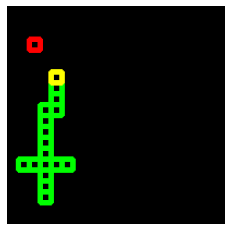

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


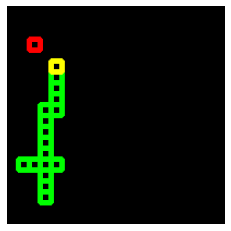

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


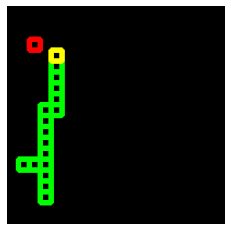

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


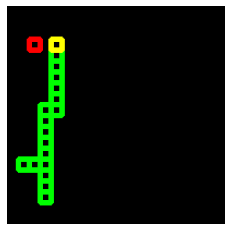

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


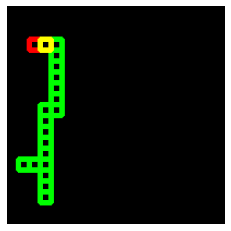

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


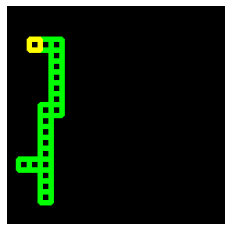

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: 0
Reward received: -1.0

Current state:


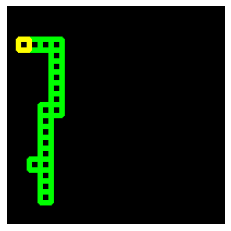

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: 1
Reward received: -3.0

Current state:


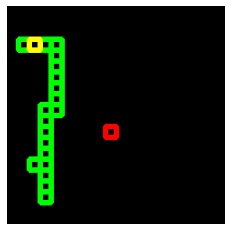

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


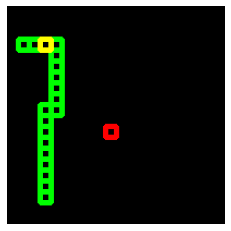

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


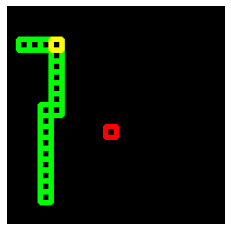

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


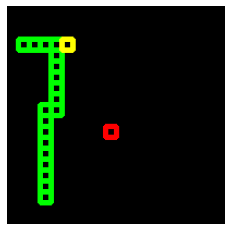

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


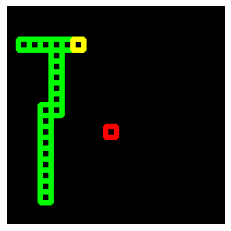

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


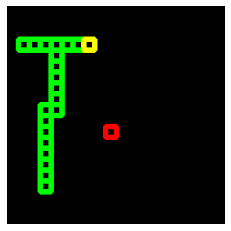

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


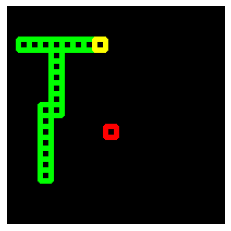

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


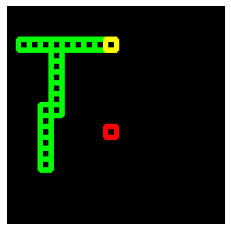

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


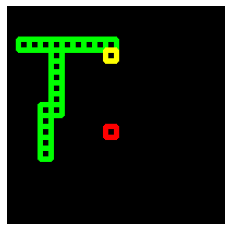

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


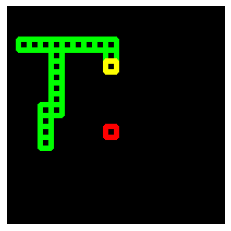

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


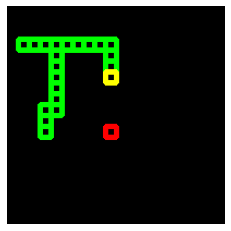

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


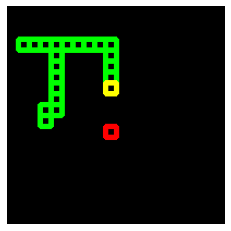

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


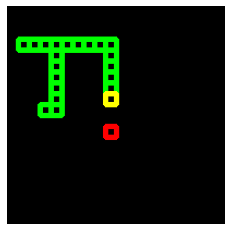

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


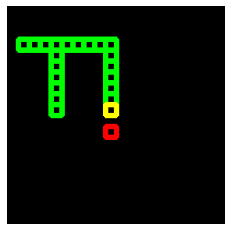

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


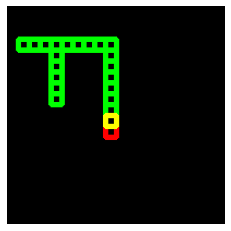

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


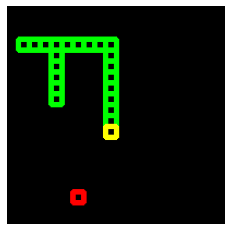

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


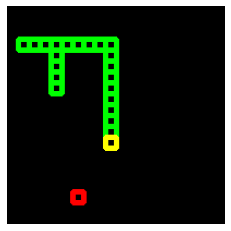

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -3.0

Current state:


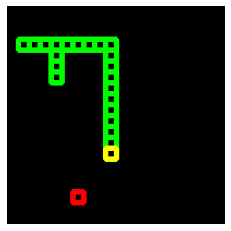

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


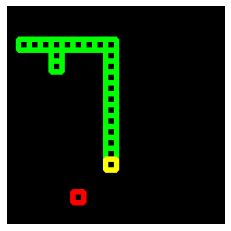

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


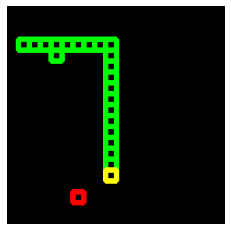

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


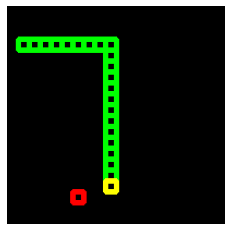

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
Reward received: -1.0

Current state:


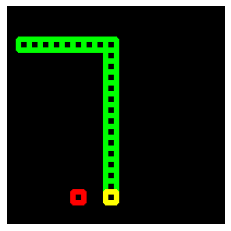

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


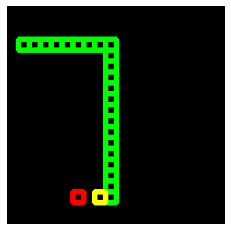

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


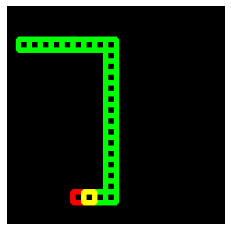

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


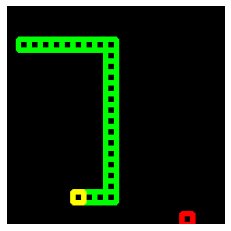

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


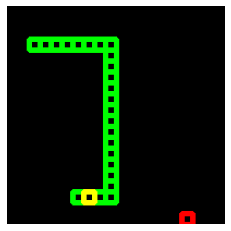

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -3.0

Current state:


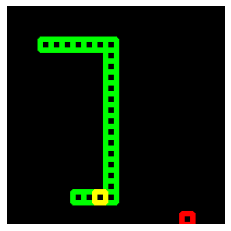

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


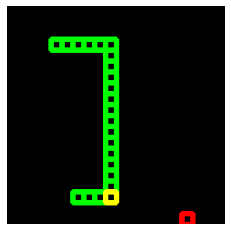

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


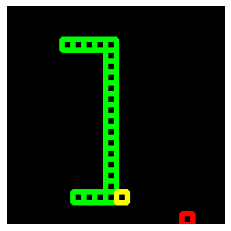

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


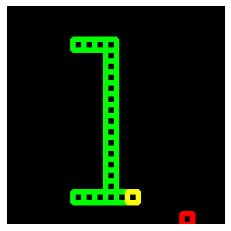

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


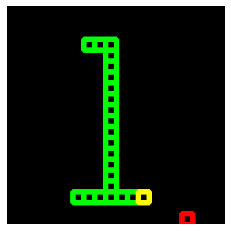

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


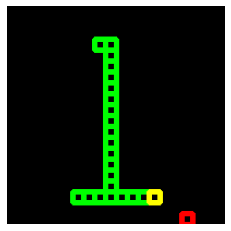

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


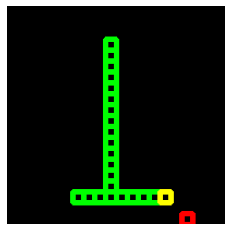

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


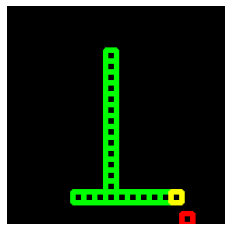

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 1
Reward received: -1.0

Current state:


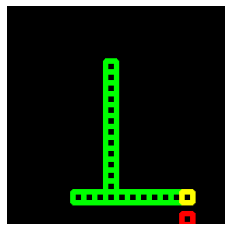

Chosen action: 1 (right)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


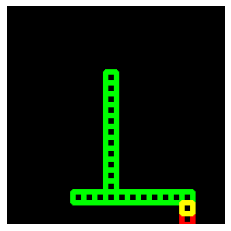

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: 0
Reward received: -1.0

Current state:


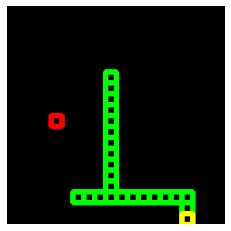

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


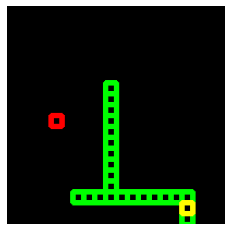

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -3.0

Current state:


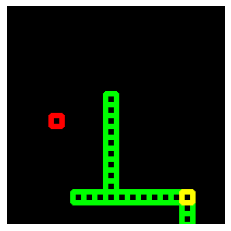

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


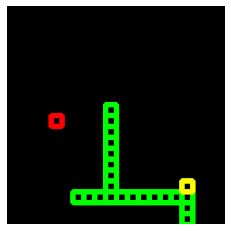

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


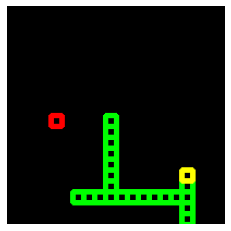

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


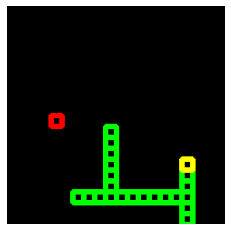

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


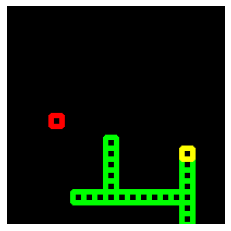

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


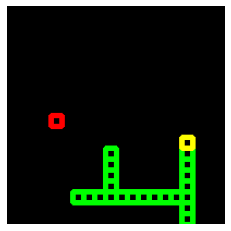

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


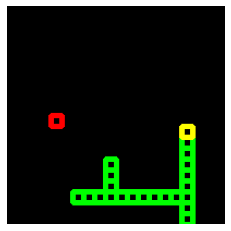

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


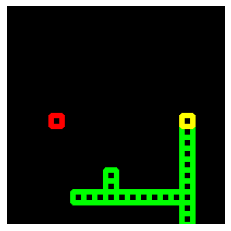

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


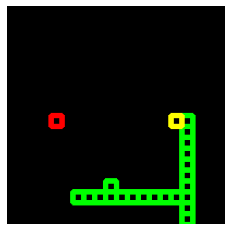

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


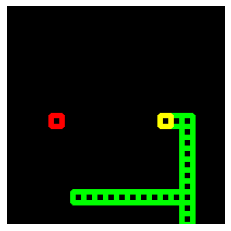

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


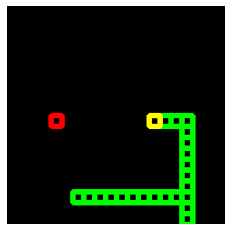

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


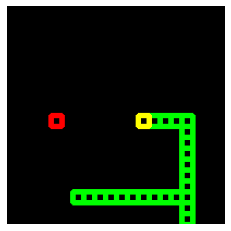

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


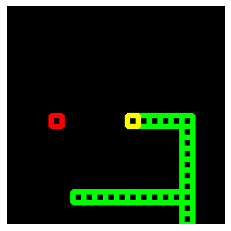

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


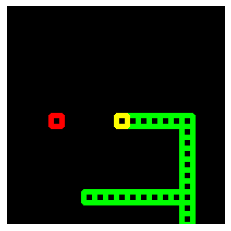

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


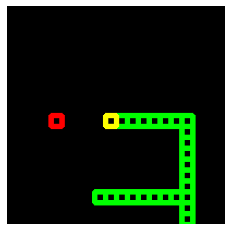

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


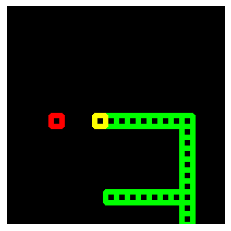

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


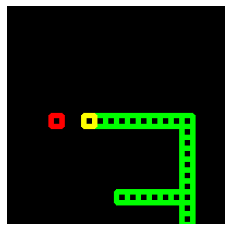

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


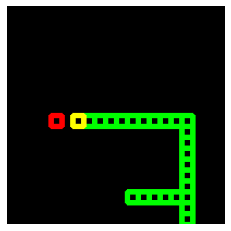

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


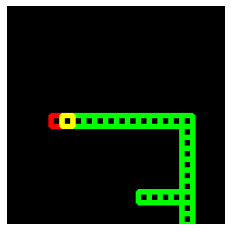

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


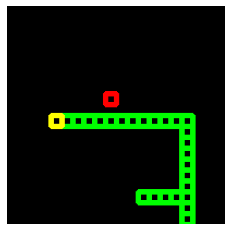

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
Reward received: -1.0

Current state:


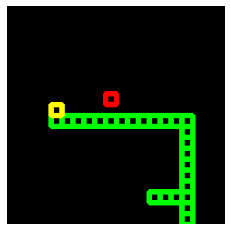

Chosen action: 3 (up)
apple_is_down: -1
apple_is_right: 1
Reward received: -3.0

Current state:


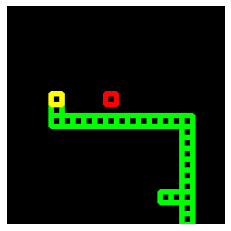

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


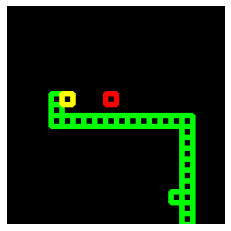

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


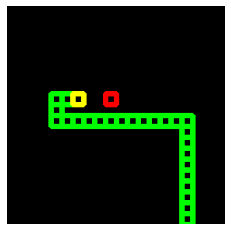

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


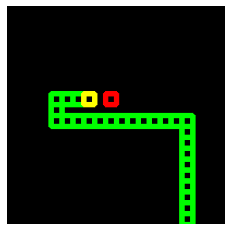

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


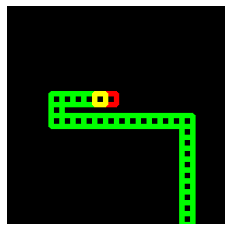

Chosen action: 1 (right)
apple_is_down: 0
apple_is_right: 1
Reward received: -1.0

Current state:


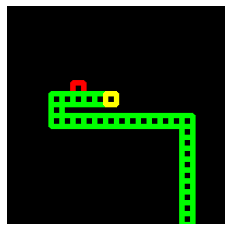

Chosen action: 1 (right)
apple_is_down: -1
apple_is_right: -1
Reward received: -1.0

Current state:


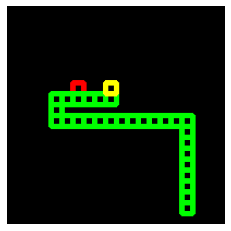

Chosen action: 3 (up)
apple_is_down: 0
apple_is_right: -1
Reward received: -3.0

Current state:


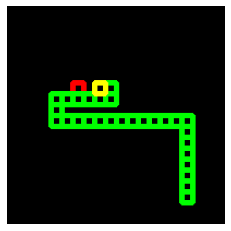

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


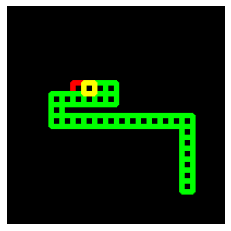

Chosen action: 0 (left)
apple_is_down: 0
apple_is_right: -1
Reward received: -1.0

Current state:


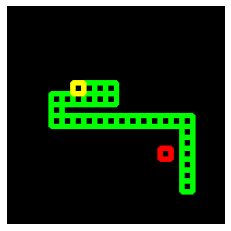

Chosen action: 0 (left)
Reward received: 300


---------- GAME OVER ----------
You lost after eating 27 apples, well done!
Play again?
-------------------------------

Chosen action: 0 (left)
apple_is_down: 1
apple_is_right: 1
Reward received: 300



In [121]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
size = 20
images = []

env = SnakeEnv(length_goal=30, max_mov=2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env.reset()
    state = env.reset()
    while not done:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = agent_dqn.act_greedily(state)
        state, reward, done, info = env.step(action)
        apple_is_down, apple_is_right = state
        print('Current state:')
        img = env.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'Reward received: {reward}\n')
imageio.mimsave('snake_game_DQN.gif', images, fps=10)

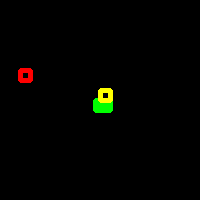

In [122]:
Image(filename="snake_game_DQN.gif")

### 4.3.2 On environment without possible crossing <a class="anchor" id="sub_section_4_3_2"></a>

In [146]:
# Get number of actions and state observations from snake environment
size = 20
env_bound = SnakeEnvBound(length_goal=30, max_mov=2*size, size=size)
action_size = env_bound.action_space.n
state = env_bound.reset()
n_observations = len(state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_dqn_bound = DQNAgent(action_size, n_observations, device)

batch_size = 128
num_episodes = 500
scores_list_bound = []
intermediate_ckpt = False

for episode in range(num_episodes):
    state = env_bound.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False

    while not done:
        action = agent_dqn_bound.act(state)
        next_state, reward, done, info = env_bound.step(action)
        
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
        agent_dqn_bound.remember(state, action, reward, next_state)
        state = next_state
        
        if done:
            scores_list_bound.append(info['cumul_reward'])
            plot_durations(scores_list_bound)
            break

        agent_dqn.replay(batch_size)

        if ((episode+1)%500 == 0) and intermediate_ckpt:
            print(f"Episode: {(episode+1)}/{num_episodes}, score: {info['cumul_reward']}")
            torch.save(agent_dqn.model.state_dict(), f'checkpoint_{(episode+1)}.pth')

<Figure size 432x288 with 0 Axes>

The mean cumulative reward obtained by the DQN agent: -117.342



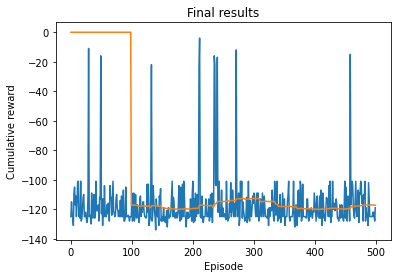

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [147]:
print(f'The mean cumulative reward obtained by the DQN agent: {np.mean(scores_list_bound)}\n')
plot_durations(scores_list_bound, show_result=True)

Current state:


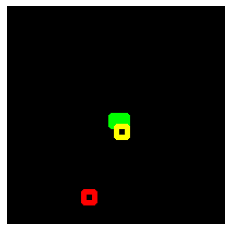

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


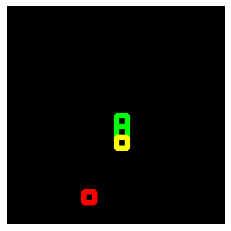

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


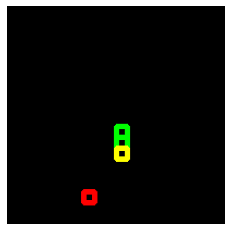

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


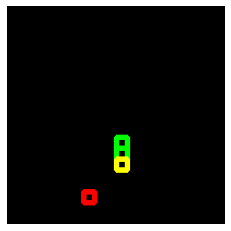

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


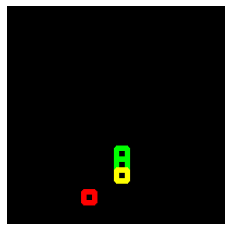

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


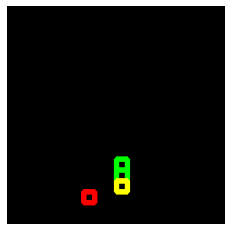

Chosen action: 2 (down)
apple_is_down: 1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


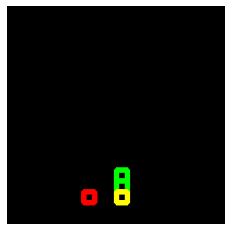

Chosen action: 2 (down)
apple_is_down: 0
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


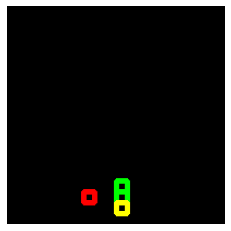

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


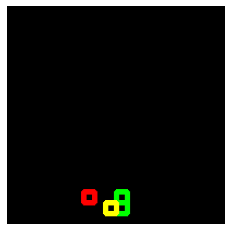

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 0
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


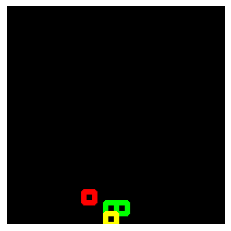

Chosen action: 2 (down)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


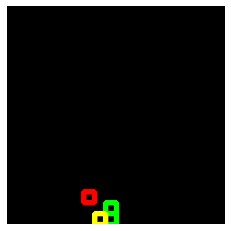

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: -1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


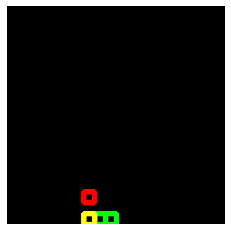

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 0
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -1.0

Current state:


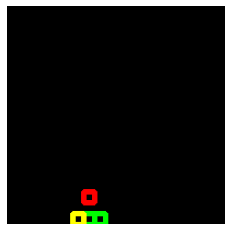

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


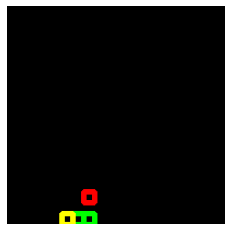

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


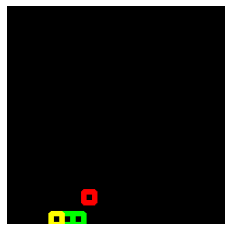

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


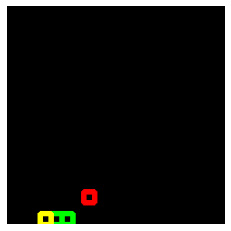

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


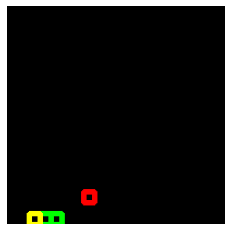

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


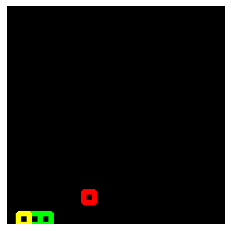

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -3.0

Current state:


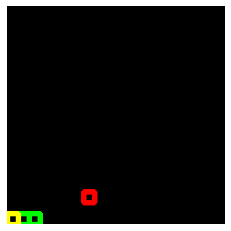

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 1
is_snake_bound_right: 0
Reward received: -3.0

Current state:


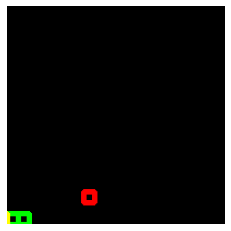

Chosen action: 0 (left)
Reward received: -100


---------- GAME OVER ----------
You lost after eating 0 apples, well done!
Play again?
-------------------------------

Chosen action: 0 (left)
apple_is_down: -1
apple_is_right: 1
is_snake_bound_up: 0
is_snake_bound_down: 1
is_snake_bound_left: 0
is_snake_bound_right: 0
Reward received: -100



In [148]:
episodes = 1
corres_action = {0:'left', 1:'right', 2:'down', 3:'up'}
size = 20
images = []

env_bound = SnakeEnvBound(length_goal=30, max_mov=2*size, size=size)
for episode in range(episodes):
    done = False
    obs = env_bound.reset()
    state = env_bound.reset()
    while not done:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = agent_dqn.act_greedily(state)
        state, reward, done, info = env_bound.step(action)
        apple_is_down, apple_is_right, is_snake_bound_up, is_snake_bound_down, is_snake_bound_left, is_snake_bound_right, snake_at_left, snake_at_right, snake_at_up, snake_at_down = state = state
        print('Current state:')
        img = env_bound.render()
        images.append(img)
        print(f'Chosen action: {action} ({corres_action[action]})')
        print(f'apple_is_down: {apple_is_down}')
        print(f'apple_is_right: {apple_is_right}')
        print(f'is_snake_bound_up: {is_snake_bound_up}')
        print(f'is_snake_bound_down: {is_snake_bound_down}')
        print(f'is_snake_bound_left: {is_snake_bound_left}')
        print(f'is_snake_bound_right: {is_snake_bound_right}')
        print(f'Reward received: {reward}\n')
imageio.mimsave('snake_game_DQN_bound.gif', images, fps=10)

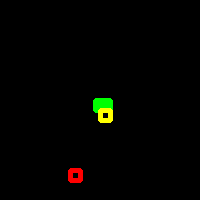

In [149]:
Image(filename="snake_game_DQN_bound.gif")